In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef, make_scorer, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import warnings


from matplotlib.gridspec import GridSpec
from seaborn.palettes import SEABORN_PALETTES
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from cfg_parser import CFGGlycanParser
from cfg_array_versions import get_likely_cfg_array_version
from glycan_graph_methods import get_frequent_subtrees, run_fast_mrmr, add_termini_nodes_to_graphs, graph_fingerprint
from glycan_graph_methods import generate_digraph_from_glycan_string, GlycanData, find_root_node
from glycan_plotting import draw_glycan_diagram
from glycan_feature_extraction import get_parent_edge_type_features


_GBOLT_PATHS = ['/home/andrew/Projects/DataMining-gSpan/build/gbolt',
                '/home/andrew/programs/fast-mRMR/cpu/src/']
_MRMR_PATHS = ['/home/andrew/Projects/fast-mRMR/cpu/src/',
               '/home/andrew/programs/fast-mRMR/cpu/src/']
_MRMR_READER_PATHS = ['/home/andrew/Projects/fast-mRMR/utils/data-reader/mrmr-reader',
                      '/home/andrew/programs/fast-mRMR/utils/data-reader/mrmr-reader']

# Account for different setups on different computers. Best option is to set as an env var
try:
    GBOLT_PATH = os.environ['GBOLT_PATH']
except KeyError:
    for gbolt_path in _GBOLT_PATHS:
        if os.path.isfile(gbolt_path):
            GBOLT_PATH = gbolt_path
            break
        else:
            GBOLT_PATH = None

try:
    MRMR_BIN_DIR = os.environ['MRMR_BIN_DIR']
except KeyError:
    for mrmr_path in _MRMR_PATHS:
        if os.path.isdir(mrmr_path):
            MRMR_BIN_DIR = mrmr_path
            break
        else:
            MRMR_BIN_DIR = None

try:
    MRMR_READER_PATH = os.environ['MRMR_READER_PATH']
except KeyError:
    for mrmr_path in _MRMR_READER_PATHS:
        if os.path.isfile(mrmr_path):
            MRMR_READER_PATH = mrmr_path
            break
        else:
            MRMR_READER_PATH = None
        

%matplotlib inline

In [6]:
def get_all_frequent_subtrees(glycan_graphs, binding_class, support_all=0.05, support_pos=0.3, gbolt_path=GBOLT_PATH):
    '''Gets all frequent subtrees from both all graphs, as well as positive binders only.
    
    Uses different thresholds for each.
    
    Args:
        glycan_graphs (list): A list of glycan graphs as nx.DiGraph objects.
        binding_class (np.array): A numpy array of binding classes, where 0 = no binding,
            1 = strong binding.
        support_all (float): Minimum support for subtrees from all graphs.
        support_pos (float): Minimum support for subtrees from positive binding graphs.
        gbolt_path (str): Path to gBolt executable.
    Returns:
        list: A list of dictionaries with keys 'subtree' and 'parents'. Subtree objects are
            found under 'subtree' key, while the id of parent trees that contain that
            subgraph are given in a list under the 'parents' key.
        '''
    glycan_graphs_pos = [glycan for glycan, binding in zip(glycan_graphs, binding_class) if binding == 1]
    frequent_subtrees_pos = get_frequent_subtrees(glycan_graphs_pos, 
                                                  gbolt_path=gbolt_path, 
                                                  support=support_pos)
    positive_indices = np.where(binding_class == 1)[0]
    for frequent_subtree in frequent_subtrees_pos:
        frequent_subtree['parents'] = [positive_indices[x] for x in frequent_subtree['parents']]
    # Get frequent subtrees using gBolt.
    # Default support is set to 5%. Seems to be a reasonable threshold that doesn't miss important subtrees.
    frequent_subtrees = get_frequent_subtrees(glycan_graphs, 
                                              gbolt_path=gbolt_path, 
                                              support=support_all)
    #Initial filtering to remove duplicates
    graph_fingerprints_main = set(graph_fingerprint(x['subtree']) for x in frequent_subtrees)
    graph_fingerprints_positive = [graph_fingerprint(x['subtree']) for x in frequent_subtrees_pos]
    new_subtrees = []
    for i, fingerprint in enumerate(graph_fingerprints_positive):
        if fingerprint not in graph_fingerprints_main:
            new_subtrees.append(frequent_subtrees_pos[i])
            
    nm = nx.isomorphism.categorical_node_match('label', None)
    em = nx.isomorphism.categorical_edge_match('label', None)
    
    #For new subtrees, find all parents graphs 
    for new_subtree in new_subtrees:
        parents = new_subtree['parents']
        for i, main_graph in enumerate(glycan_graphs):
            if i in parents:
                continue
            GM = nx.isomorphism.DiGraphMatcher(main_graph, new_subtree['subtree'], node_match=nm, edge_match=em)
            if GM.subgraph_is_isomorphic():
                parents.append(i)
        parents.sort()
        new_subtree['parents'] = parents
    return frequent_subtrees + new_subtrees


def extract_features_from_glycan_list(glycan_list, binding_class, parent_edge_types=False):
    '''Get list of features from an initial list of glycans (as CFG strings).
    
    Uses MRMR to generate candidate list of motifs from a DiGraph representation 
    with null nodes added.
    
    Extraction of frequent subtrees is performed using gBolt, a fast implementation of gSpan.
    
    Args:
        full_glycan_list (list): A full list of glycans with which to generate subtrees.
        glycan_list (list): A list of glycans as CFG-formatted strings.
        binding_class (np.array): Output classes, with 0 indicating no binding and 1 
            indicating positive binding.
        parent_edge_types (bool): Extend subtrees by adding extra features for each parent edge type.
    Returns:
        list: A final set of features selected by MRMR.
        list: A list of dictionaries containing information of a particular subtree/motif. Dictionary keys include 
            `'parents'`, which contains the index of all parent glycans for that particular subtree, `'subtree'`, 
            which contains the DiGraph implementation of that subtree, and optionally `'sibling_count'`, which contains
            the number of sibling nodes for the root node of that subtree (inclusive of the root node).
        DataFrame: A DataFrame containing all features extracted (including those not selected by MRMR)
    '''
    cfg_graphs = [generate_digraph_from_glycan_string(glycan, parse_linker=True) for glycan in glycan_list]
    cfg_graphs_null_nodes = add_termini_nodes_to_graphs(cfg_graphs)
    # Get frequent subtrees using gBolt.
    # Support is set to 5%. Seems to be a reasonable threshold that doesn't miss important subtrees.
    frequent_subtrees = get_all_frequent_subtrees(cfg_graphs_null_nodes, binding_class,
                                                  support_all=0.05, support_pos=0.4,
                                                  gbolt_path=GBOLT_PATH)
    # We now need to generate a set of input features based on frequent subtrees.
    number_of_glycans = len(cfg_graphs_null_nodes)
    number_of_features = len(frequent_subtrees)
    features_ = np.zeros((number_of_glycans, number_of_features), dtype='int')

    for i, frequent_subtree in enumerate(frequent_subtrees):
        for parent in frequent_subtree['parents']:
            features_[parent][i] = 1

    feature_df = pd.DataFrame(features_, columns=[str(i) for i in range(number_of_features)])
    feature_df.insert(0, 'class', binding_class)
    # Select top features using mRMR algorithm, using the fast-mrmr implementation.
    feature_set_by_mrmr = run_fast_mrmr(feature_df, mrmr_bin_dir=MRMR_BIN_DIR, mrmr_reader=MRMR_READER_PATH, num_features=10)
    
    # Don't calculate parent edge types.
    if not parent_edge_types:
        frequent_subtrees_subset = [frequent_subtrees[int(x)] for x in feature_set_by_mrmr]
        return feature_set_by_mrmr, frequent_subtrees_subset, feature_df
    
    feature_df_extended, frequent_subtrees_extended = get_parent_edge_type_features(feature_df, feature_set_by_mrmr, frequent_subtrees, cfg_graphs_null_nodes)
    feature_set_by_mrmr_extended = run_fast_mrmr(feature_df_extended, mrmr_bin_dir=MRMR_BIN_DIR, mrmr_reader=MRMR_READER_PATH, num_features=10)

    frequent_subtrees_subset = [frequent_subtrees_extended[int(x)] for x in feature_set_by_mrmr_extended]
    return feature_set_by_mrmr_extended, frequent_subtrees_subset, feature_df_extended

def plot_coefficients_and_subtrees(classifier, frequent_subtrees, ax, top_features=5, 
                                   positive_color='blue', negative_color='red'):
    '''Plot the top positive and negative coefficients from a classifier.

    Also plots relevant glycans for each position.

    Args:
        classifier: A classifier object from sklearn.
        frequent_subtrees (dict): A dictionary of frequent subtrees returned by the `get_frequent_subtrees` method.
        ax (AxesSubplot): Matplotlib axis.
        top_features (int): Number of top features to plot for both positive and negative coefficents.
        positive_color (str): Color for positive coefficients
        negative_color (str): Color for negative coefficients.
    Returns:
        Axis: A matplotlib Axis object.
    '''
    # Translate sibling counts into something more intuitive.
    sibling_count_dict = {"<3": "Less than 2", "1": "No"}
    coef = classifier.coef_.ravel()
    top_coefficients = np.argsort(coef)[-top_features:]
    #top_negative_coefficients = np.argsort(coef)[:top_features]
    #top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # Generate glycan plots
    max_abs_value = max(np.abs(coef)) * 1.1
    for i, feature in enumerate(top_coefficients[::-1]):
        if coef[feature] > 0:
            y_pos = -0.5 * max_abs_value
        else:
            y_pos = 0.5 * max_abs_value
        x_pos = i
        y_height = max_abs_value
        inset_ = inset_axes(ax,
                        width='100%',
                        height='100%',
                        bbox_transform=ax.transData, # relative axes coordinates
                        bbox_to_anchor=(x_pos - 0.5, y_pos - y_height/2, 1, y_height),
                        loc=10)                       # loc=lower left corner
        plt.sca(inset_)
        
        sibling_count = frequent_subtrees[feature].get('sibling_count', None)
        
        if sibling_count:
            sibling_count = sibling_count_dict[sibling_count]
            ax.text(x_pos, y_pos * 1.8, f"{sibling_count} siblings", va='center', ha='center')

        draw_glycan_diagram(frequent_subtrees[feature]['subtree'], inset_,
                            draw_terminal_connection_labels=True)
    colors = [negative_color if c < 0 else positive_color for c in coef[top_coefficients]]
    ax.bar(np.arange(top_features), coef[top_coefficients[::-1]], color=colors[::-1])
    ax.set_xticks(np.arange(0, top_features))
    ax.set_xlabel("Feature", fontsize='xx-large')
    ax.set_ylabel("Coefficient", fontsize='xx-large')
    ax.set_ylim((-max_abs_value, max_abs_value))
    for label in ax.get_yticklabels():
        label.set_fontsize('xx-large')
    return ax

def perform_logistic_regression(feature_df, feature_set, random_state=None, class_weight=None):
    '''Train logistic regression on training dataset.'''
    # Create a scoring function for assessing classifier performance.
    # Use Matthew's Correlation Coefficient for scoring. Unbiased, useful for imbalanced datasets.
    mcc_scorer = make_scorer(matthews_corrcoef)

    X = feature_df.loc[:, feature_set].values
    y = feature_df.iloc[:, 0].astype('bool').astype('int').values

    logistic_clf = LogisticRegression(random_state=random_state, penalty='l2', C=np.inf, solver='lbfgs', class_weight=class_weight)

    # Perform cross-validation, as we have a relatively small dataset.
    cv_gen = StratifiedKFold(5, shuffle=True, random_state=random_state)
    scores = cross_val_score(logistic_clf, X, y, cv=cv_gen, scoring=mcc_scorer)
    print("Logistic regression")
    print("MCC score: {score:.3g}".format(score=np.mean(scores)))
    print("stdev: {stdev:.3g}\n".format(stdev=np.std(scores)))
    
    # Fit final classifier on full training dataset.
    # Will use this to evaluate on test set.
    logistic_clf.fit(X, y)
    y_pred = logistic_clf.predict(X)
    con_mat_train = confusion_matrix(y, y_pred)
    return logistic_clf, scores, con_mat_train

def plot_confusion_matrix(ax, confusion_matrix,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix
    classes = [0, 1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

def plot_roc_curve(ax, y, X, logistic_clf, title=""):
    fpr, tpr, _ = roc_curve(y, logistic_clf.predict_proba(X)[:,1], drop_intermediate=False)
    ax.set_title(title)
    ax.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc(fpr, tpr): 2.3f})')
    ax.plot([0,1], [0,1], linestyle='--', color='grey')
    ax.legend(loc="lower right")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return ax

def generate_features_from_subtrees(frequent_subtree_features, glycan):
    '''Generate a feature set for an individual glycan based on a set of chosen subtree features.
    
    Args:
        frequent_subtree_features (list): A list of frequent subtree features.
        glycan (DiGraph): A candidate glycan in nx.DiGraph format (with null nodes).
    Returns:
        np.array: An array of features, corresponding to provided subtrees.
    '''
    main_graph = glycan
    features = []
    for subtree in frequent_subtree_features:
        nm = nx.isomorphism.categorical_node_match('label', None)
        em = nx.isomorphism.categorical_edge_match('label', None)

        link_types = {'alpha': 'a', 'beta': 'b', 'unknown_link': ''}

        parent_link = None
        # Check if parent edge type is in subtree.
        for node_id, label in nx.get_node_attributes(subtree, 'label').items():
            if label in link_types:
                parent_link = link_types[label]
                subtree = subtree.copy()
                subtree.remove_node(node_id)
                break

        root_node = find_root_node(subtree)

        is_subtree = 0
        GM = nx.isomorphism.DiGraphMatcher(main_graph, subtree, node_match=nm, edge_match=em)
        if parent_link is not None:
            for match in GM.subgraph_isomorphisms_iter():
                reverse_match = {v: k for k, v in match.items()}
                root_in_main_graph = reverse_match[root_node]
                parents = list(main_graph.predecessors(root_in_main_graph))
                if not parents and parent_link == link_types['unknown_link']:
                    is_subtree = 1
                    break
                for parent in parents:
                    parent_edge = nx.get_edge_attributes(main_graph, 'label')[(parent, root_in_main_graph)]
                    if parent_edge[0] == parent_link:
                        is_subtree = 1
                        break
        elif GM.subgraph_is_isomorphic():
            is_subtree = 1
        features.append(is_subtree)
    return np.array(features)

In [7]:
# Read in index of all data files.
# This covers all CFG array data that was able to be processed effectively
data_index = pd.read_json('../Data/Data_Index.json')

DATA_DIR = '../Data/CFG_Data_Files/CFG_CSV_Data_Files/'


csv_files = ["ABA_14361_100ug_v5.0_DATA.csv",
             "ConA_13799-10ug_V5.0_DATA.csv",
             'PNA_14030_10ug_v5.0_DATA.csv',
             "RCAI_10ug_14110_v5.0_DATA.csv",
             "PHA-E-10ug_13853_V5.0_DATA.csv",
             "PHA-L-10ug_13856_V5.0_DATA.csv",
             "LCA_10ug_13934_v5.0_DATA.csv",
             "SNA_10ug_13631_v5.0_DATA.csv",
             "MAL-I_10ug_13883_v5.0_DATA.csv",
             "MAL_II_10ug_13886_v5.0_DATA.csv",
             "GSL-I-B4_10ug_13920_v5.0_DATA.csv",
             "jacalin-1ug_14301_v5.0_DATA.csv", # Not a vector labs, but can't find one in the data. Only EY.
             'WGA_14057_1ug_v5.0_DATA.csv',
             "UEAI_100ug_13806_v5.0_DATA.csv",
             "SBA_14042_10ug_v5.0_DATA.csv",
             "DBA_100ug_13897_v5.0_DATA.csv",
             "PSA_14040_10ug_v5.0_DATA.csv",
             "HA_PuertoRico_8_34_13829_v5_DATA.csv",
             'H3N8-HA_16686_v5.1_DATA.csv',
             "Human-DC-Sign-tetramer_15320_v5.0_DATA.csv"]

glycan_data = [GlycanData(os.path.join(DATA_DIR, csv_file)) for csv_file in csv_files]

In [8]:
# TODO Need to run frequent subtree mining on full list of glycans.

def run_pipeline(g, csv_file, random_seed=None, figsize=(20,25)):
    thresholds=(1.5, 3.5)
    print(f"\n### Running file {csv_file} ###\n\n")
    if random_seed:
        np.random.seed(random_seed)
    mcc_scorer = make_scorer(matthews_corrcoef)
    
    # Read in all glycan structures from csv. Match to closest CFG array version.
    # Reads in glycan structures from respective array version.
    glycan_list, array_version, mismatches, sum_lev = get_likely_cfg_array_version(list(g._csv_data['Structure']), mismatch_threshold=50)

    # Get binding classes, remove intermediate binders.
    binding_class_ternary = g.calculate_binders(thresholds)

    filtered_glycan_list = [x for x, binding in zip(glycan_list, binding_class_ternary) if binding != 1]
    binding_class = binding_class_ternary[binding_class_ternary != 1]
    binding_class[binding_class == 2] = 1

    # Generate nx.DiGraph objects from raw CFG strings.
    cfg_graphs = [generate_digraph_from_glycan_string(glycan, parse_linker=True) for glycan in filtered_glycan_list]
    cfg_graphs_null_nodes = add_termini_nodes_to_graphs(cfg_graphs)

    # Plot data distribution
    fig, ax = plt.subplots()
    g.plot_log_rfu_histogram(ax, title=csv_file, thresholds=thresholds)
    
    # Generate test and training datasets.  
    glycan_list_train, glycan_list_test, binding_class_train, binding_class_test = train_test_split(filtered_glycan_list, binding_class, stratify=binding_class)
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    gs = GridSpec(3, 8, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    #ax2 = fig.add_subplot(gs[1, 0:2])
    #ax3 = fig.add_subplot(gs[1, 4:6])
    ax4 = fig.add_subplot(gs[2, :])
    ax5 = fig.add_subplot(gs[1, 0:3])
    ax6 = fig.add_subplot(gs[1, 4:7])

    # Plot binding classes on original data.
    g.plot_log_rfu_histogram(ax1, title=csv_file, thresholds=thresholds)
    
    feature_set_by_mrmr, frequent_subtrees_subset, feature_df = extract_features_from_glycan_list(glycan_list_train, binding_class_train,
                                                                                                  parent_edge_types=True)
    logistic_clf, scores, con_mat_train = perform_logistic_regression(feature_df, feature_set_by_mrmr, class_weight='balanced')
    #plot_confusion_matrix(ax2, con_mat_train, title='Training Set')

    # Generate test set features and predict binding
    subtree_features = [x['subtree'] for x in frequent_subtrees_subset]
    # Generate nx.DiGraph objects from raw CFG strings.
    cfg_graphs_test = [generate_digraph_from_glycan_string(glycan, parse_linker=True) for glycan in glycan_list_test]
    cfg_graphs_null_nodes_test = add_termini_nodes_to_graphs(cfg_graphs_test)
    test_features = np.array([generate_features_from_subtrees(subtree_features, glycan) for glycan in cfg_graphs_null_nodes_test])

    #Need to generate test confusion matrix here.
    con_mat_test = confusion_matrix(binding_class_test, logistic_clf.predict(test_features))
    #plot_confusion_matrix(ax3, con_mat_test, title='Test Set')
    plot_coefficients_and_subtrees(logistic_clf, frequent_subtrees_subset, ax4, top_features=len(logistic_clf.coef_[0]))

    plot_roc_curve(ax6, binding_class_test, test_features, logistic_clf, title="Test Set")
    plot_roc_curve(ax5, binding_class_train, feature_df.loc[:, feature_set_by_mrmr].values, logistic_clf, title="Training Set")

    fig.savefig(f"{csv_file.replace('.csv', '')}_pre_L1.svg")
    
    # Now perform some additional feature selection with L1 regularisation to reduce unimportant features.
    X = feature_df.loc[:, feature_set_by_mrmr].values
    y = feature_df.iloc[:, 0].astype('bool').astype('int').values
    
    logistic_clf_lasso = LogisticRegressionCV(scoring=mcc_scorer, cv=5, penalty='l1', solver='liblinear', class_weight='balanced', Cs=100)

    logistic_clf_lasso.fit(X, y)
    
    print(f"Regularisation parameter for {csv_file} = {logistic_clf_lasso.C_}")
    
    feature_set_reduced = [x for x, c in zip(feature_set_by_mrmr, logistic_clf_lasso.coef_[0]) if c != 0]
    frequent_subtrees_reduced = [x for x, c in zip(frequent_subtrees_subset, logistic_clf_lasso.coef_[0]) if c != 0]
    
    if len(feature_set_reduced) == 0:
        print(f"No features found following L1 regularization for {csv_file}!!")
        return
    # Run logistic regression again on reduced set of features.
    X = feature_df.loc[:, feature_set_reduced].values
    y = feature_df.iloc[:, 0].astype('bool').astype('int').values

    # Set C to inf to obtain unpenalised logistic regression
    logistic_clf_reduced = LogisticRegression(penalty='l2', C=np.inf, solver='lbfgs', class_weight='balanced')

    logistic_clf_reduced.fit(X, y)
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    gs = GridSpec(3, 8, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    #ax2 = fig.add_subplot(gs[1, 0:2])
    #ax3 = fig.add_subplot(gs[1, 4:6])
    ax4 = fig.add_subplot(gs[2, :])
    ax5 = fig.add_subplot(gs[1, 0:3])
    ax6 = fig.add_subplot(gs[1, 4:7])
                
    # Plot binding classes on original data.
    g.plot_log_rfu_histogram(ax1, title=csv_file, thresholds=thresholds)

    logistic_clf, scores, con_mat_train = perform_logistic_regression(feature_df, feature_set_reduced, class_weight='balanced')
    #plot_confusion_matrix(ax2, con_mat_train, title='Training Set')

    # Generate test set features and predict binding
    subtree_features = [x['subtree'] for x in frequent_subtrees_reduced]
    # Generate nx.DiGraph objects from raw CFG strings.
    cfg_graphs_test = [generate_digraph_from_glycan_string(glycan, parse_linker=True) for glycan in glycan_list_test]
    cfg_graphs_null_nodes_test = add_termini_nodes_to_graphs(cfg_graphs_test)
    test_features = np.array([generate_features_from_subtrees(subtree_features, glycan) for glycan in cfg_graphs_null_nodes_test])

    #Need to generate test confusion matrix here.
    con_mat_test = confusion_matrix(binding_class_test, logistic_clf.predict(test_features))
    #plot_confusion_matrix(ax3, con_mat_test, title='Test Set')
    plot_coefficients_and_subtrees(logistic_clf, frequent_subtrees_reduced, ax4, top_features=len(frequent_subtrees_reduced))

    plot_roc_curve(ax6, binding_class_test, test_features, logistic_clf, title="Test Set")
    plot_roc_curve(ax5, binding_class_train, feature_df.loc[:, feature_set_reduced].values, logistic_clf, title="Training Set")

    fig.savefig(f"{csv_file.replace('.csv', '')}_post_L1.svg")
    return logistic_clf, scores, con_mat_train, glycan_list_train, glycan_list_test, \
           binding_class_train, feature_df.loc[:, feature_set_reduced].values, binding_class_test, \
           test_features, frequent_subtrees_reduced

In [9]:
# Write details of all array experiments being examined.
with open('data_table.csv', 'w') as f:
    for csv_file in csv_files:
        data = data_index[data_index['data_file'] == csv_file.replace('csv', 'xls')].values[0]
        f.write('\t'.join([data[0], *data[2:6], data[7]]) + '\n')


### Running file ABA_14361_100ug_v5.0_DATA.csv ###


Logistic regression
MCC score: 0.701
stdev: 0.114

Regularisation parameter for ABA_14361_100ug_v5.0_DATA.csv = [1.59228279]
Logistic regression
MCC score: 0.704
stdev: 0.092


### Running file ConA_13799-10ug_V5.0_DATA.csv ###


Logistic regression
MCC score: 0.925
stdev: 0.048

Regularisation parameter for ConA_13799-10ug_V5.0_DATA.csv = [0.17073526]
Logistic regression
MCC score: 0.928
stdev: 0.0486


### Running file PNA_14030_10ug_v5.0_DATA.csv ###


Logistic regression
MCC score: 0.628
stdev: 0.0571

Regularisation parameter for PNA_14030_10ug_v5.0_DATA.csv = [0.03853529]
Logistic regression
MCC score: 0.638
stdev: 0.0871


### Running file RCAI_10ug_14110_v5.0_DATA.csv ###


Logistic regression
MCC score: 0.89
stdev: 0.0646

Regularisation parameter for RCAI_10ug_14110_v5.0_DATA.csv = [0.06734151]
Logistic regression
MCC score: 0.859
stdev: 0.058


### Running file PHA-E-10ug_13853_V5.0_DATA.csv ###


Logistic regression
MCC 

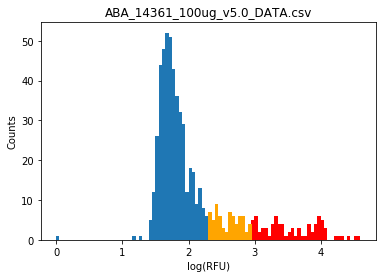

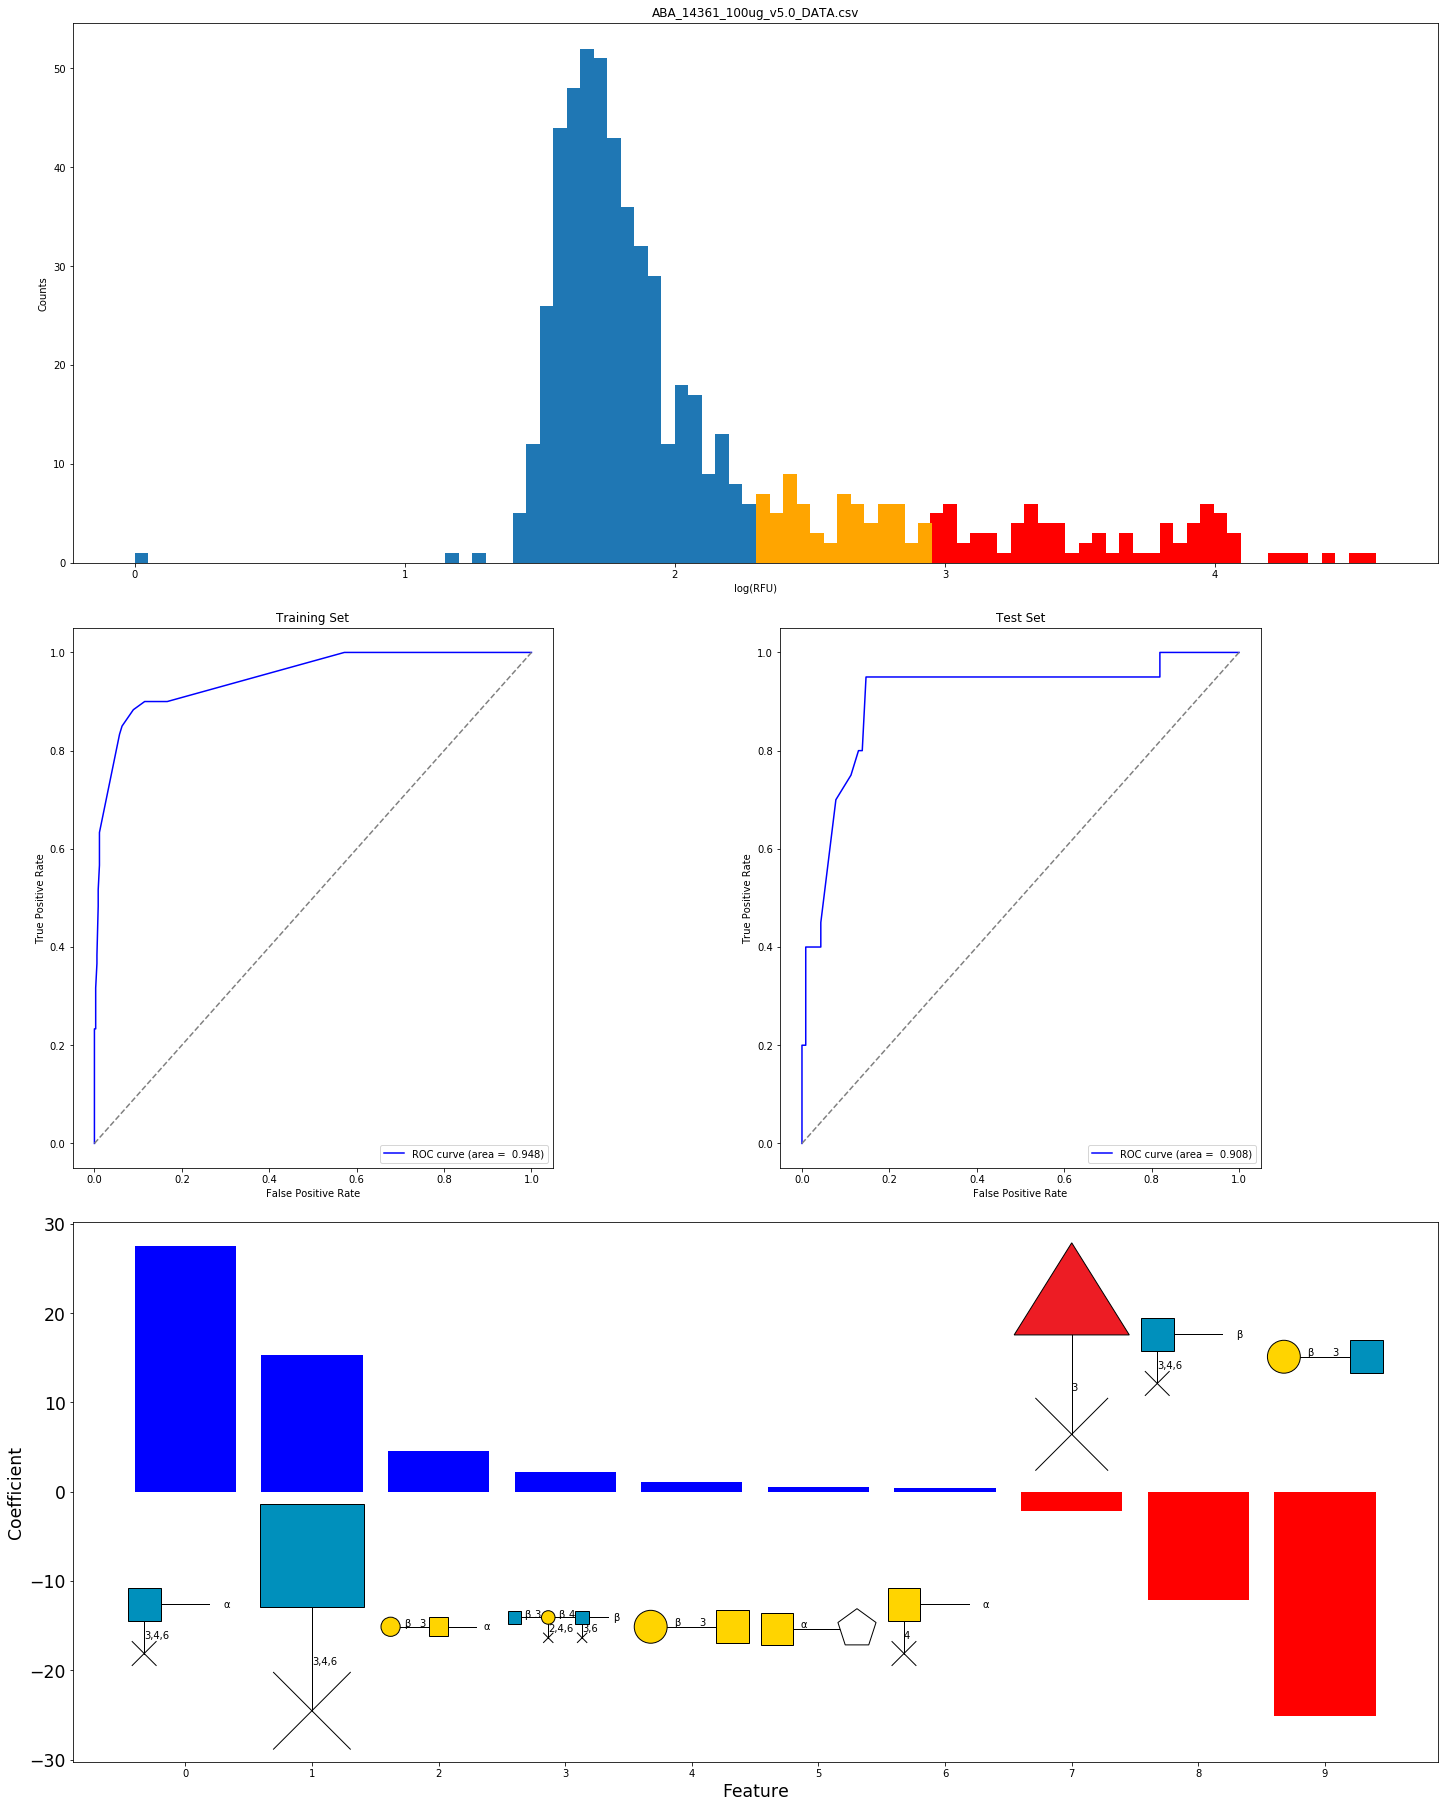

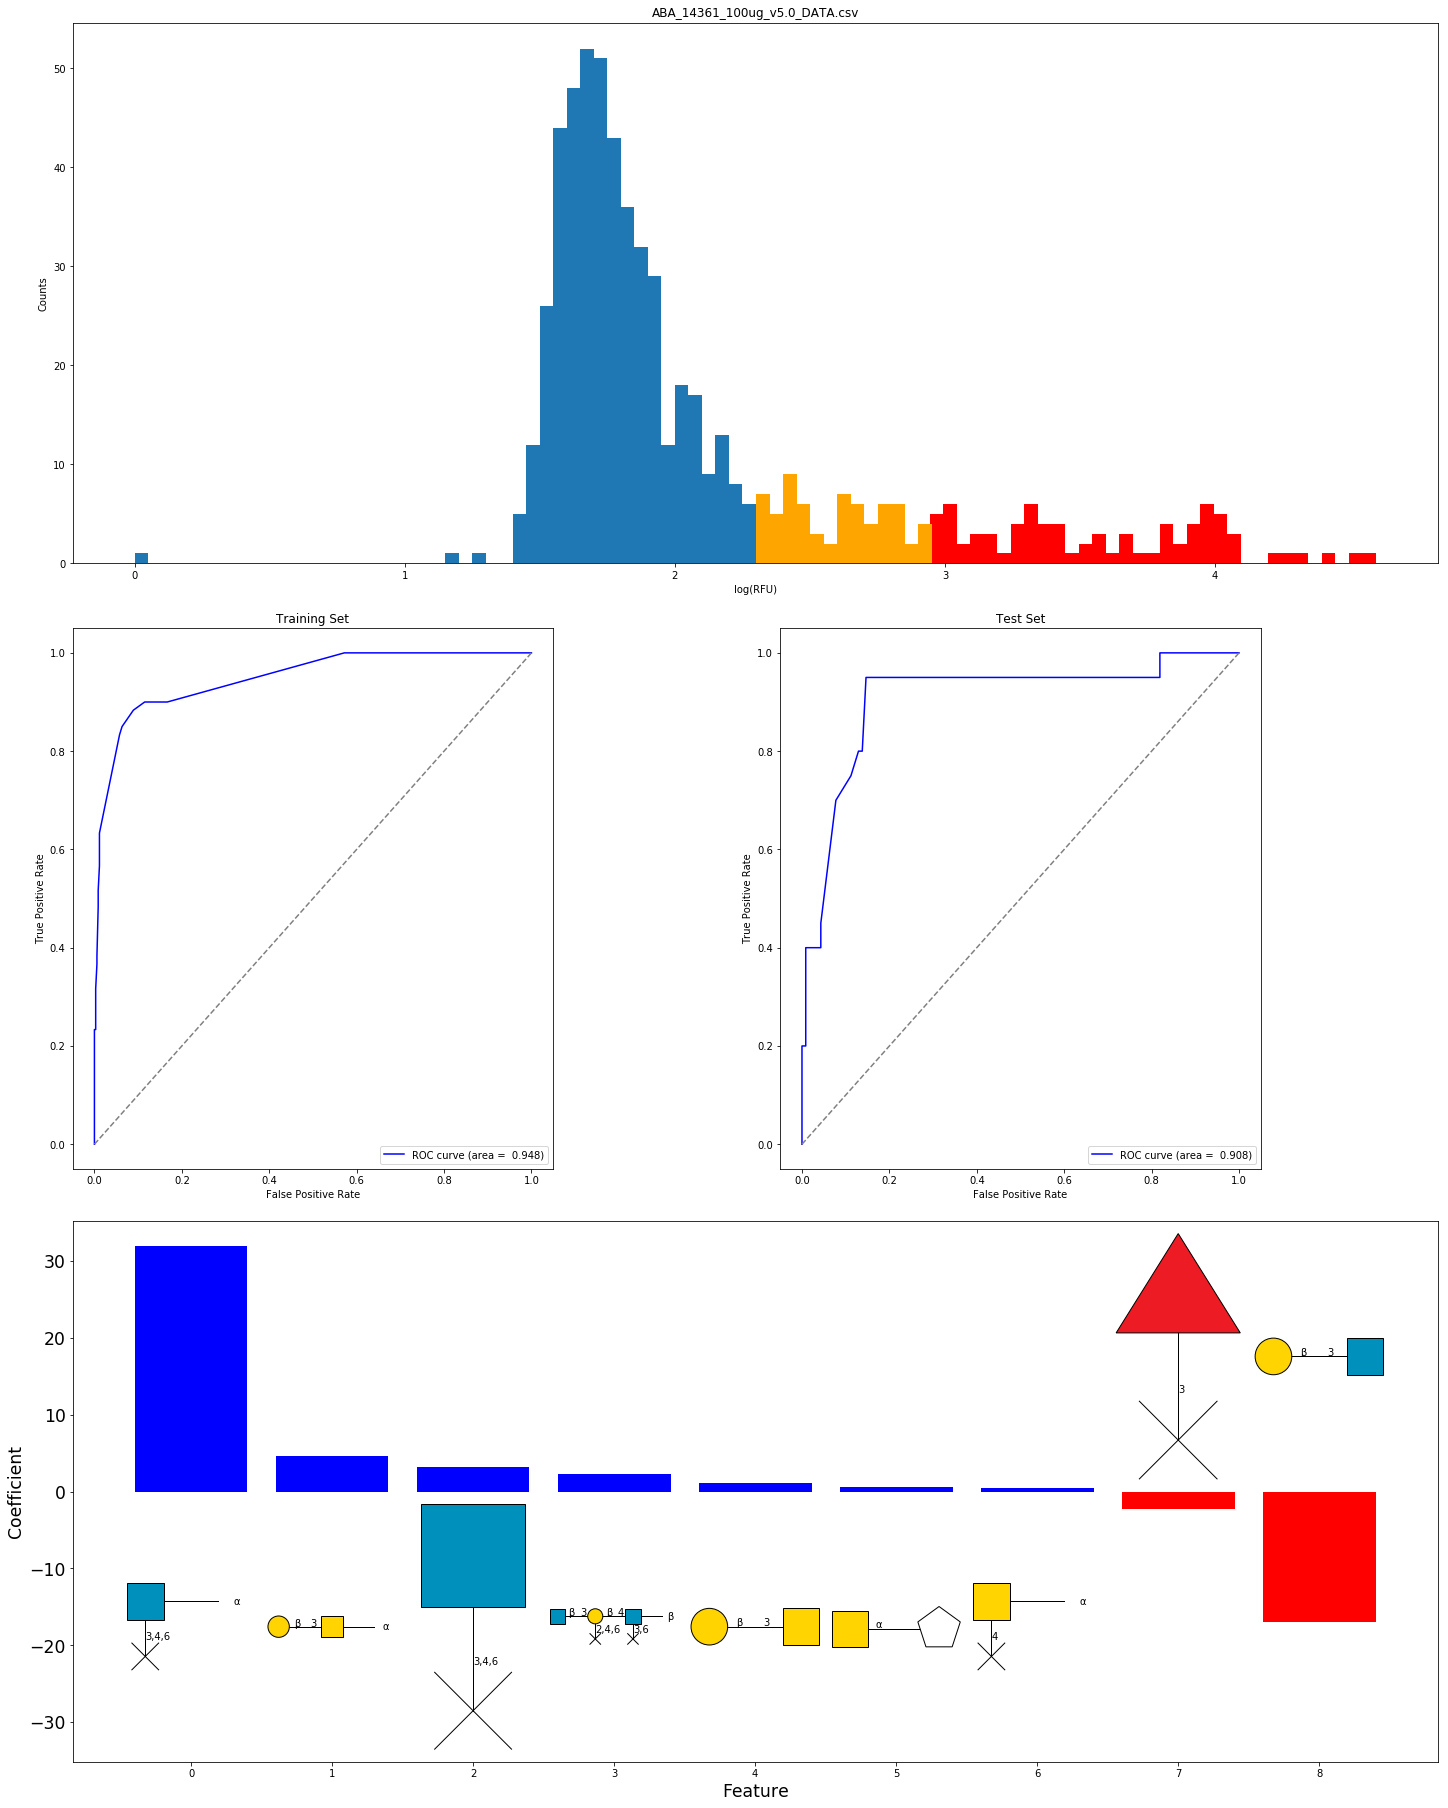

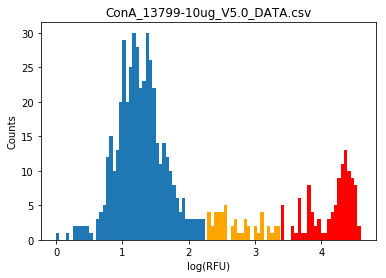

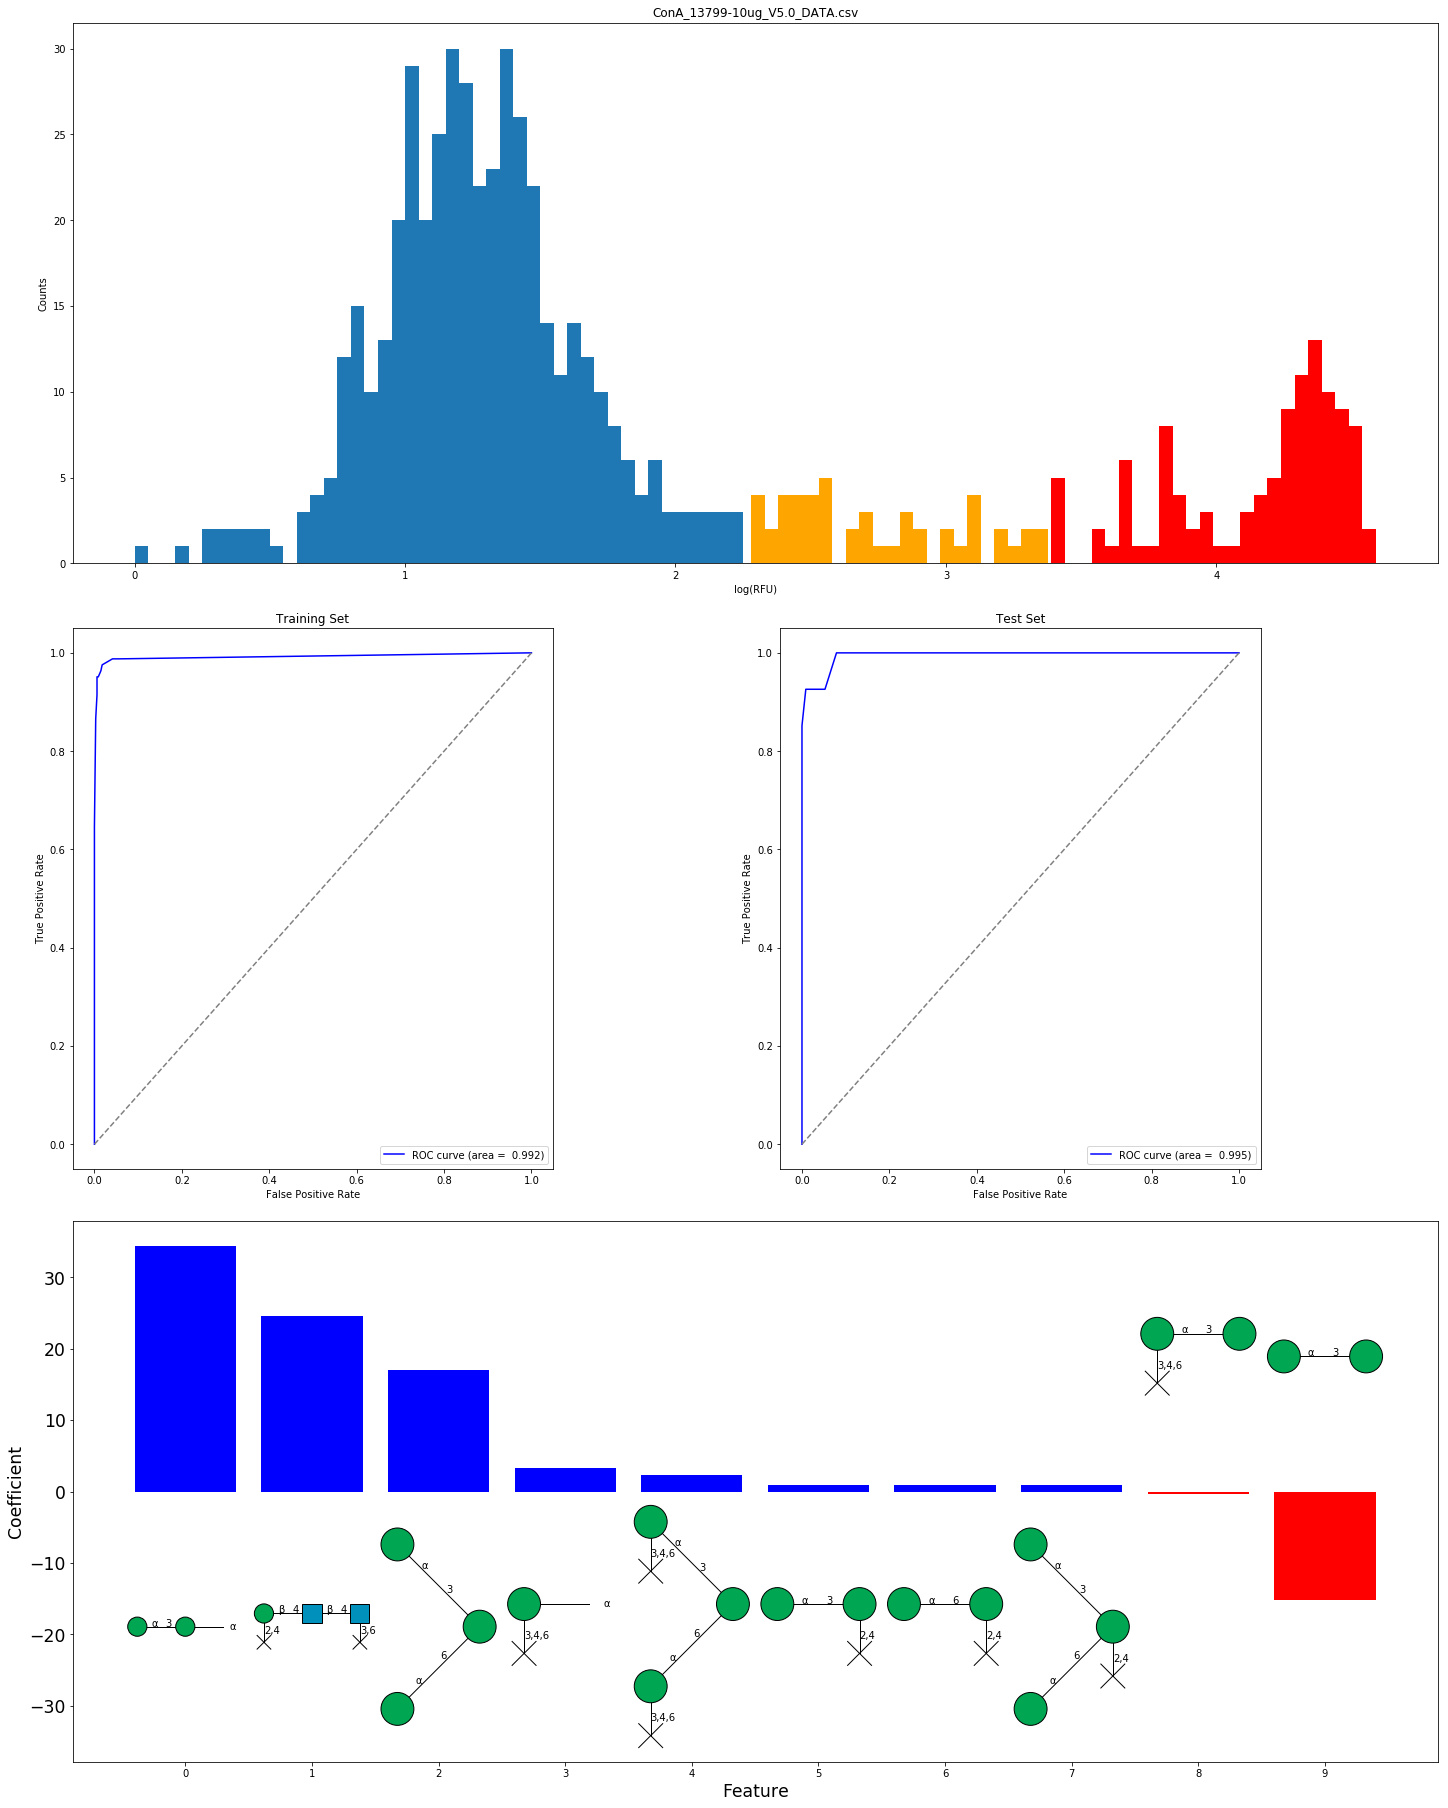

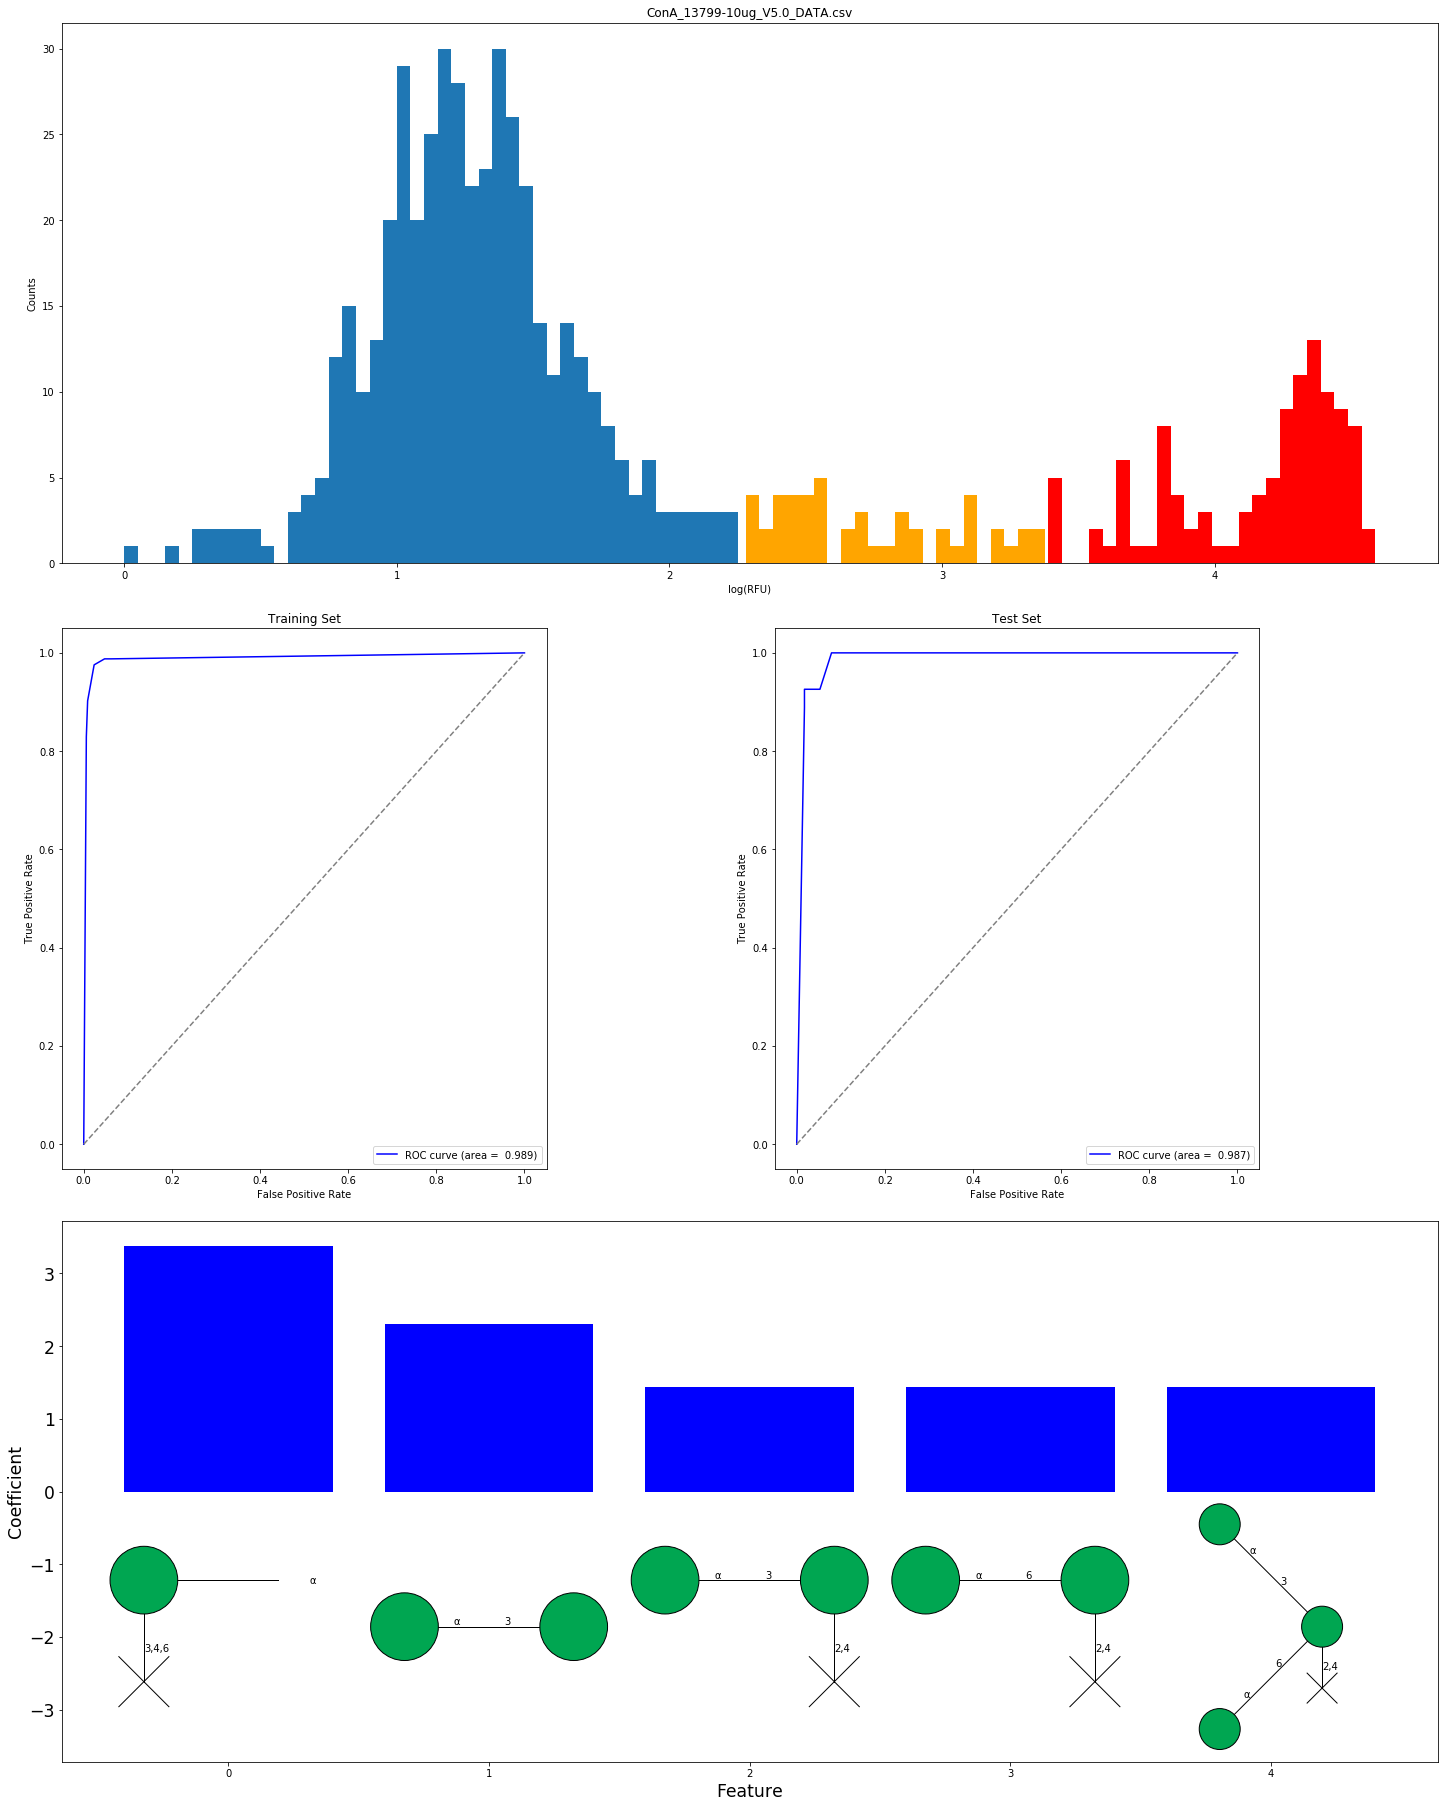

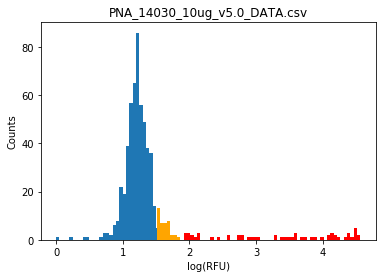

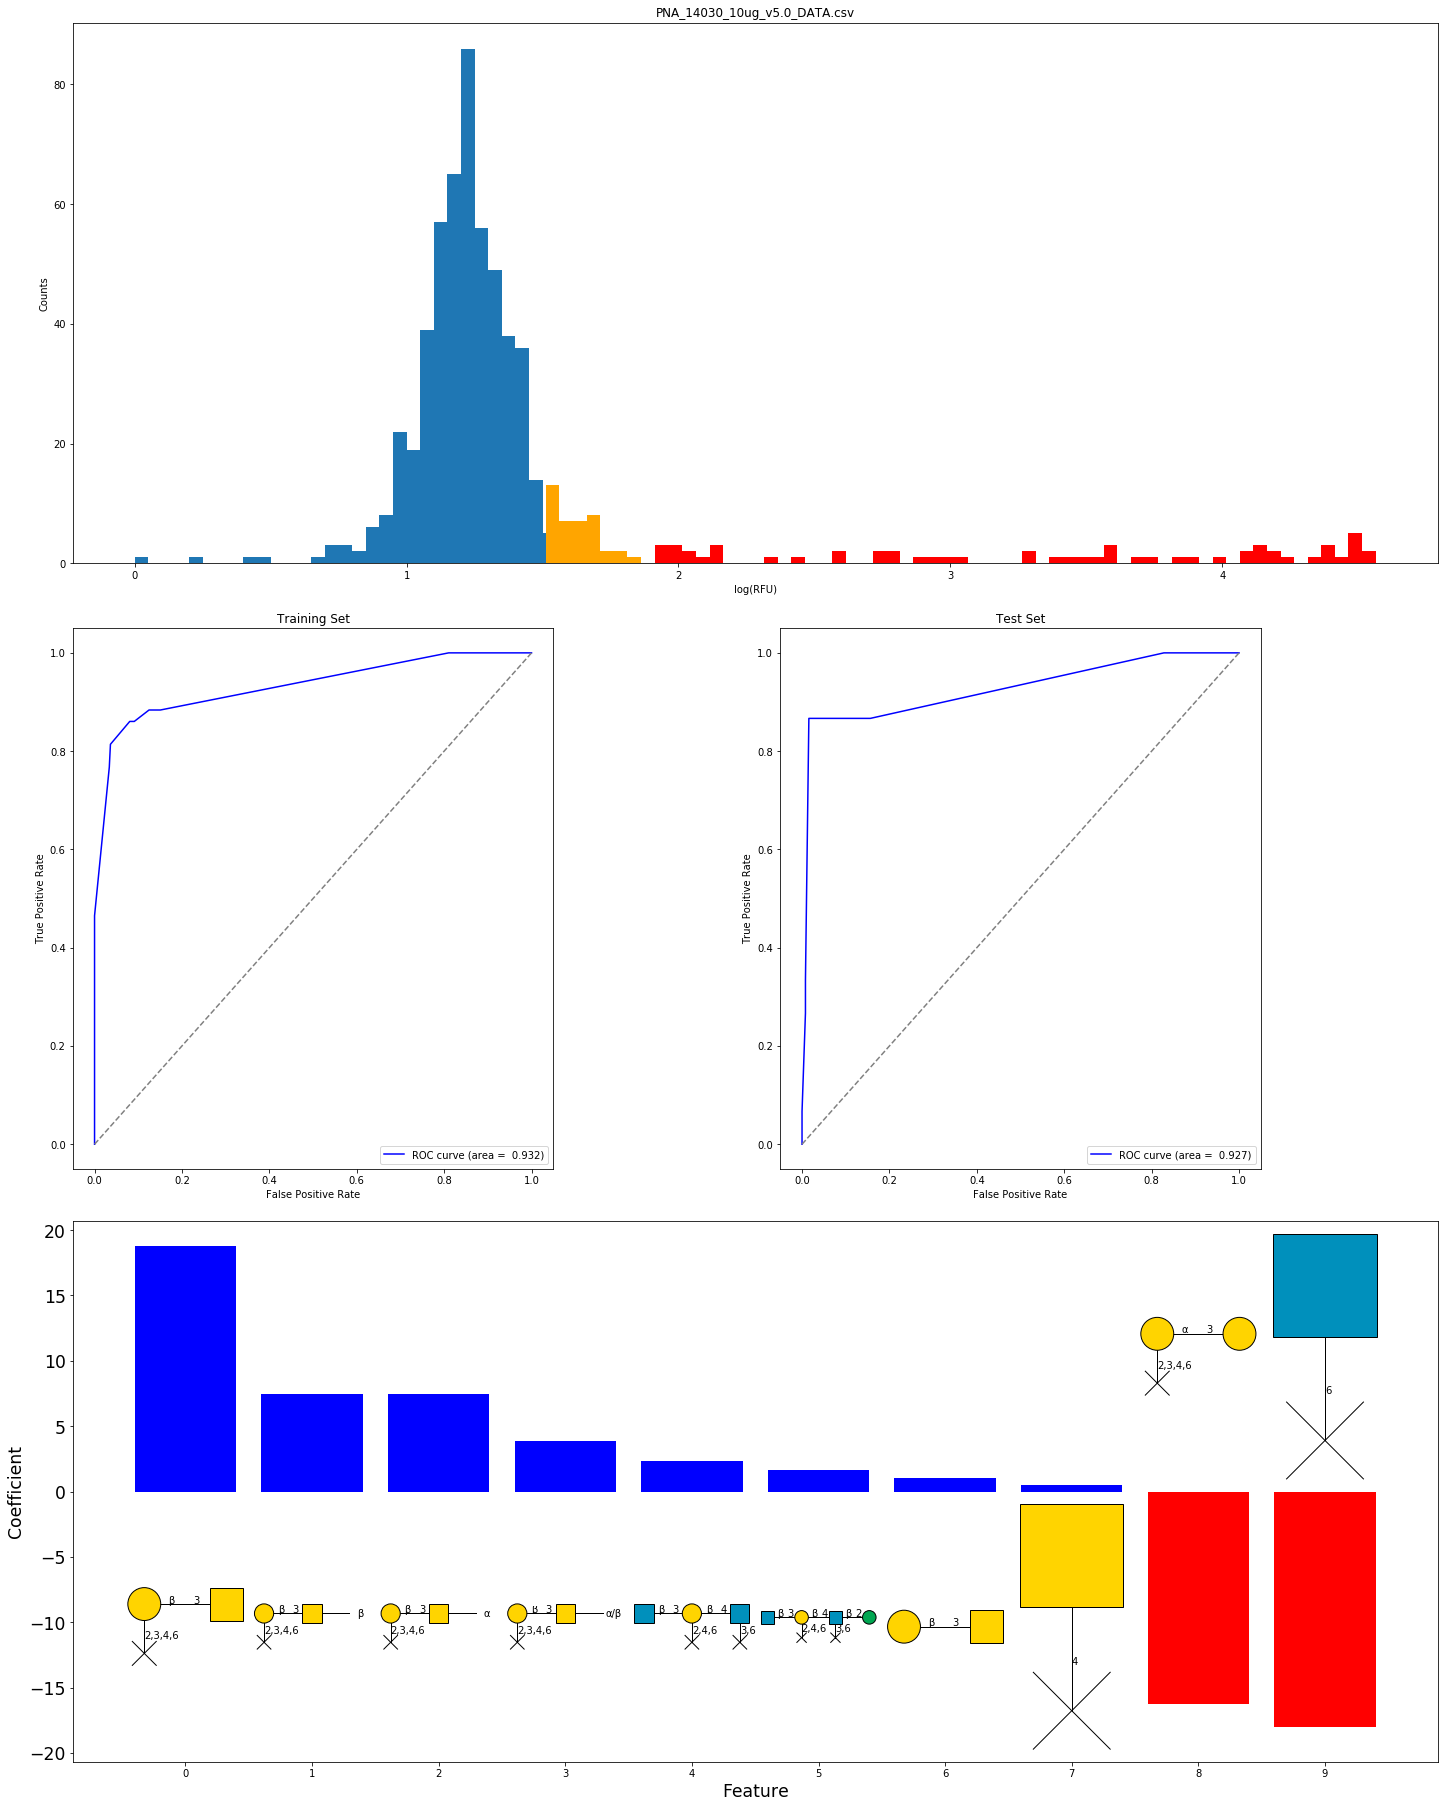

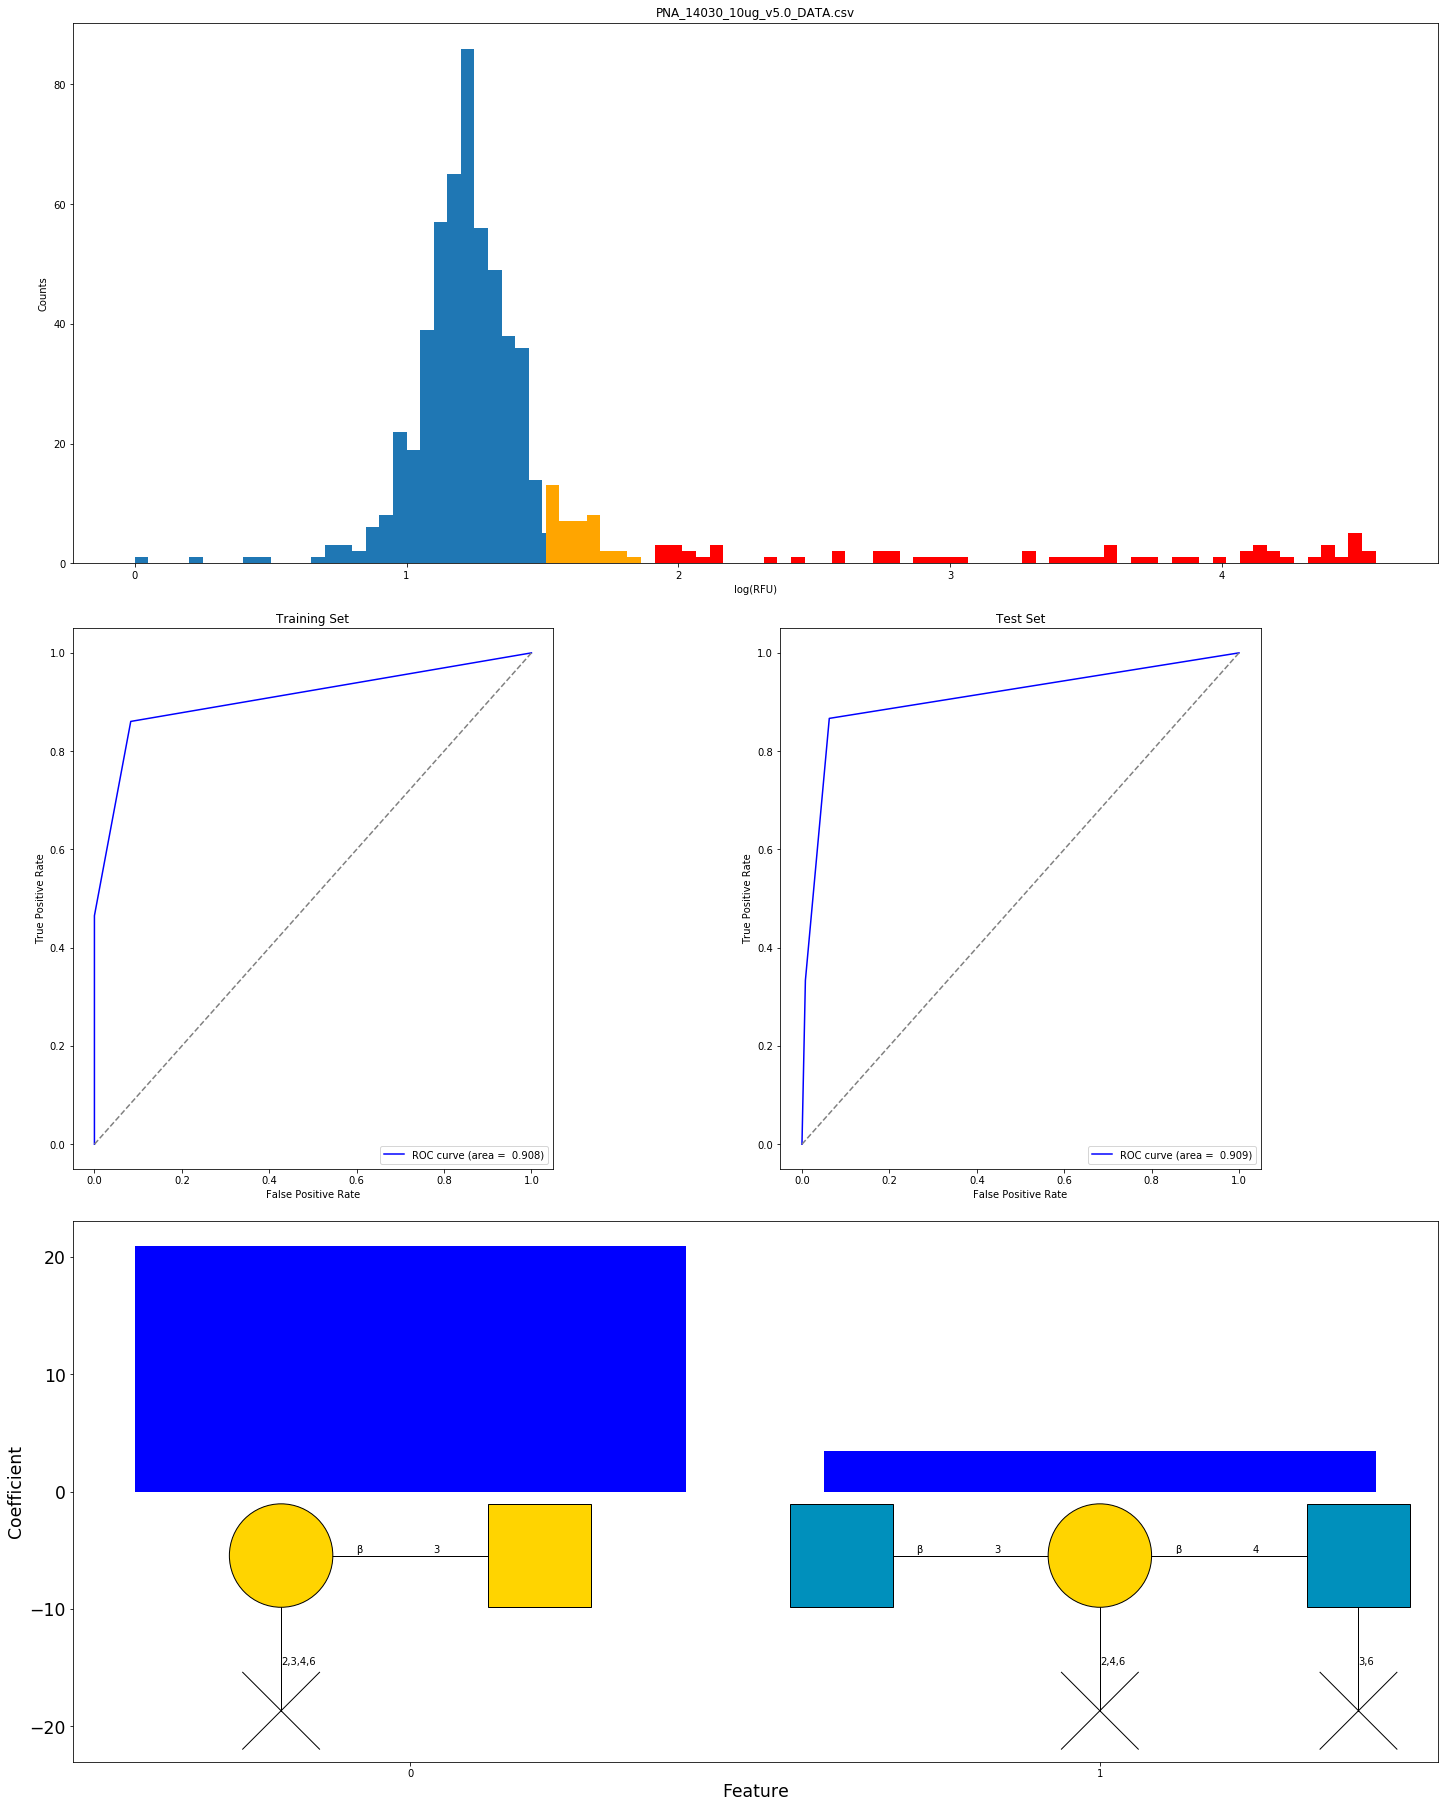

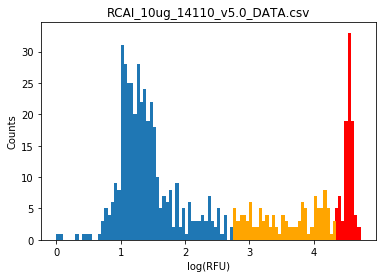

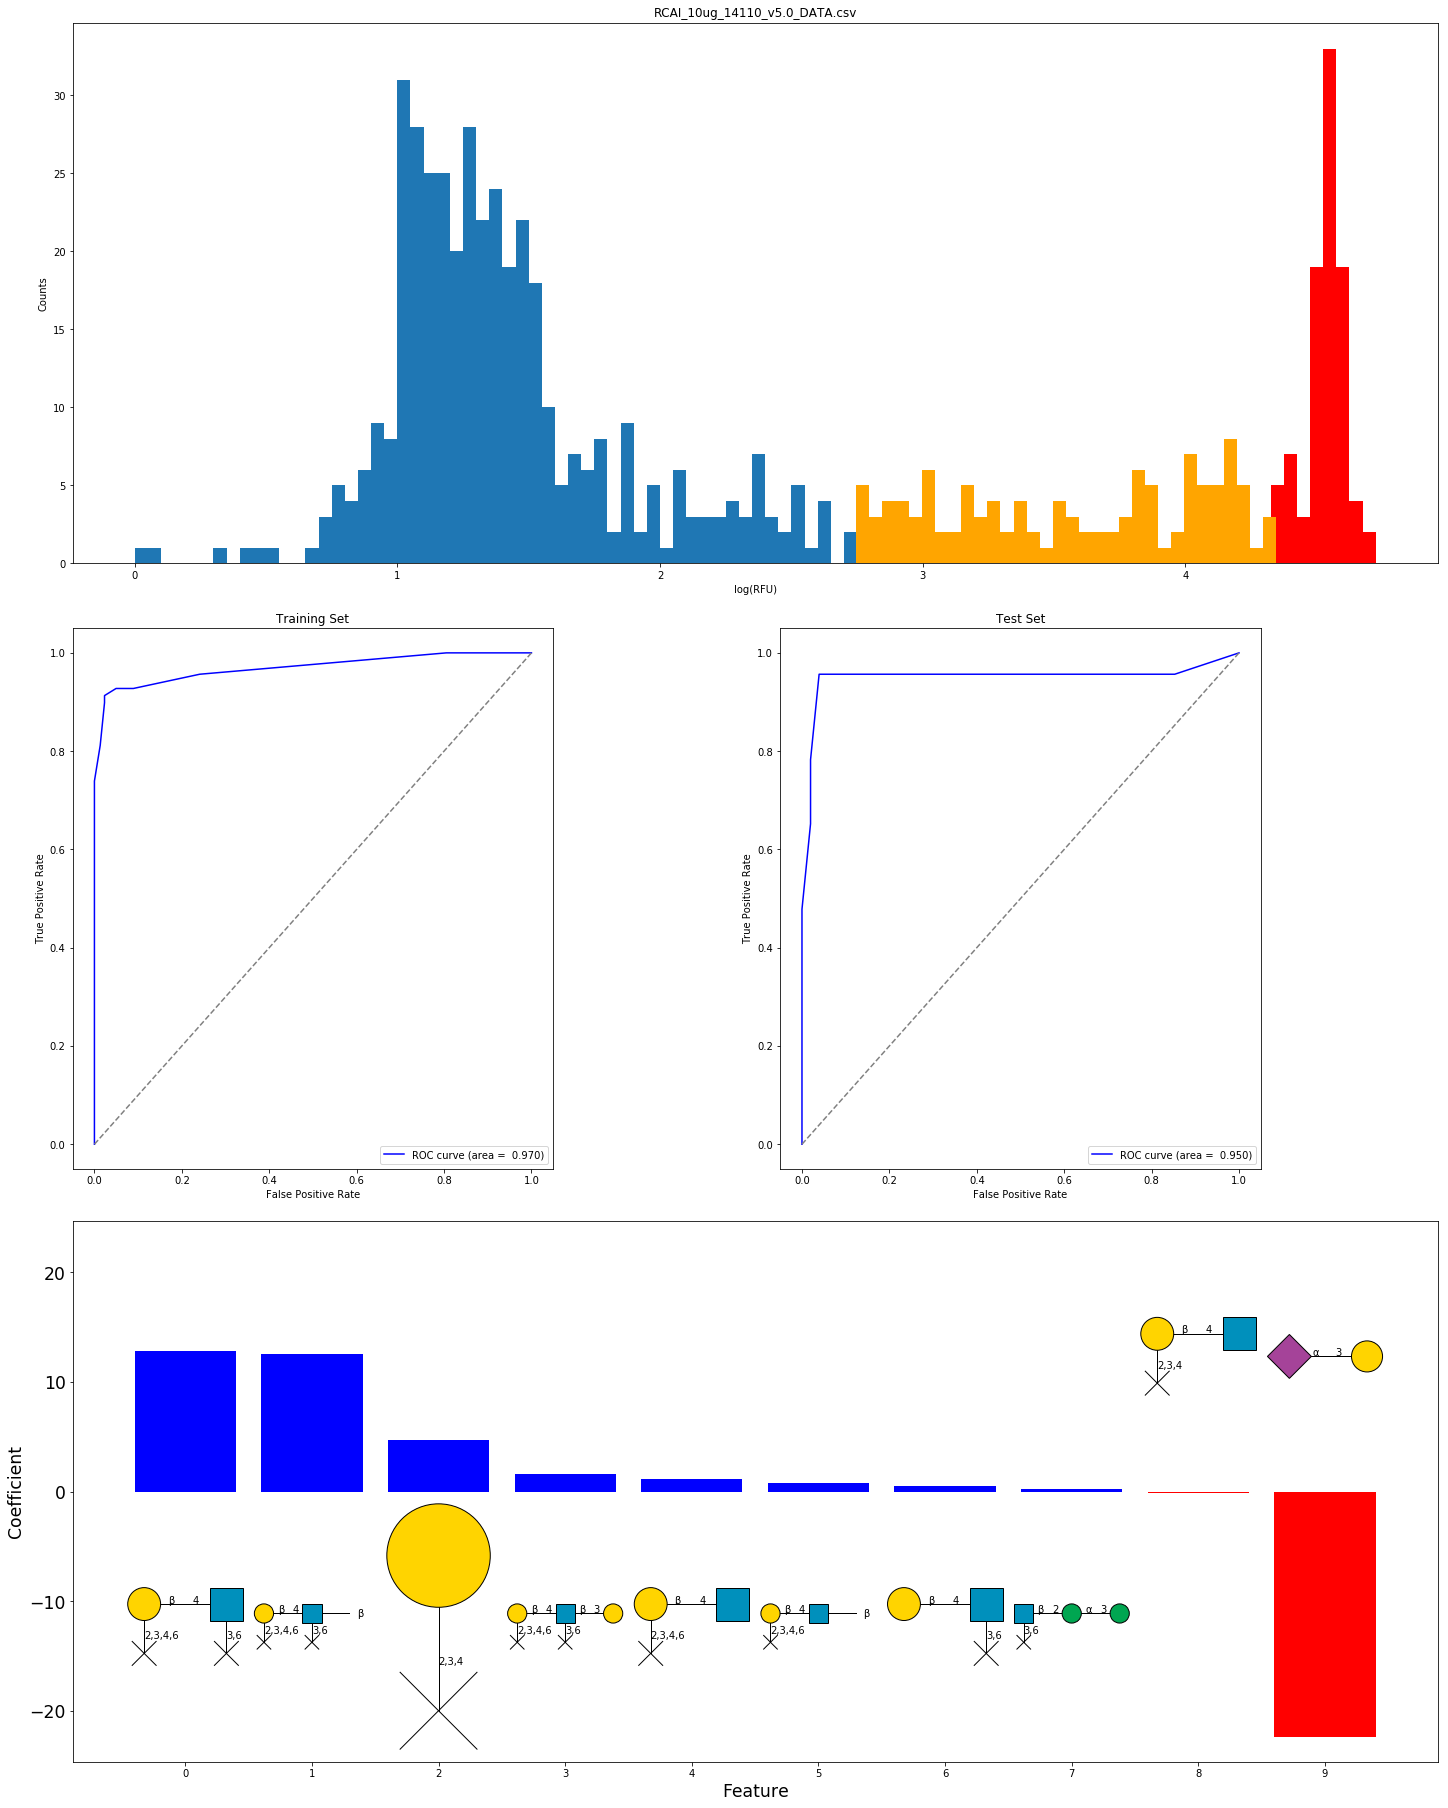

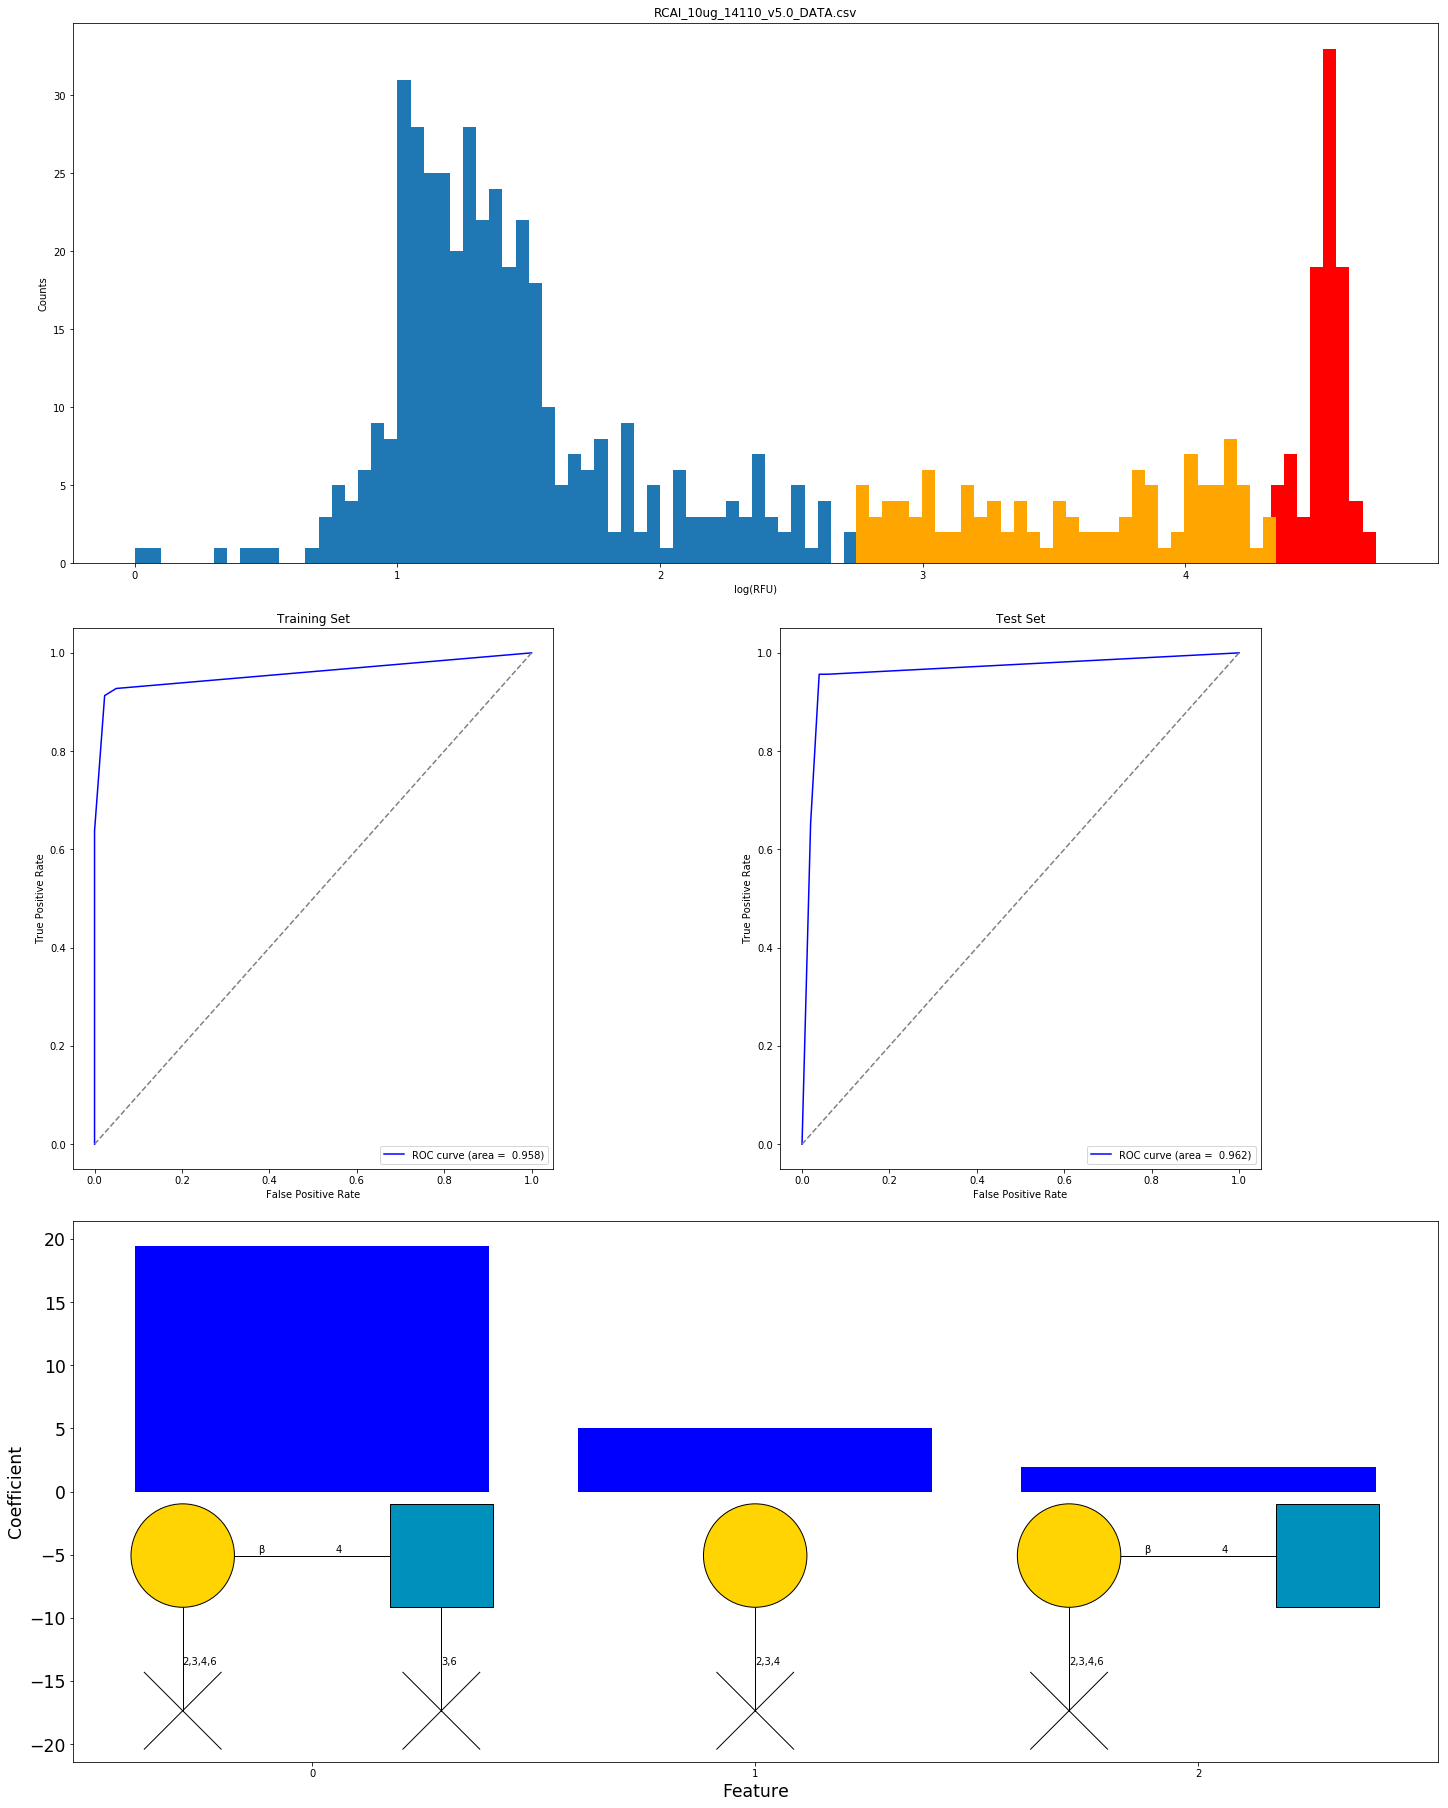

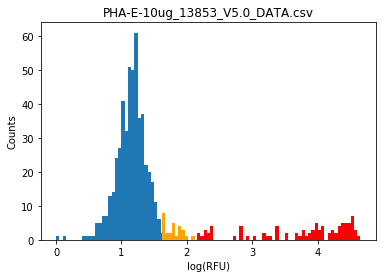

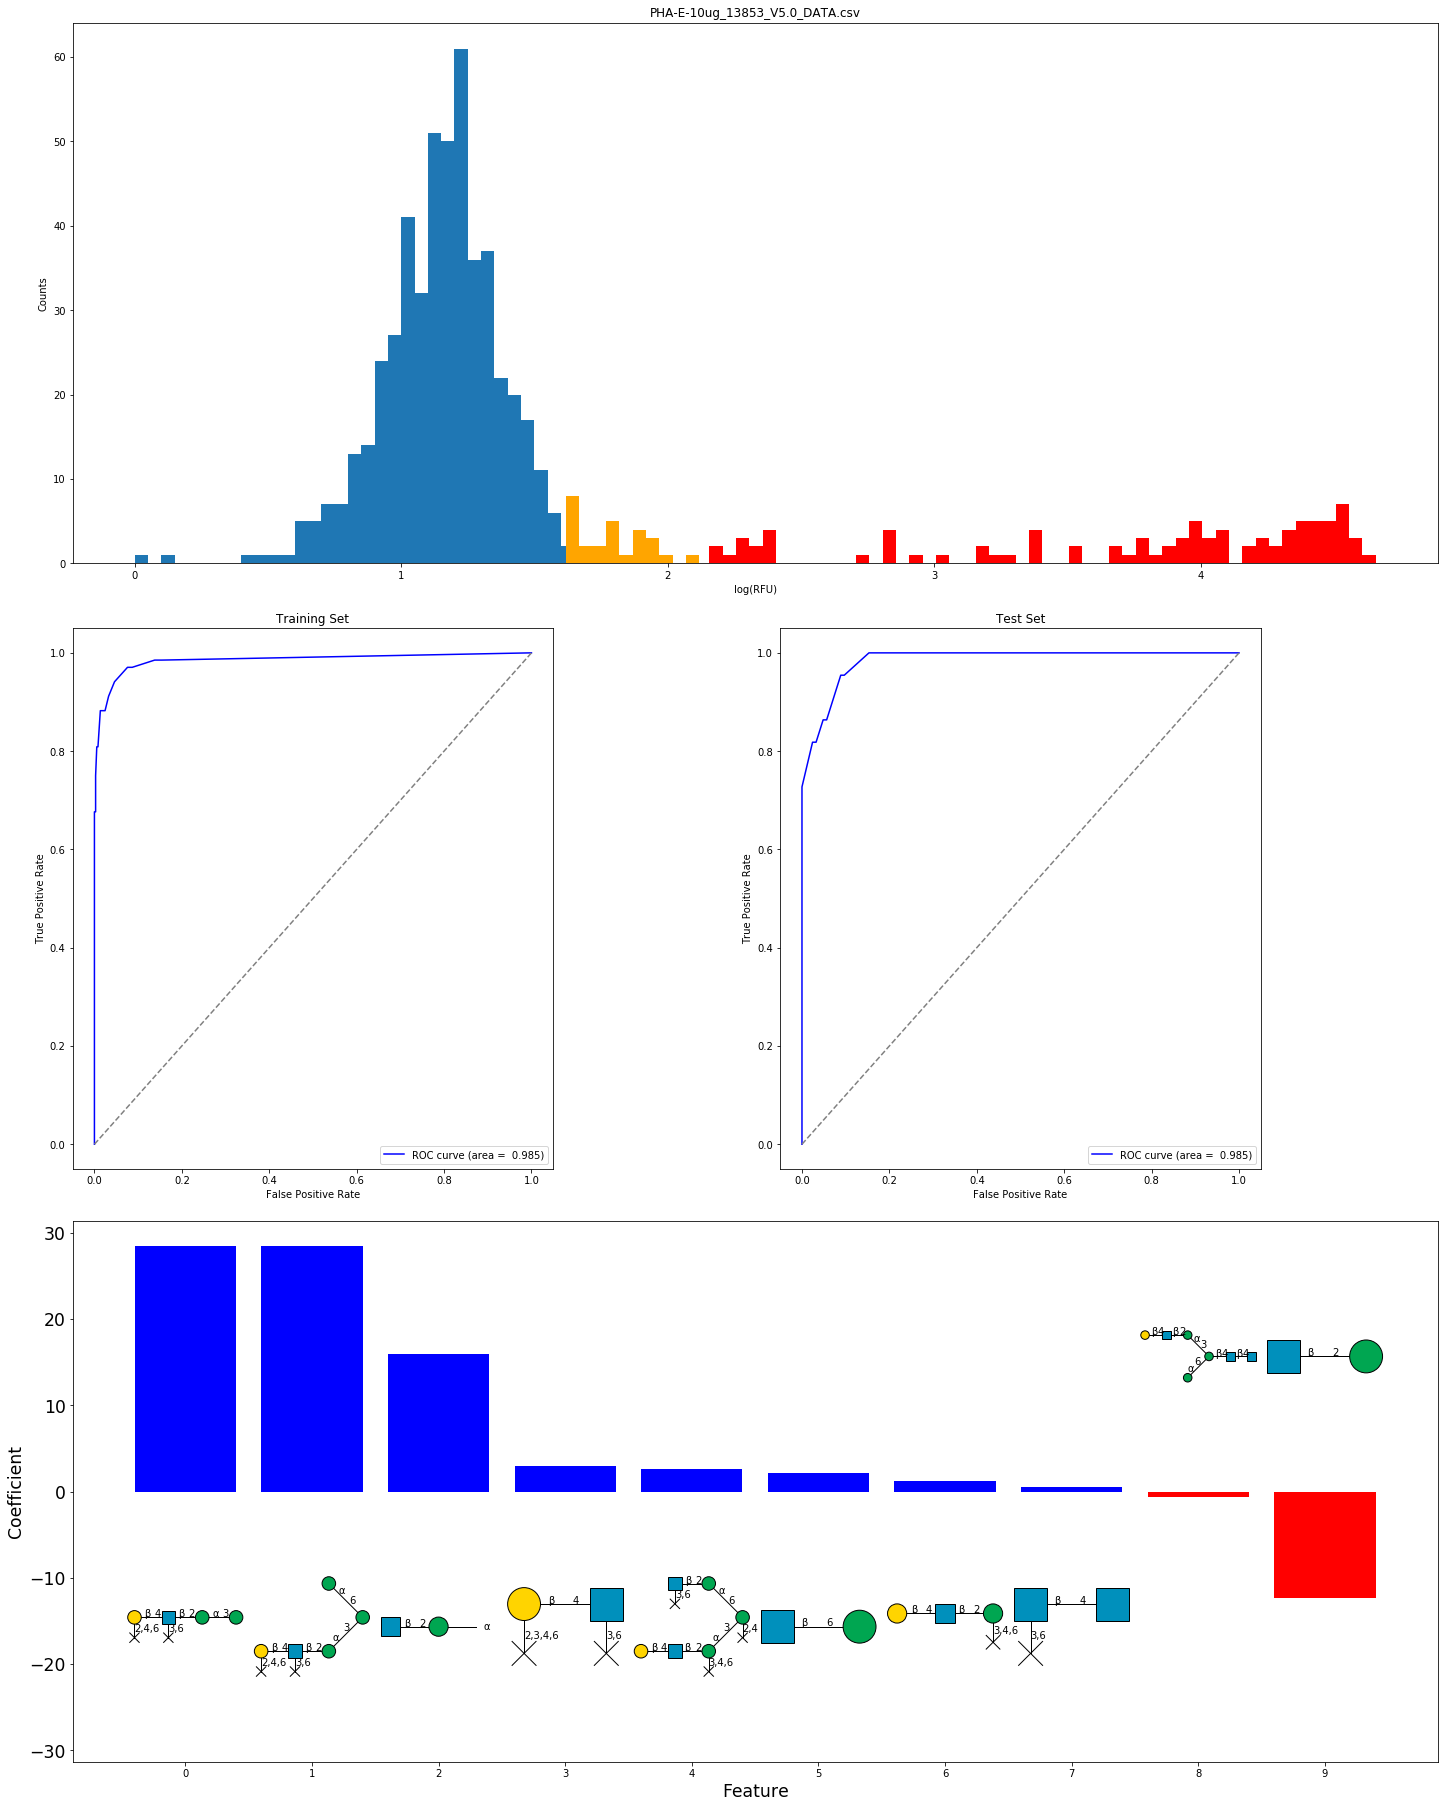

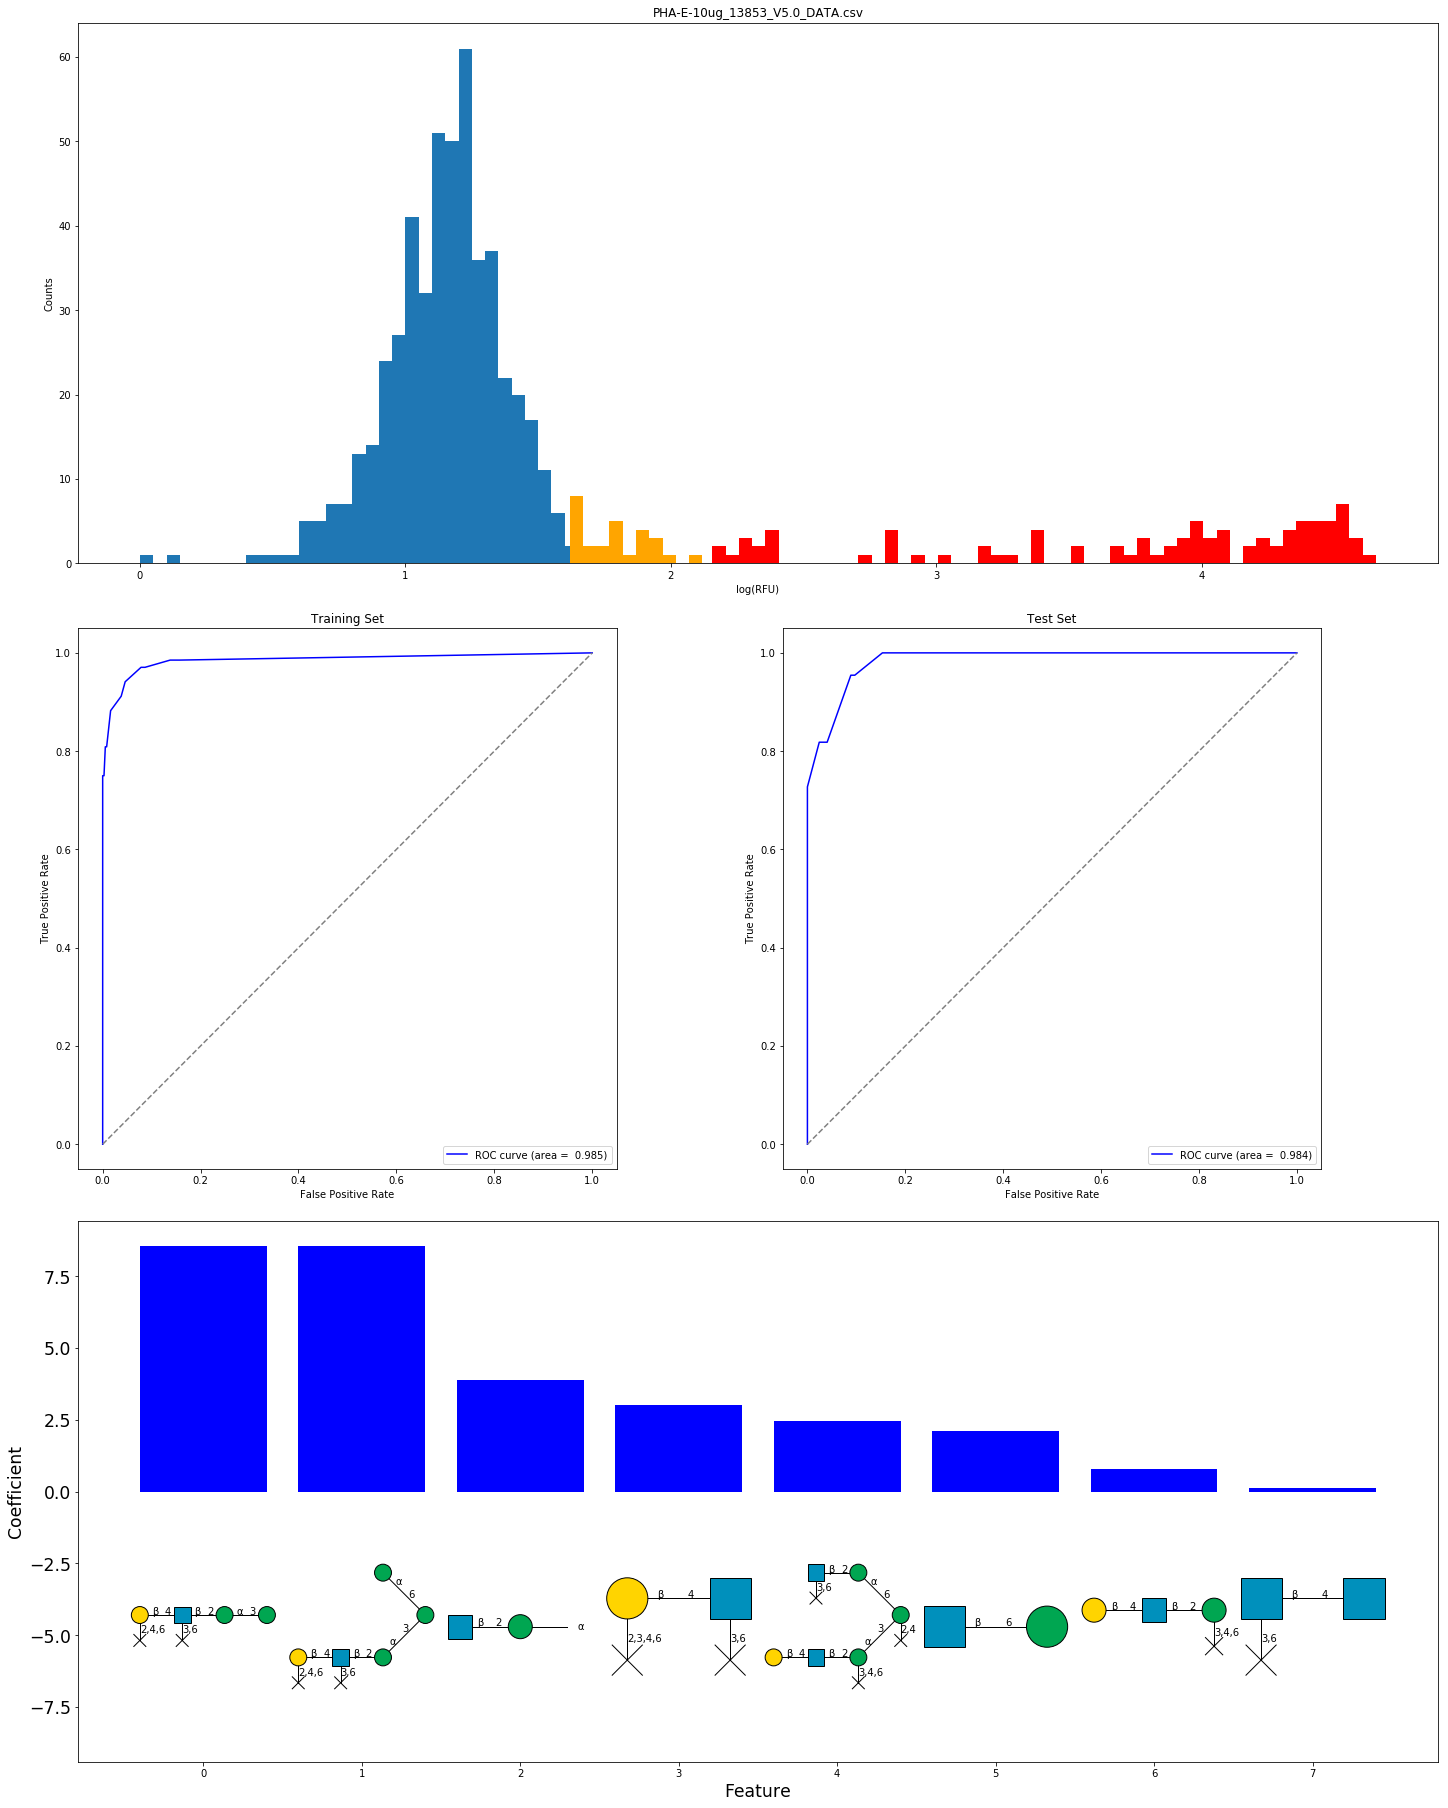

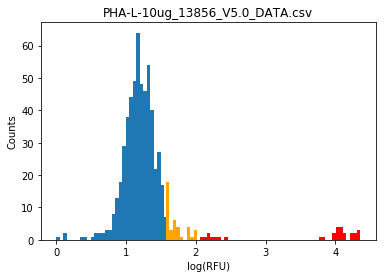

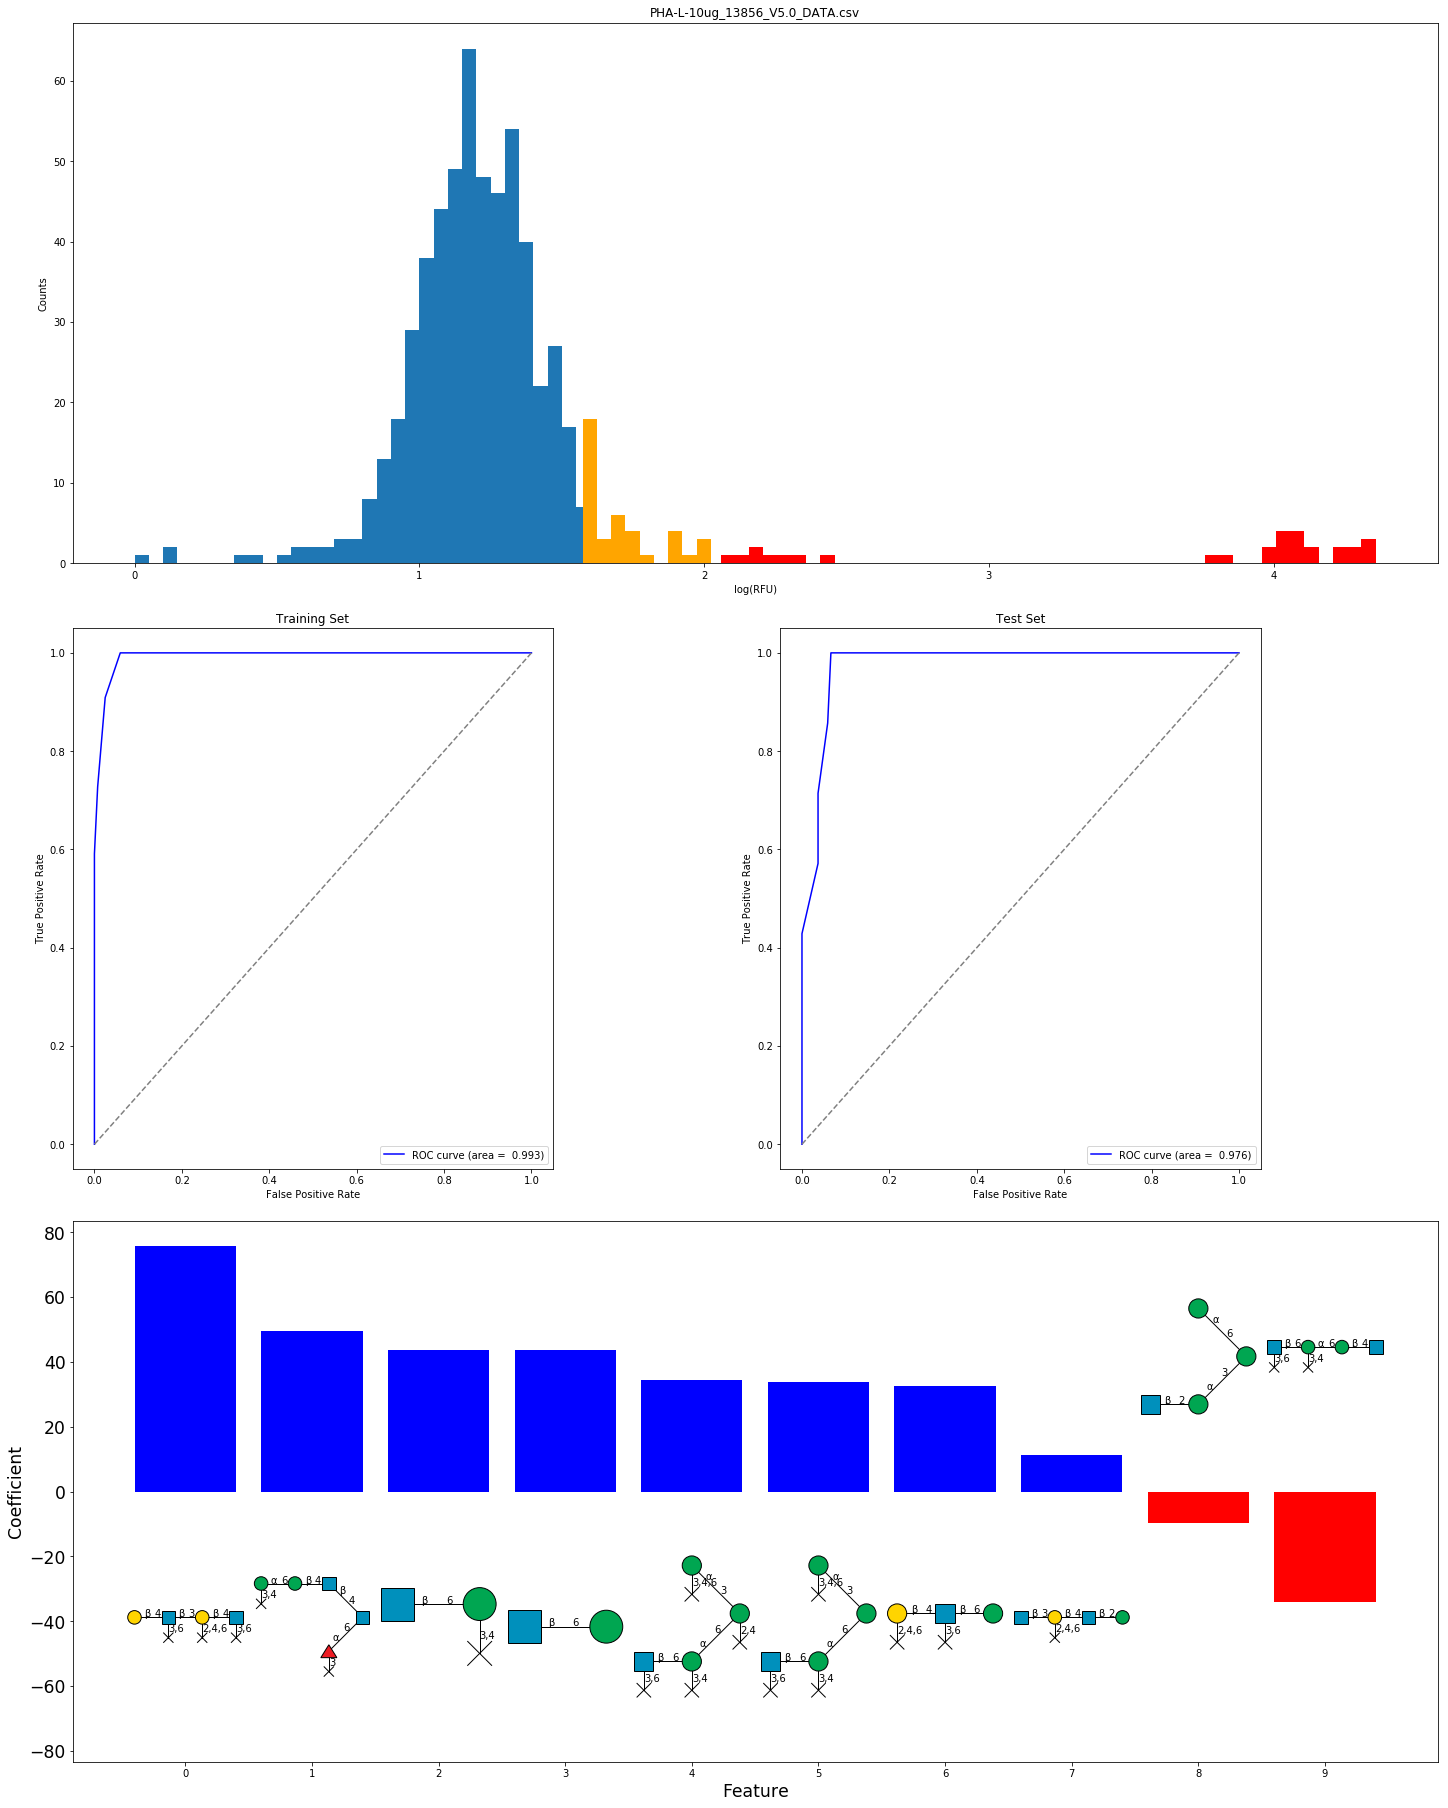

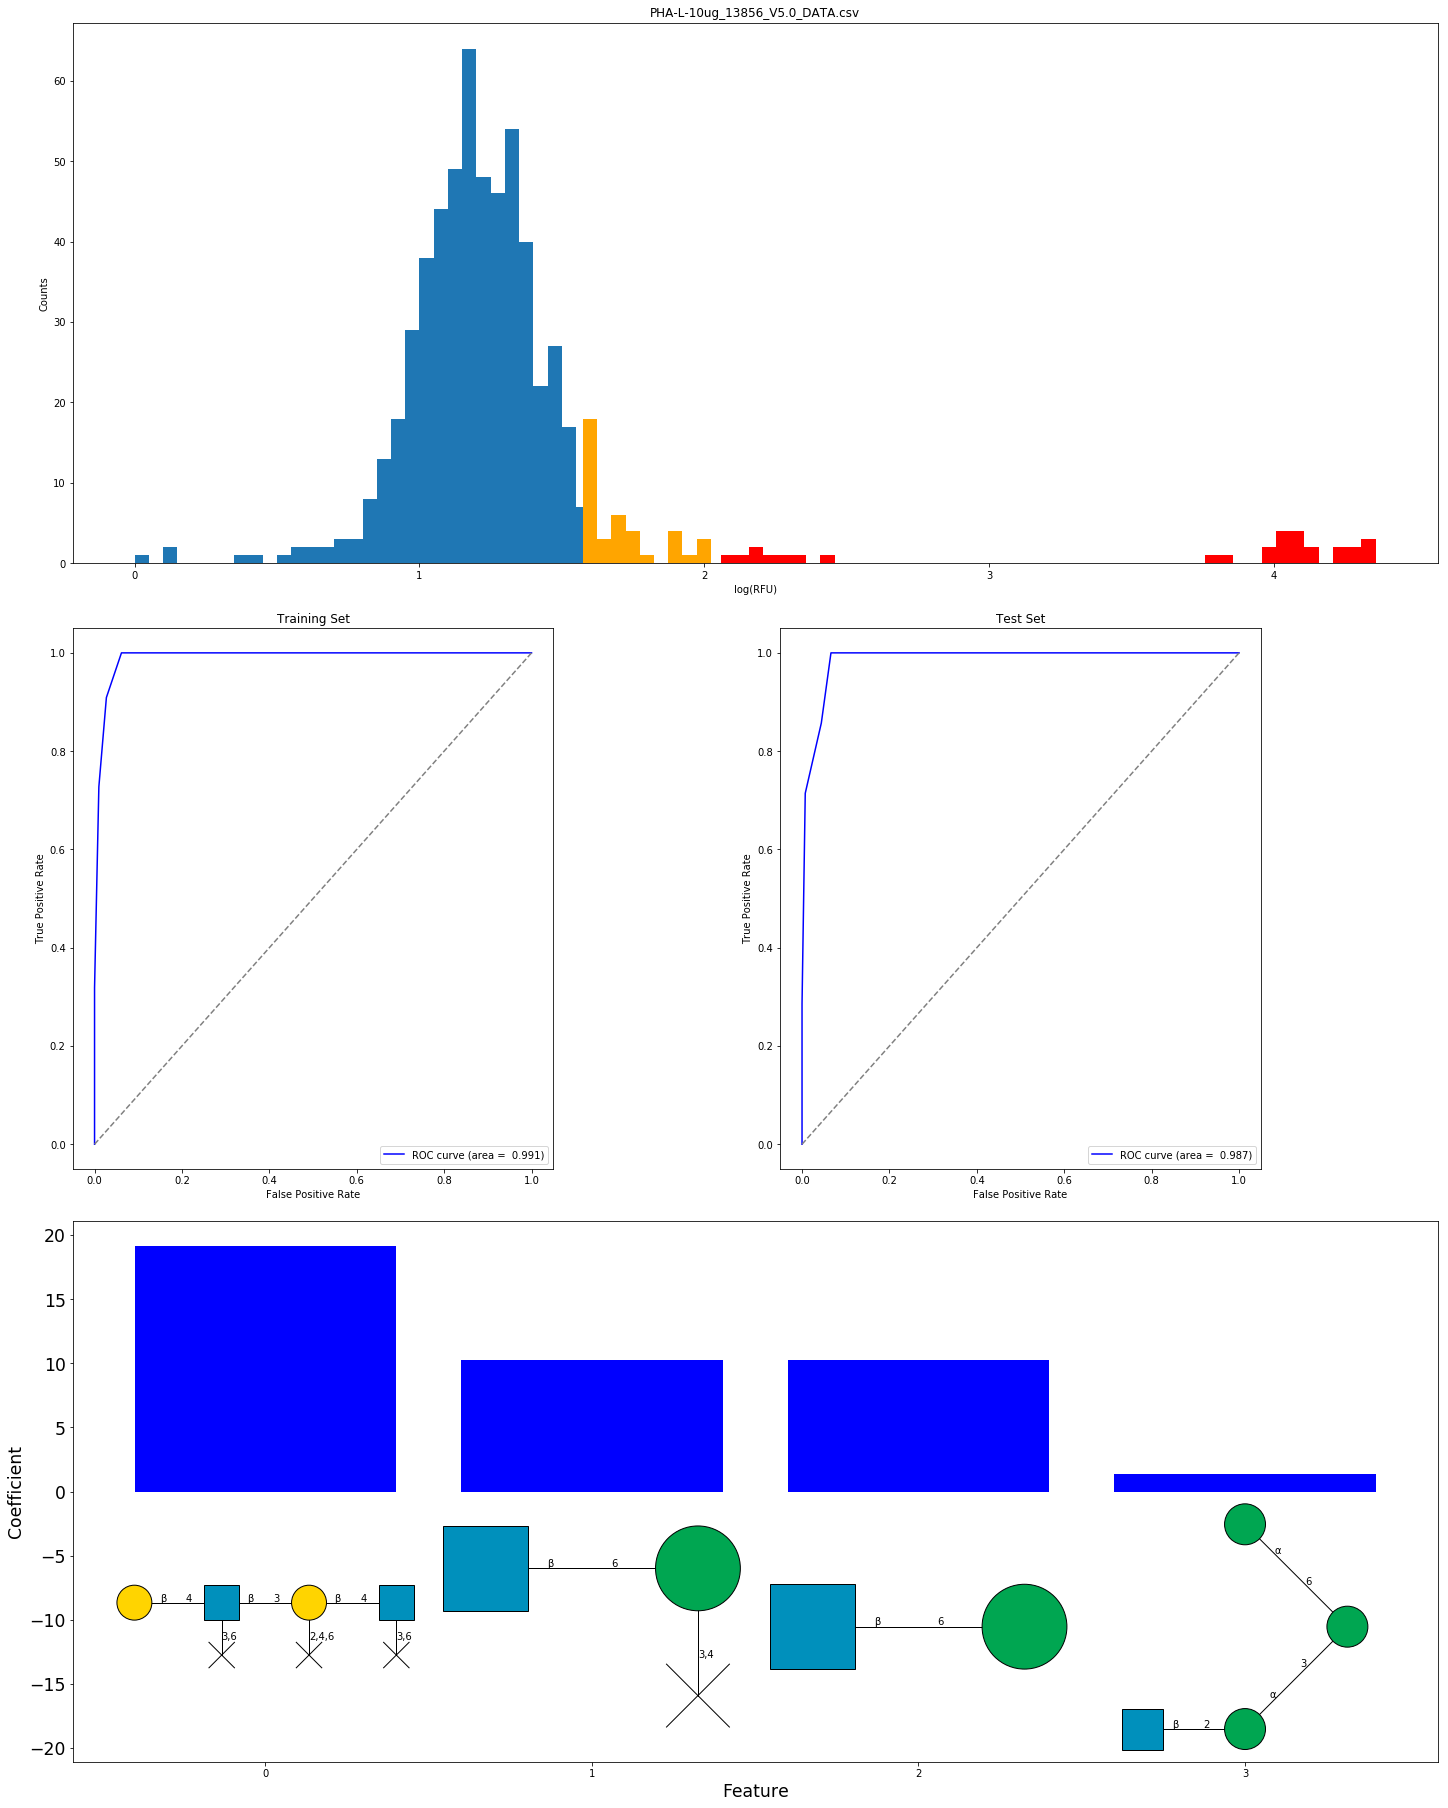

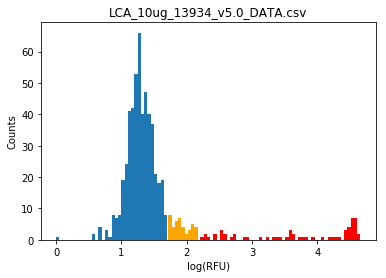

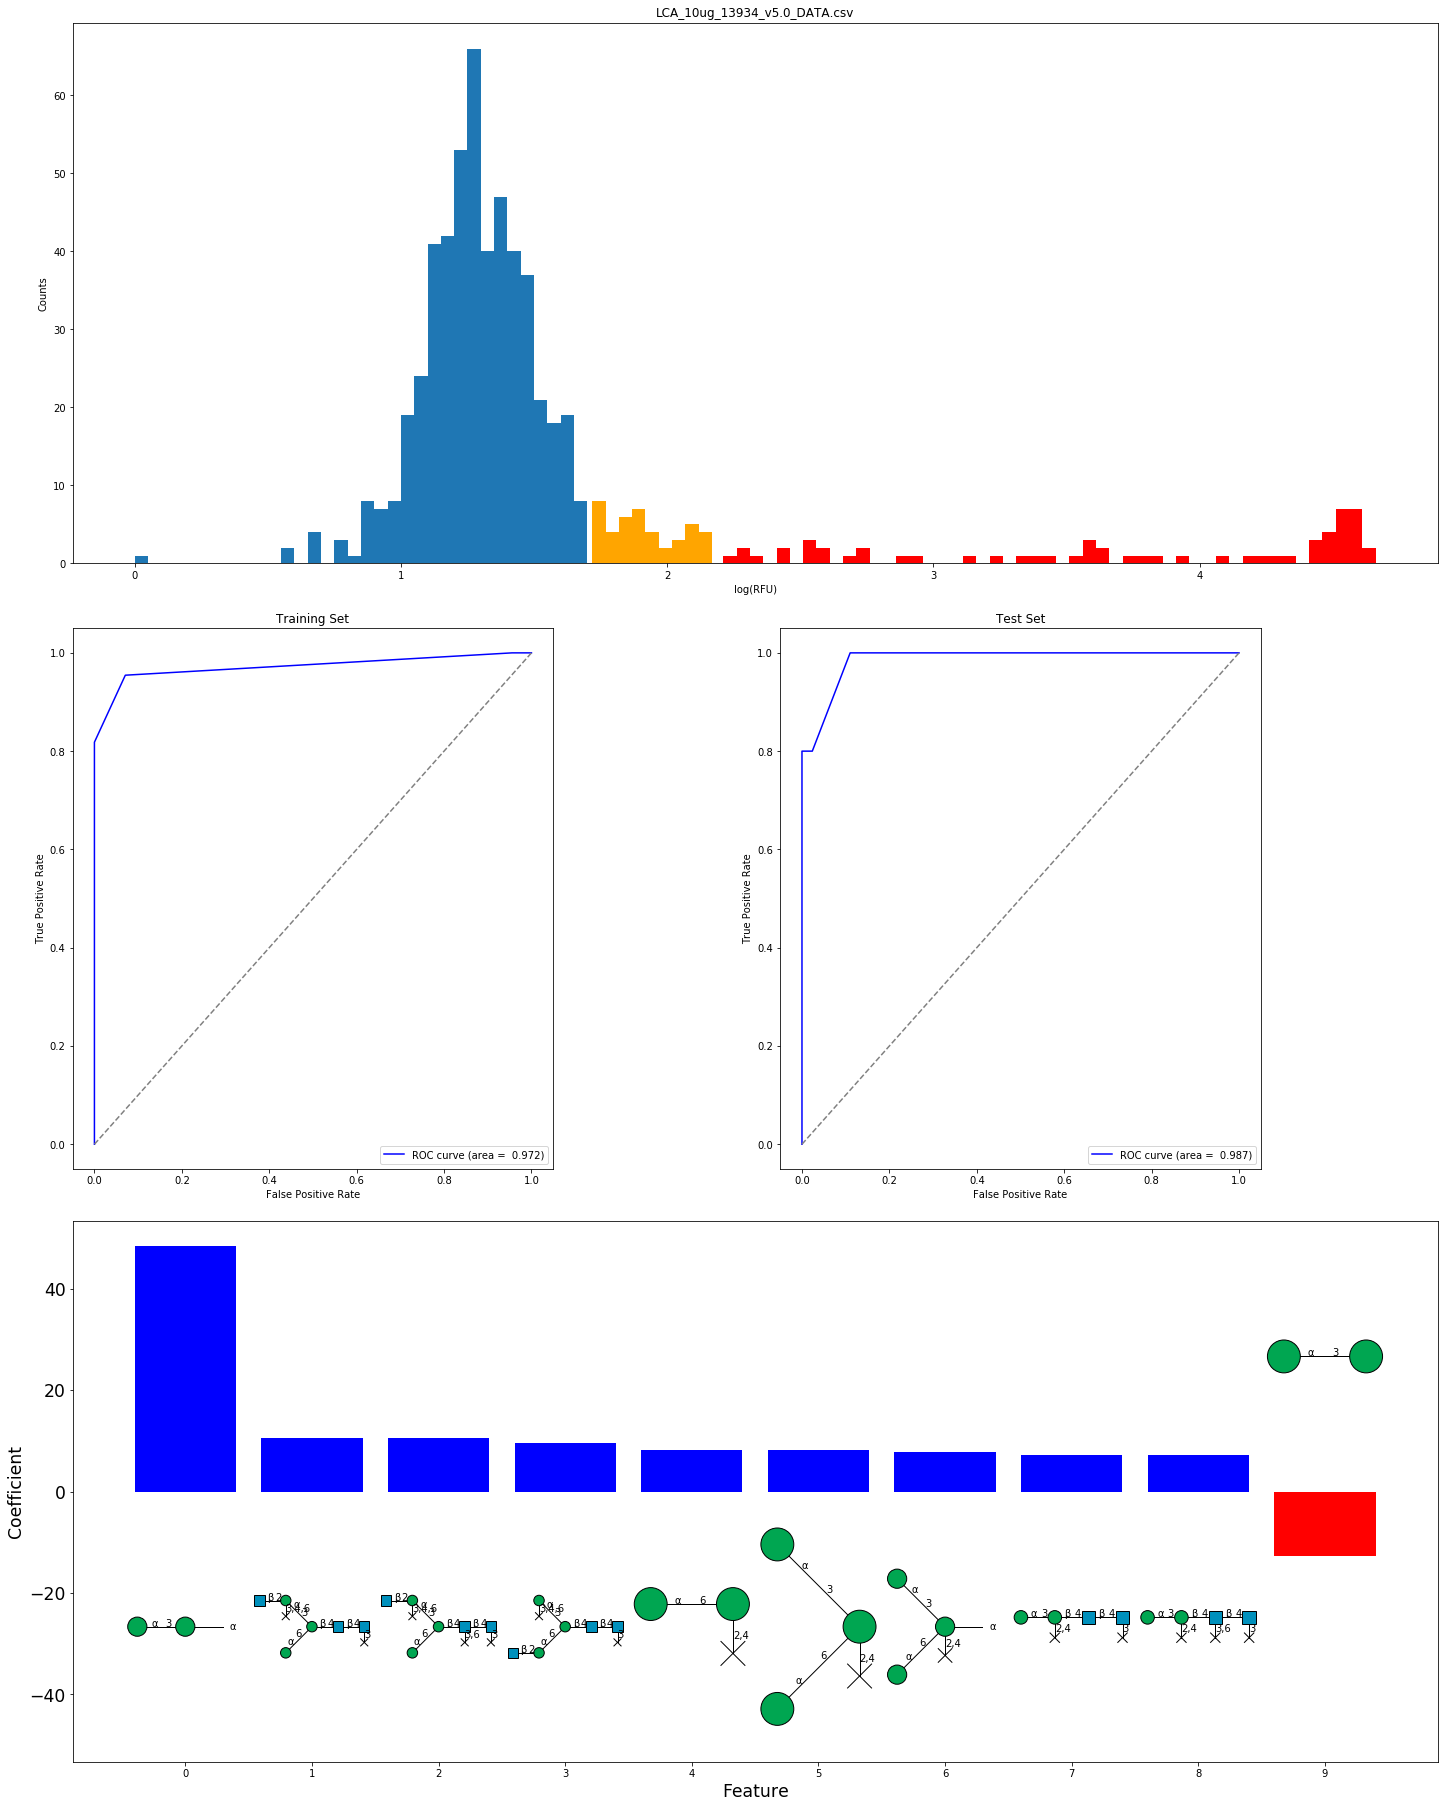

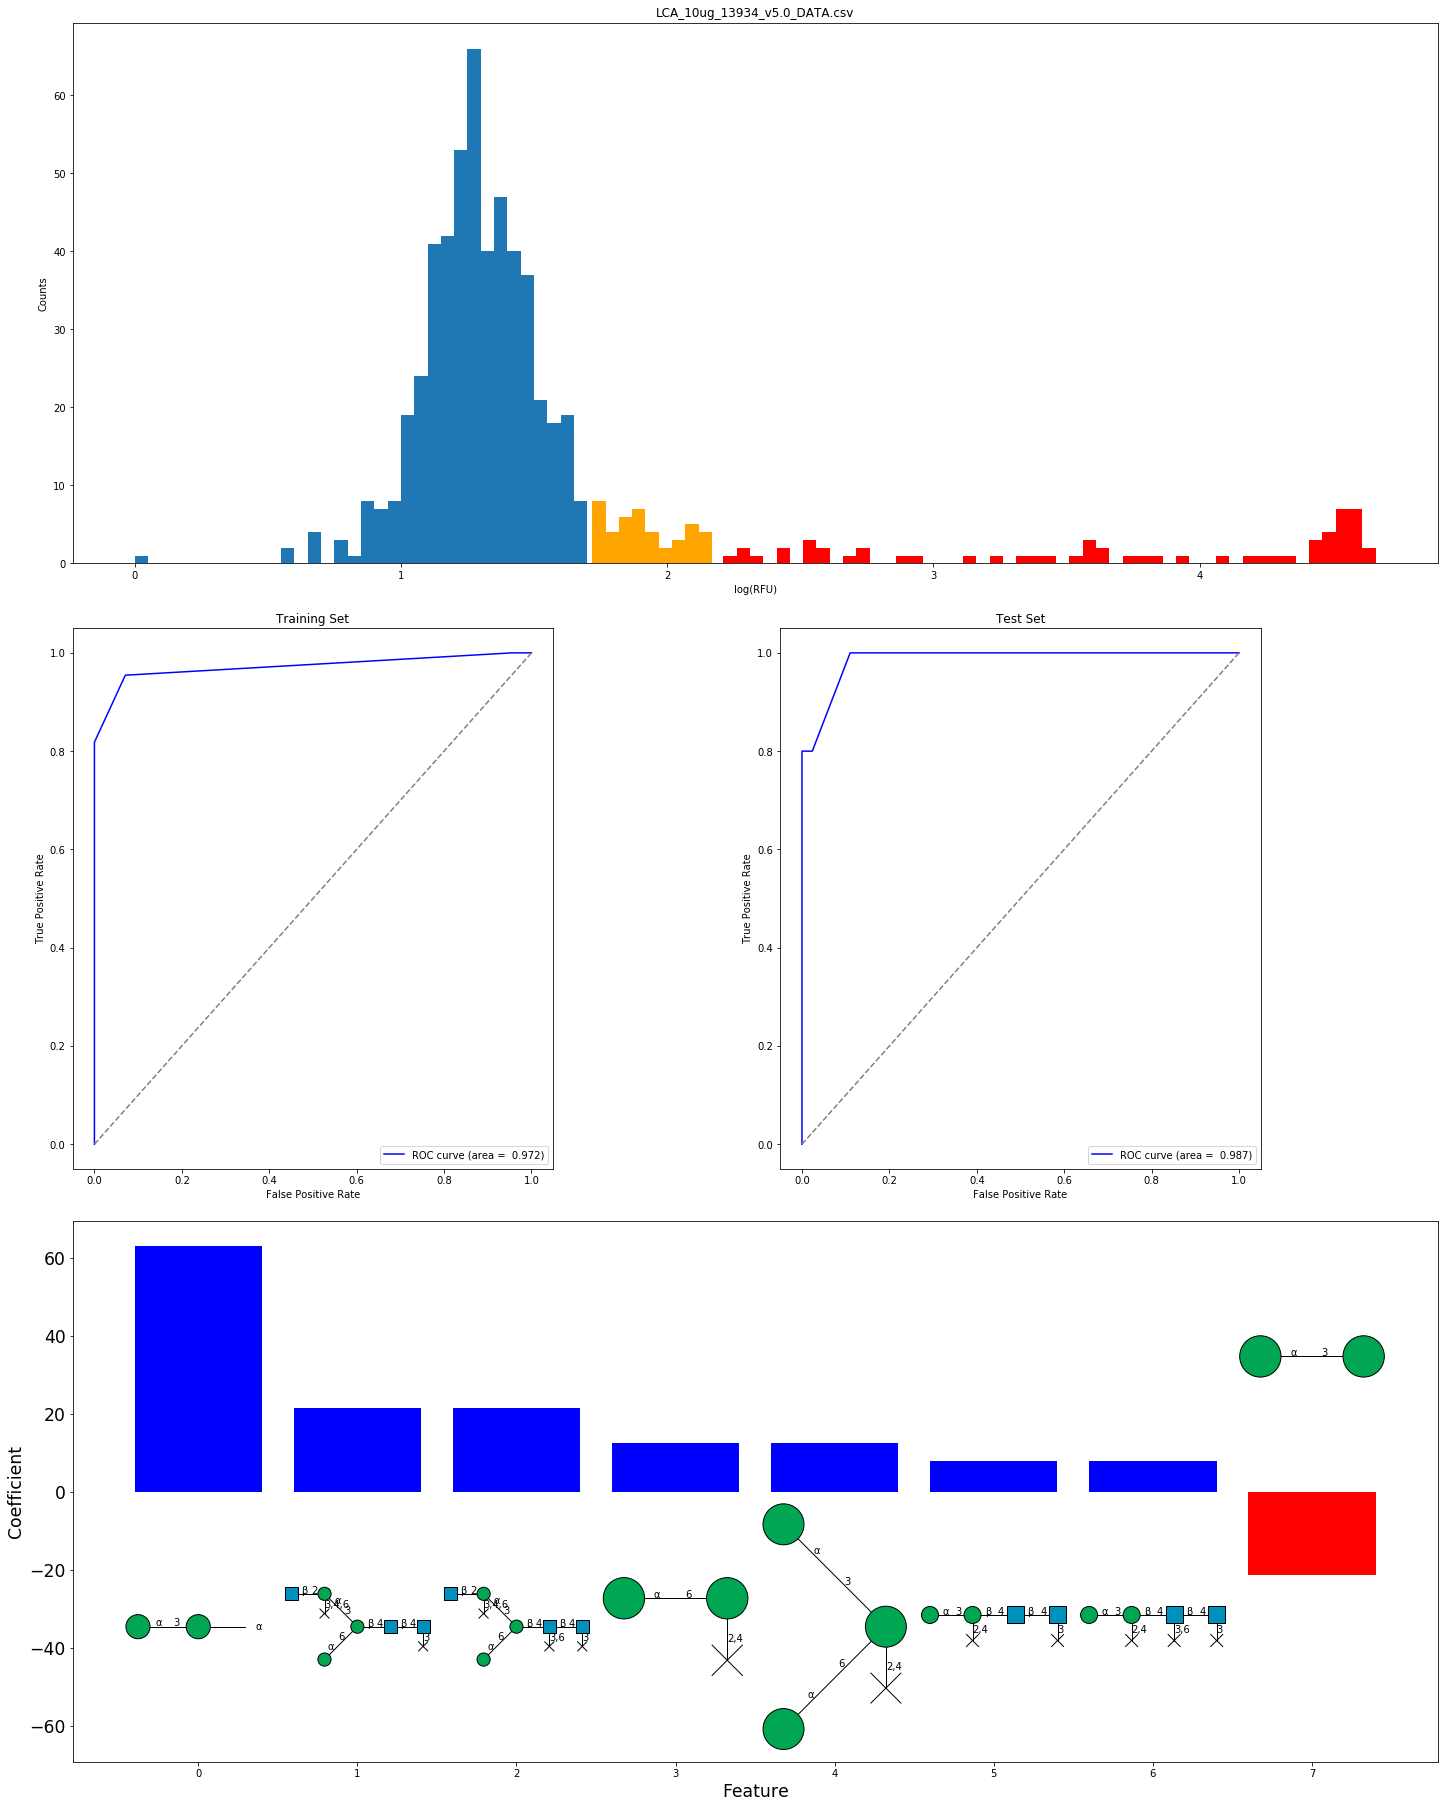

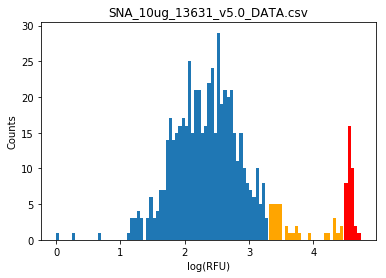

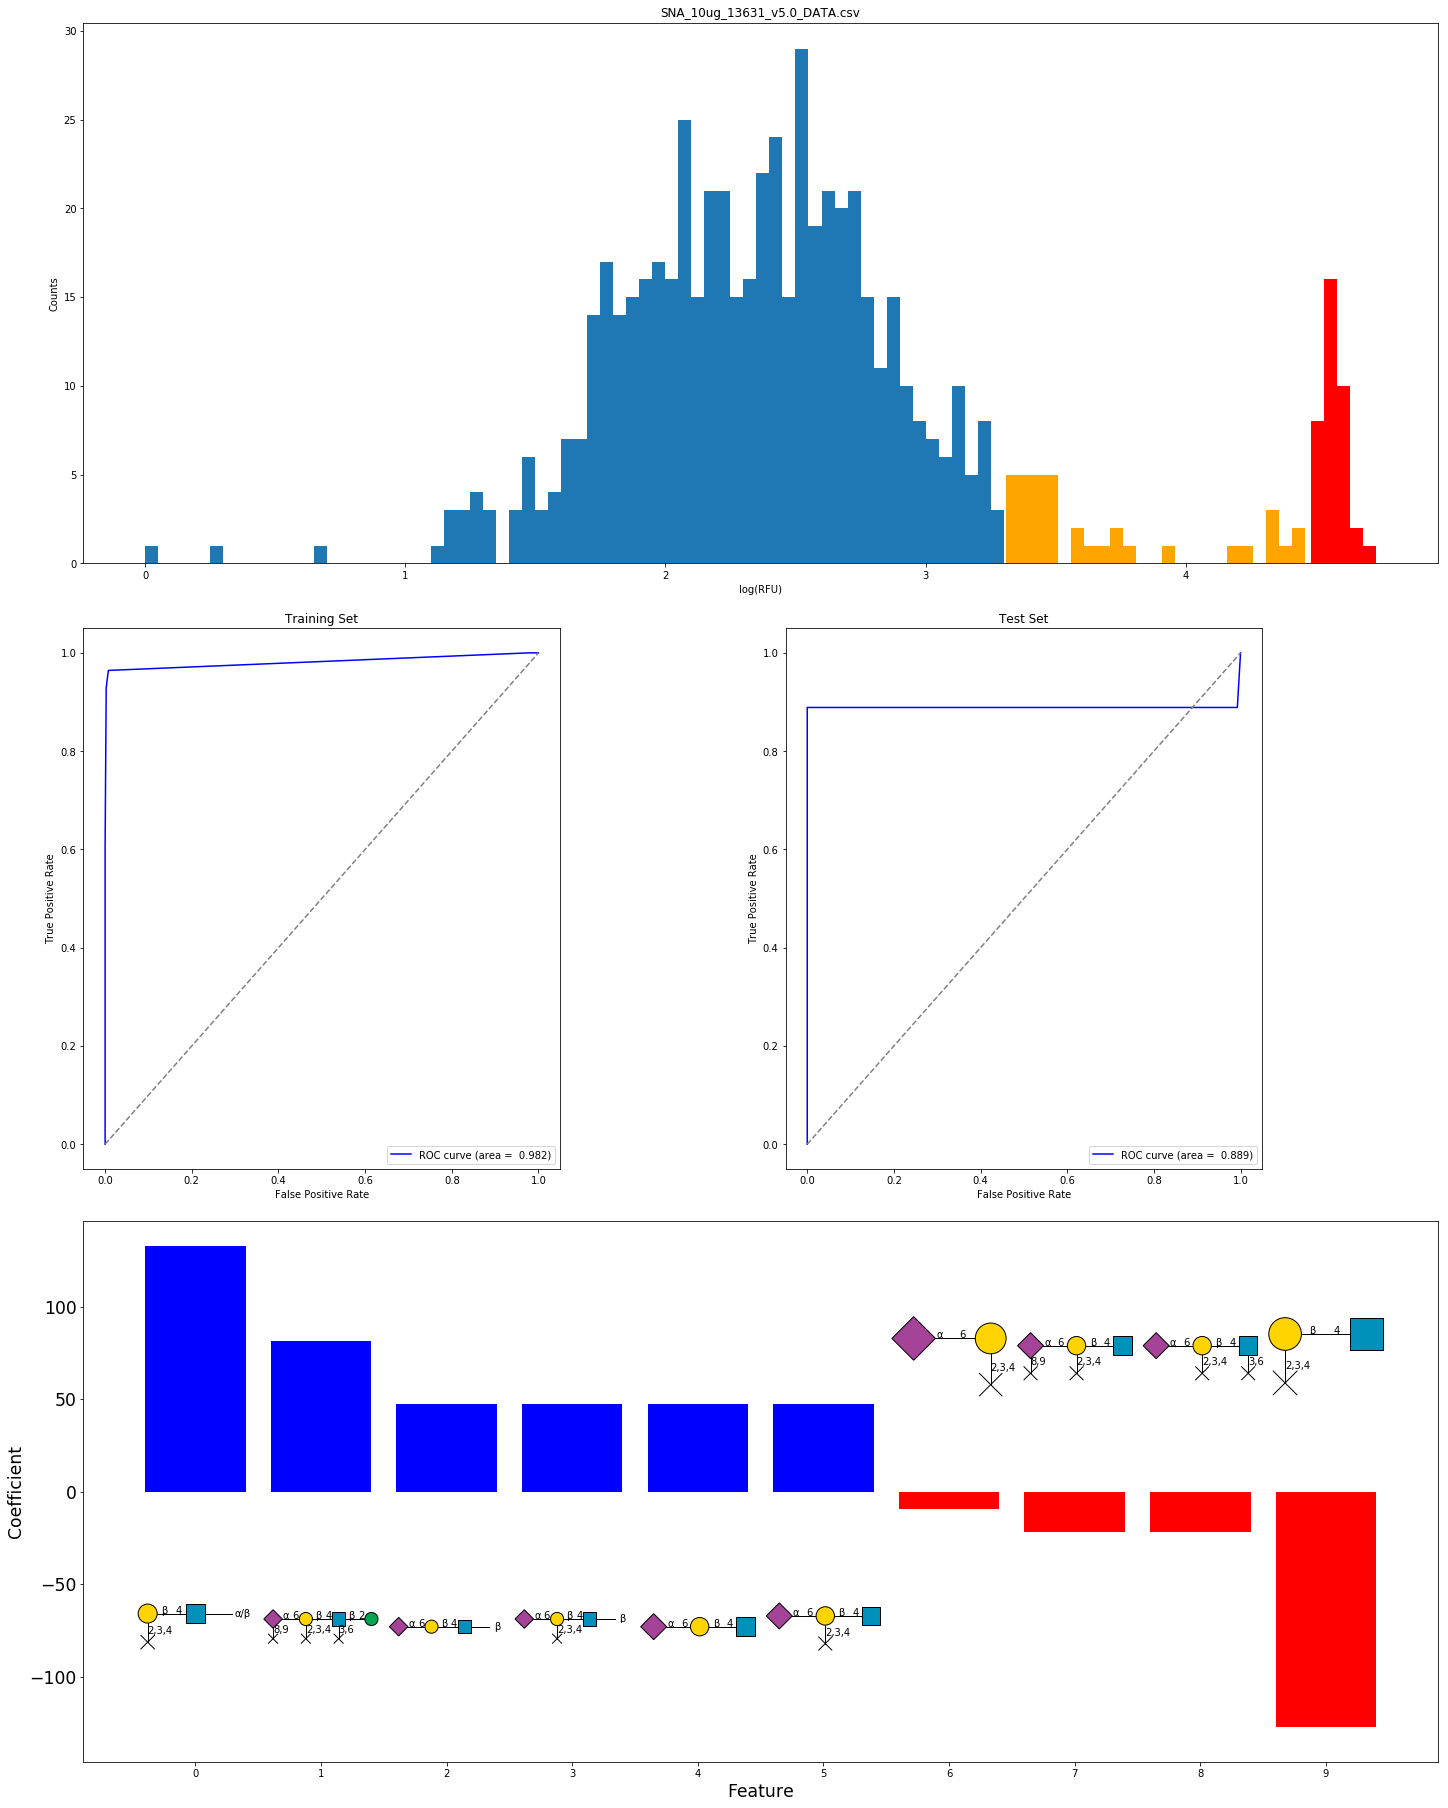

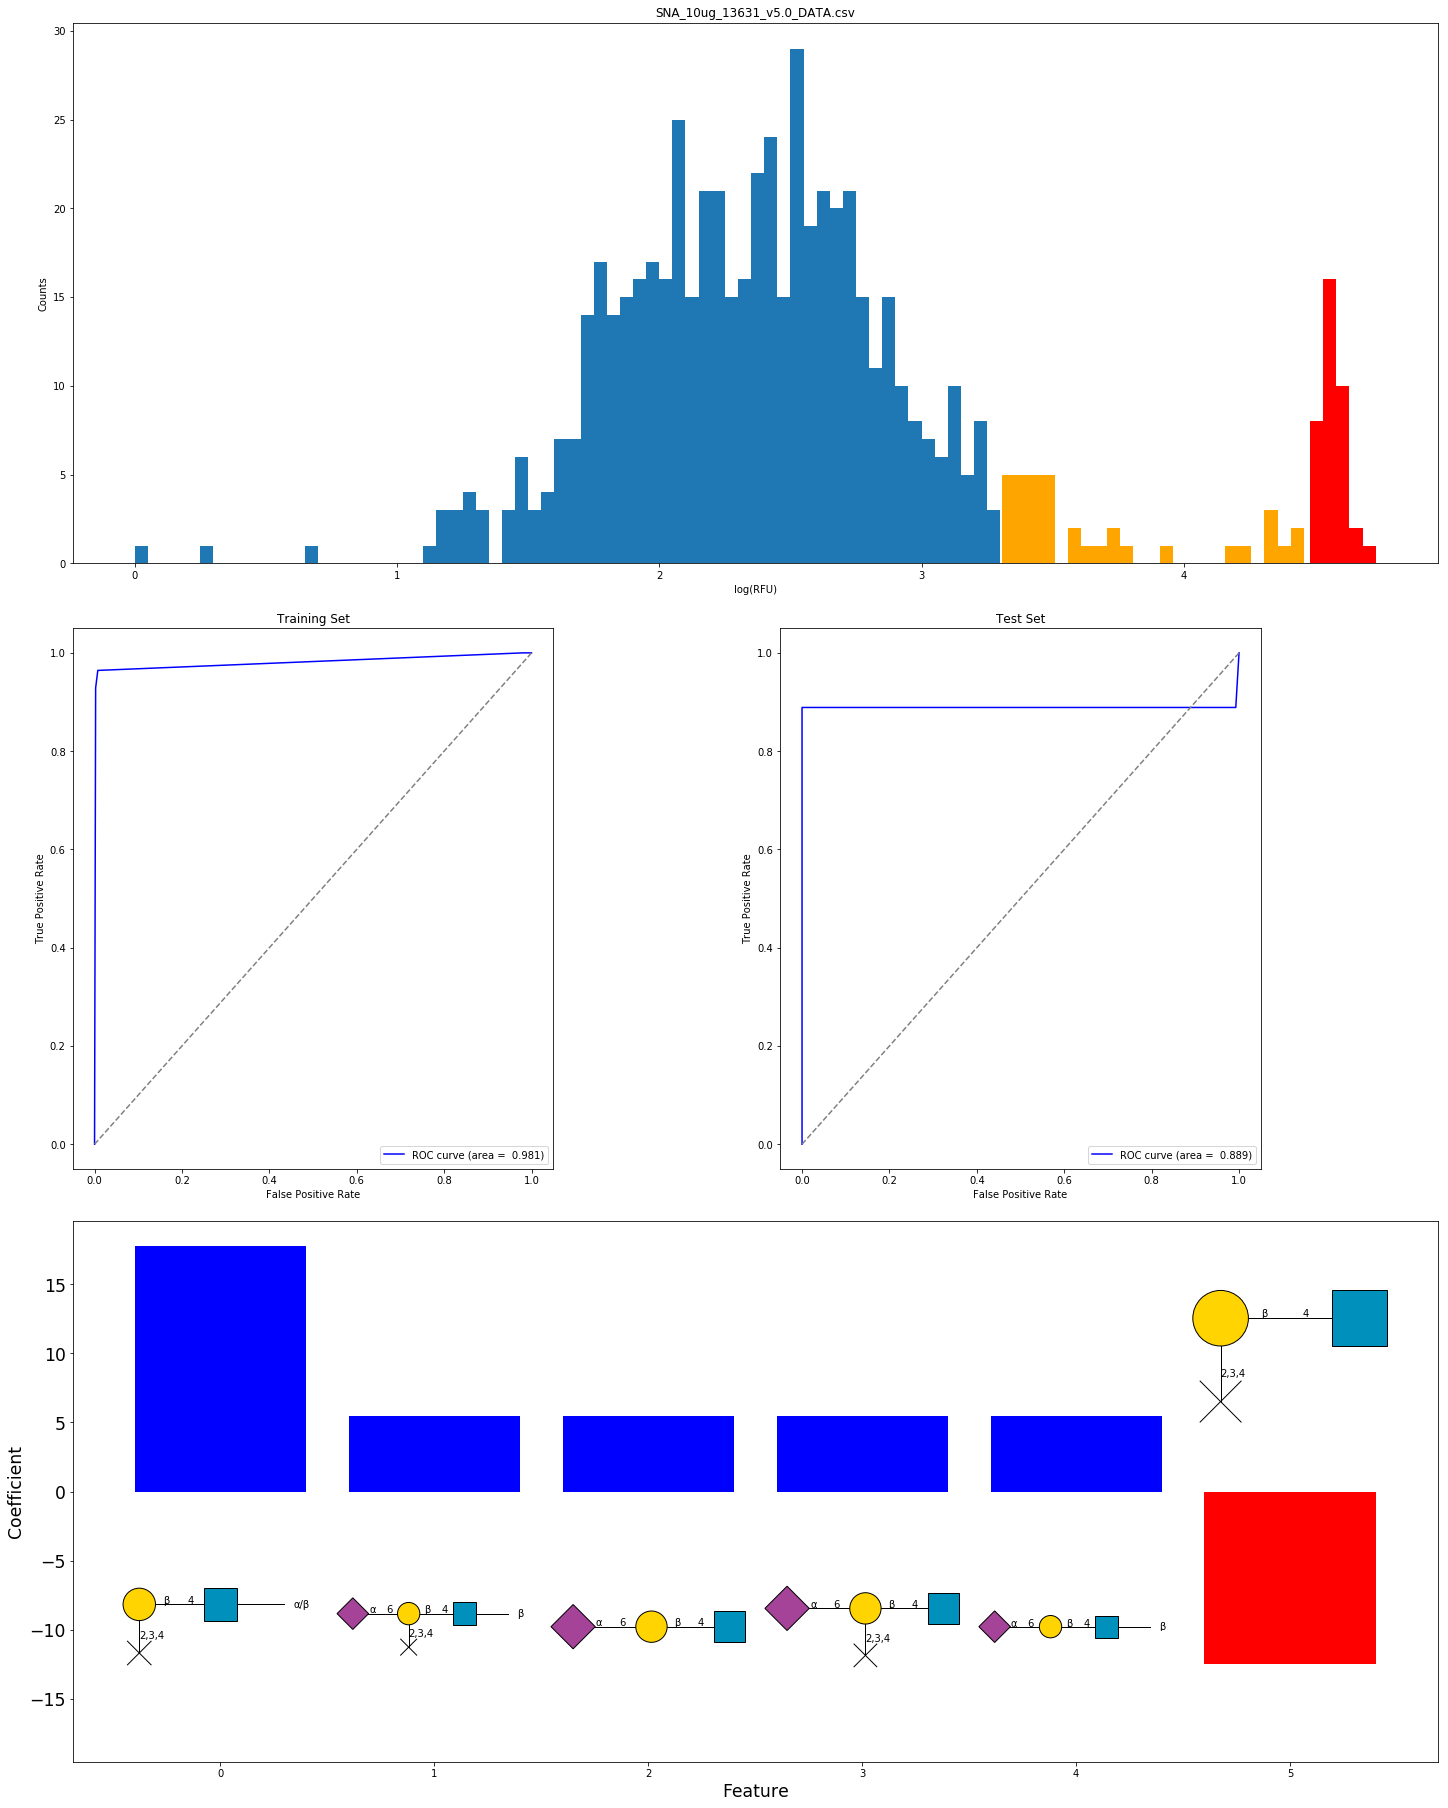

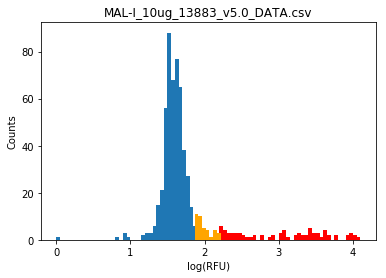

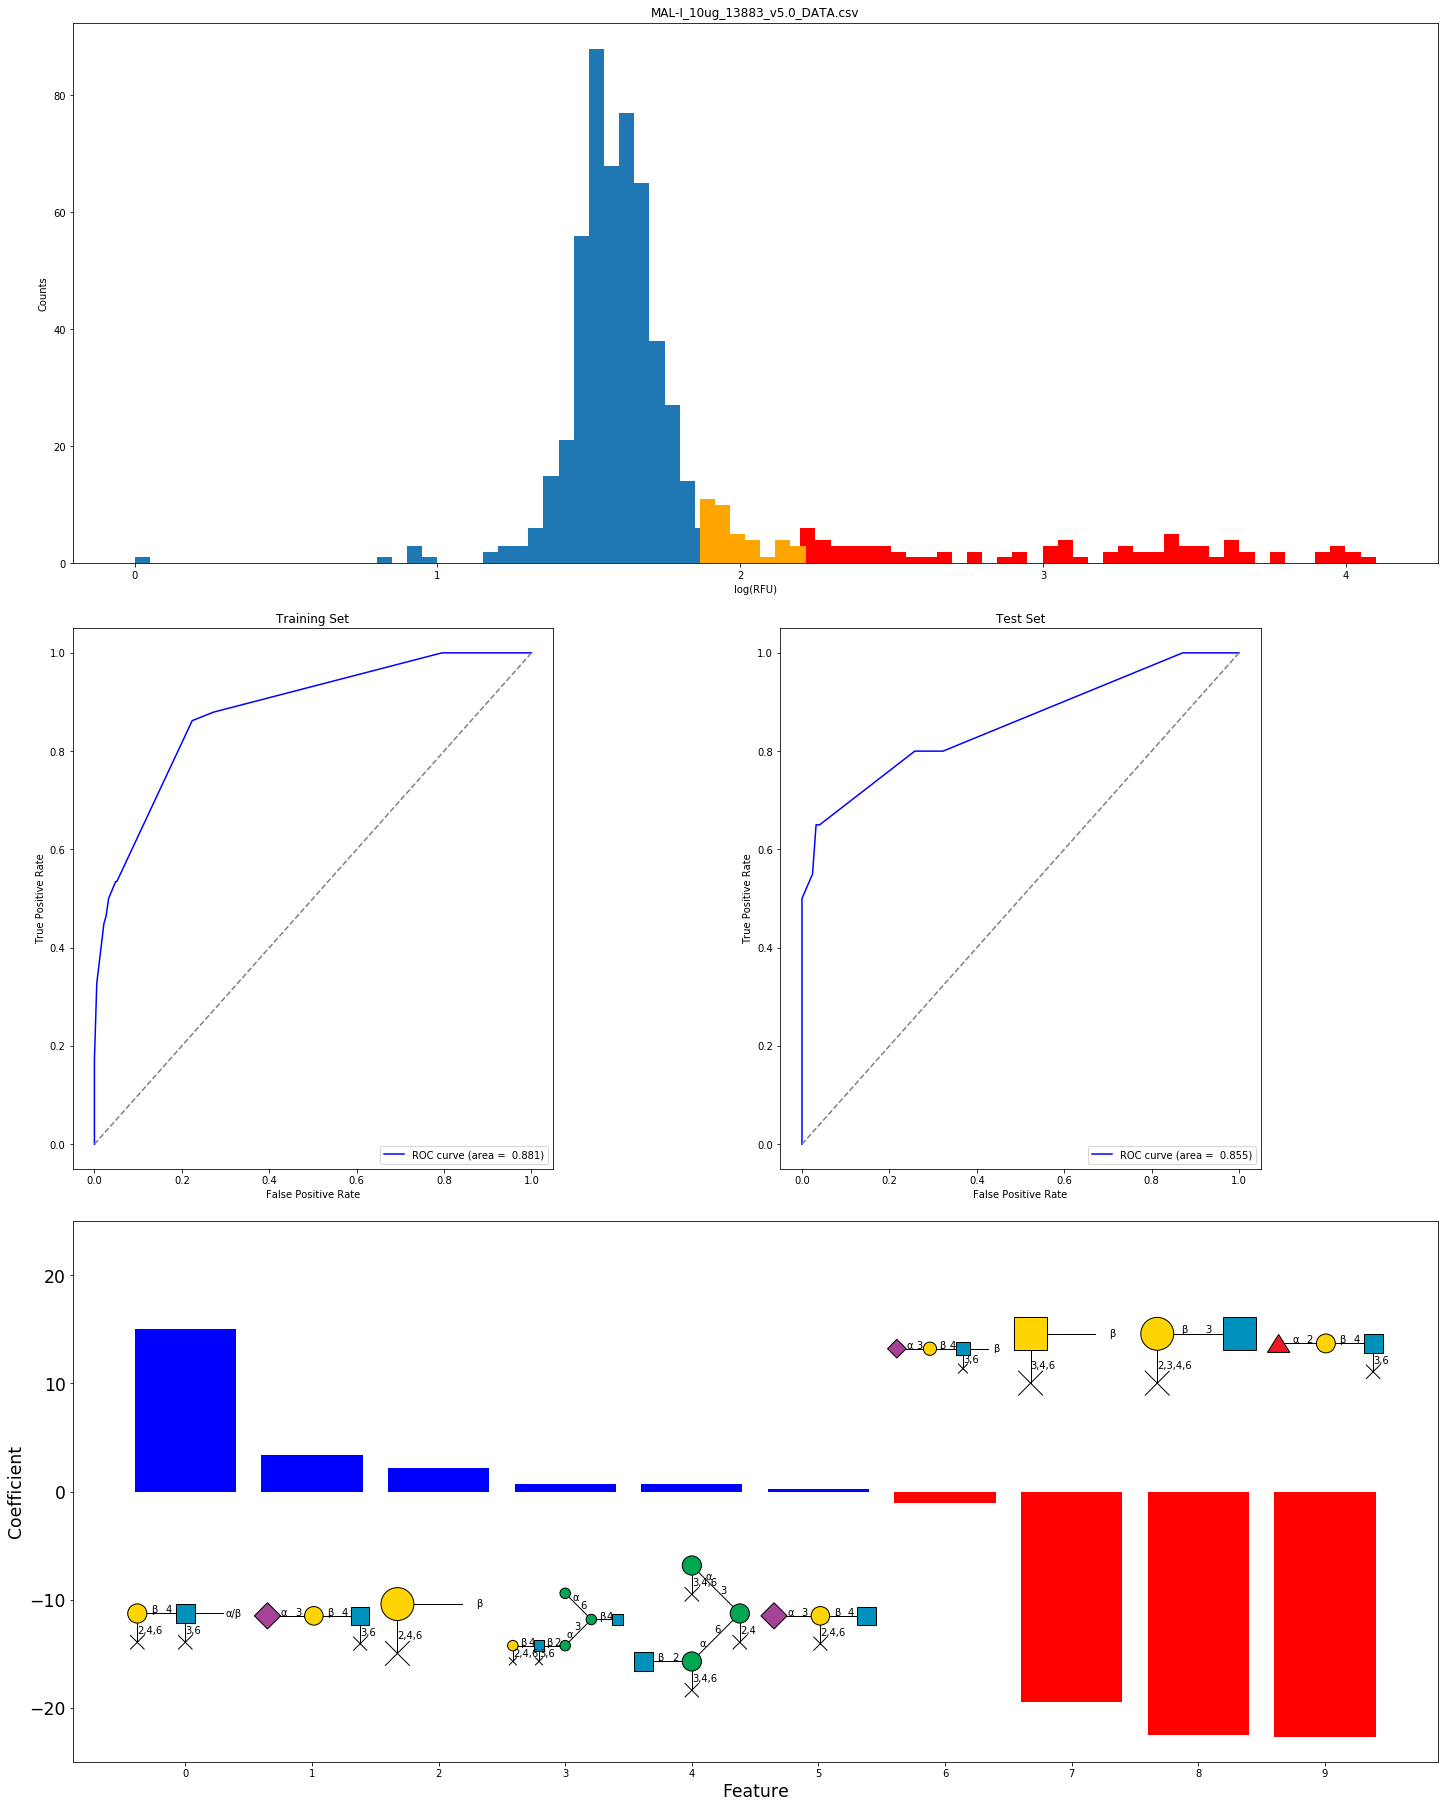

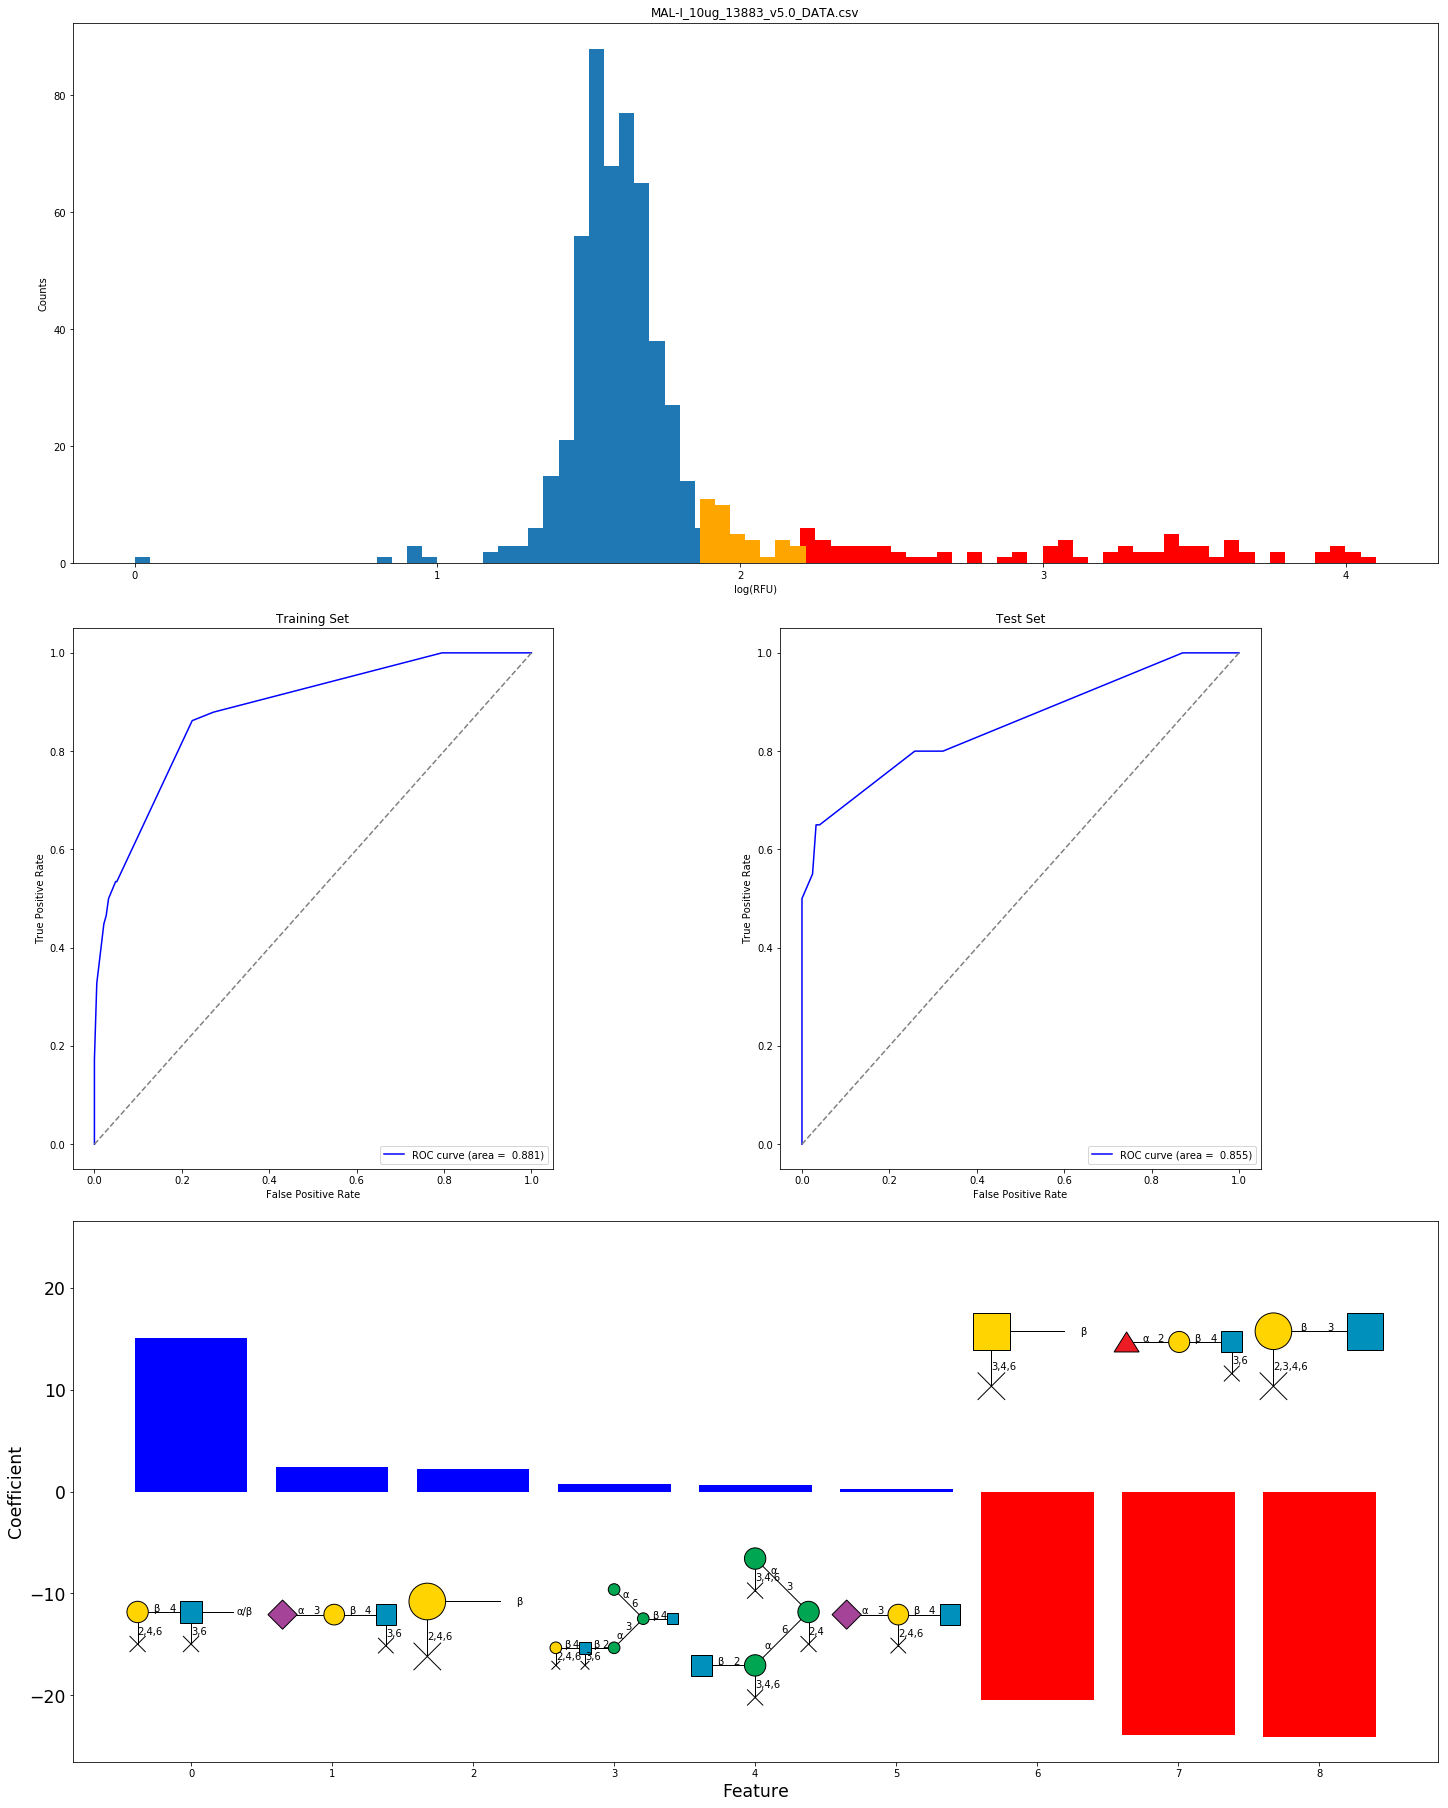

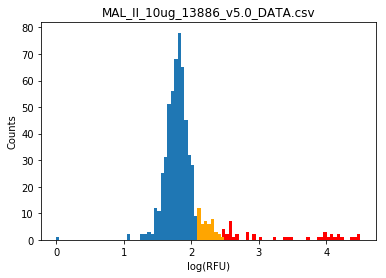

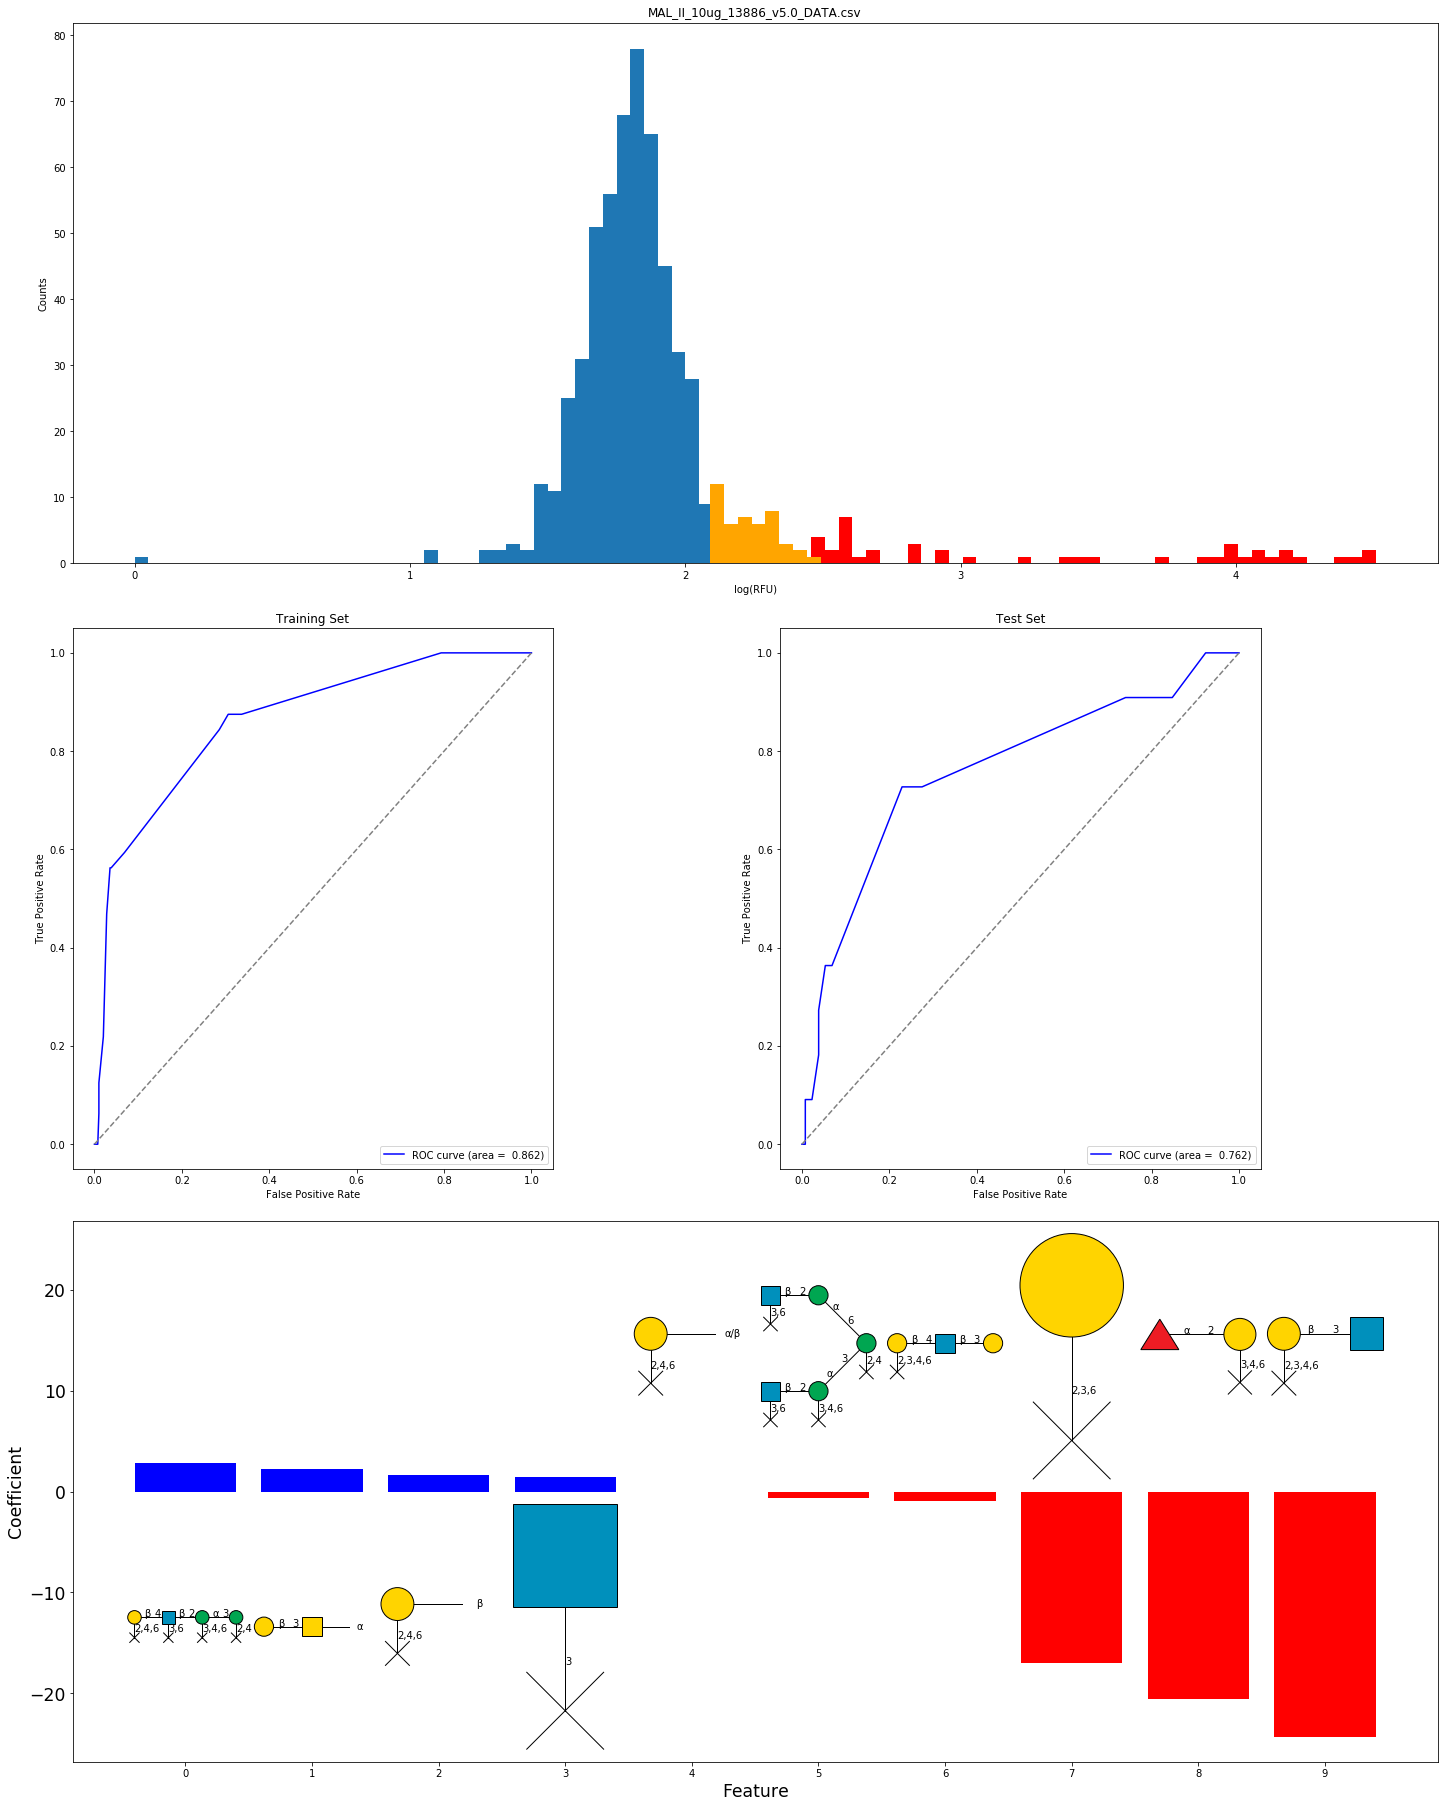

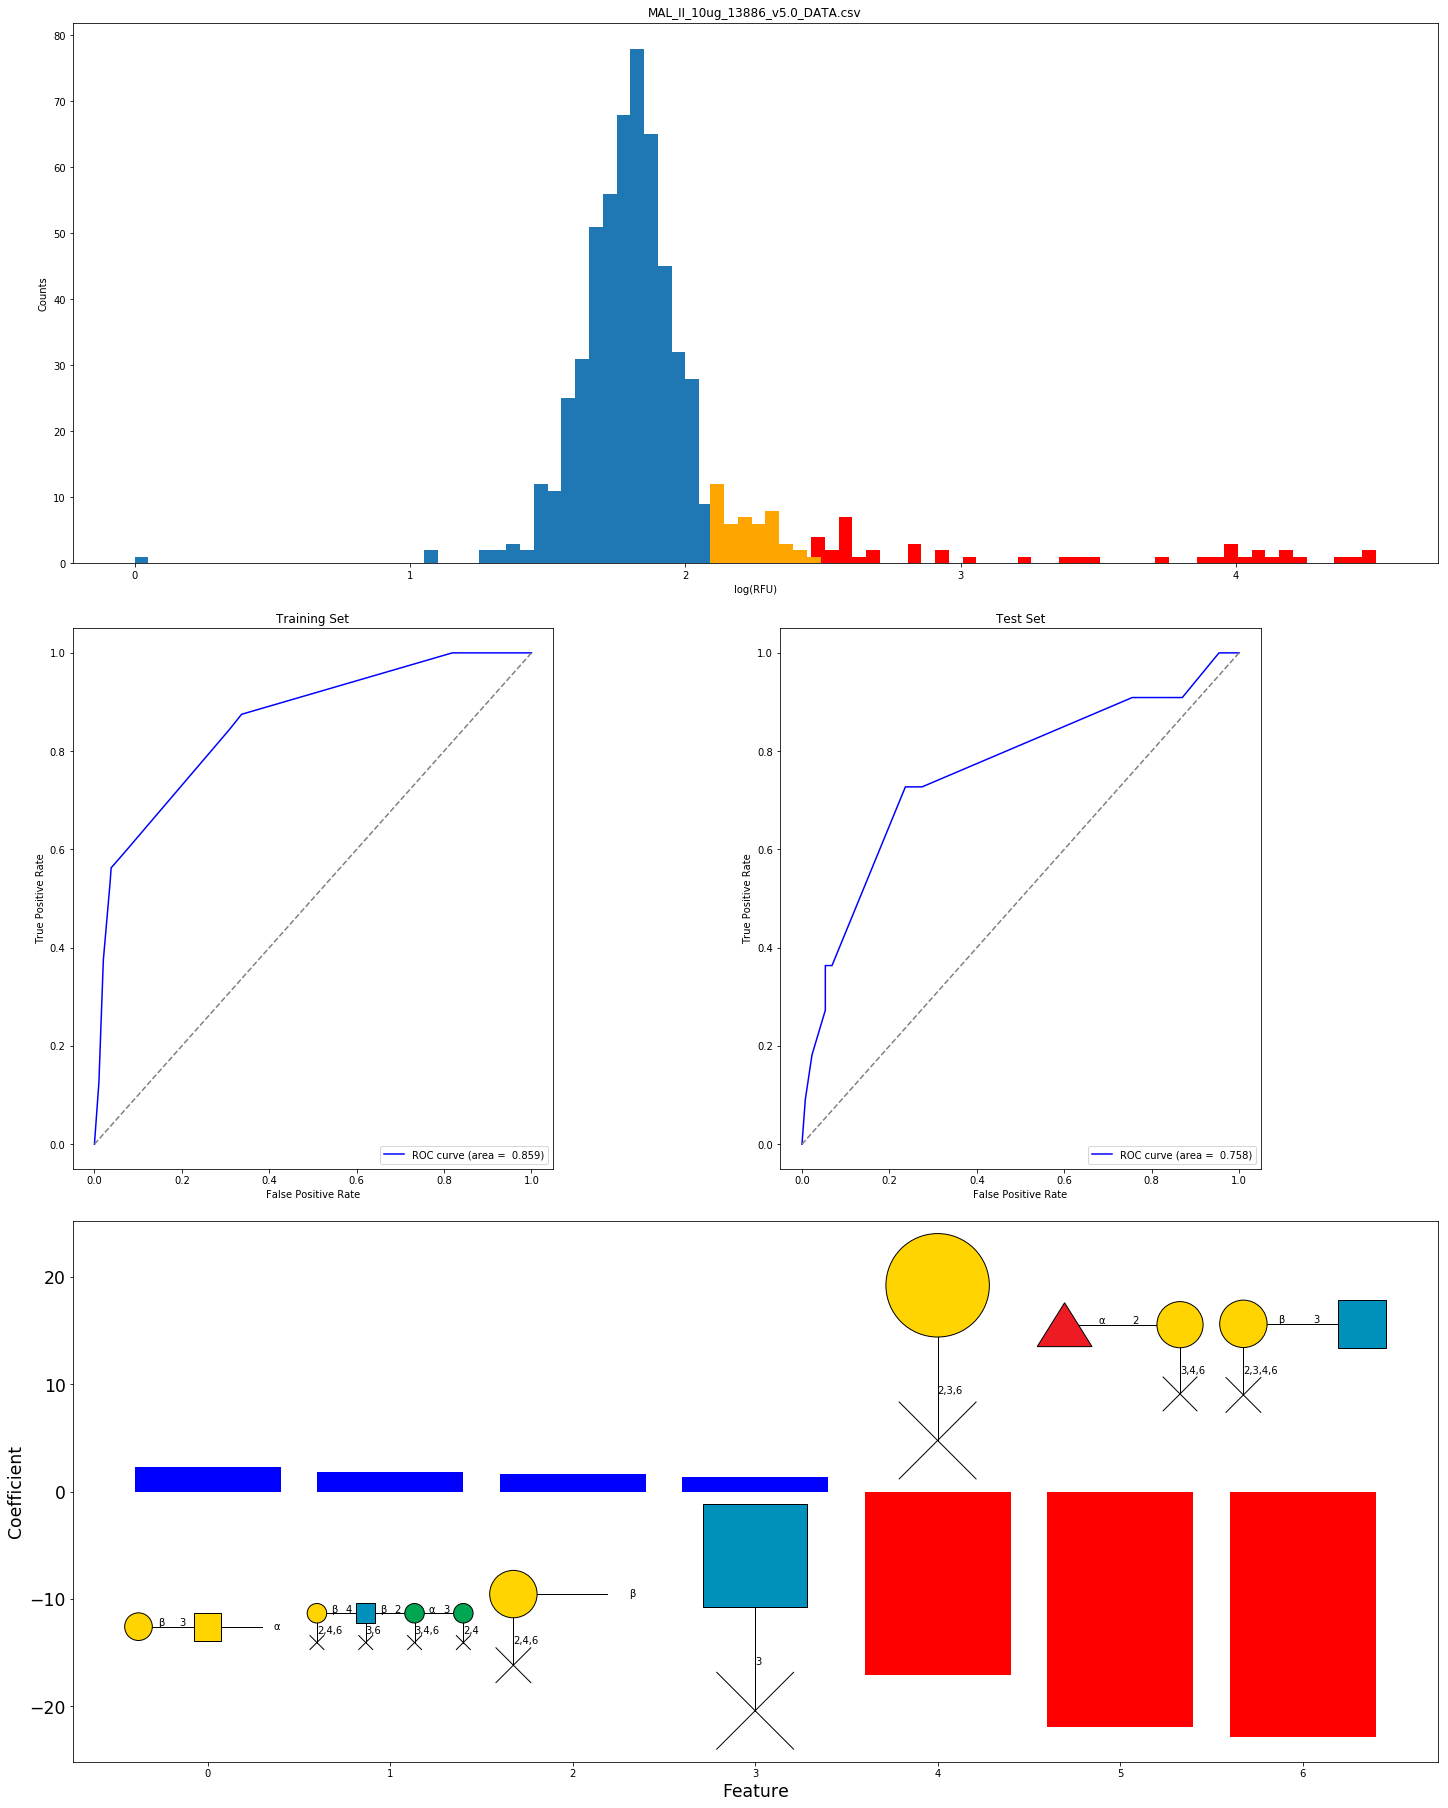

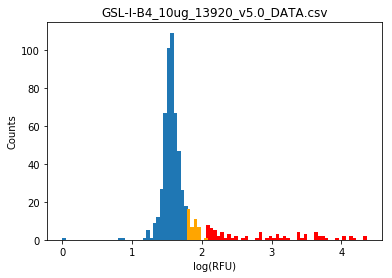

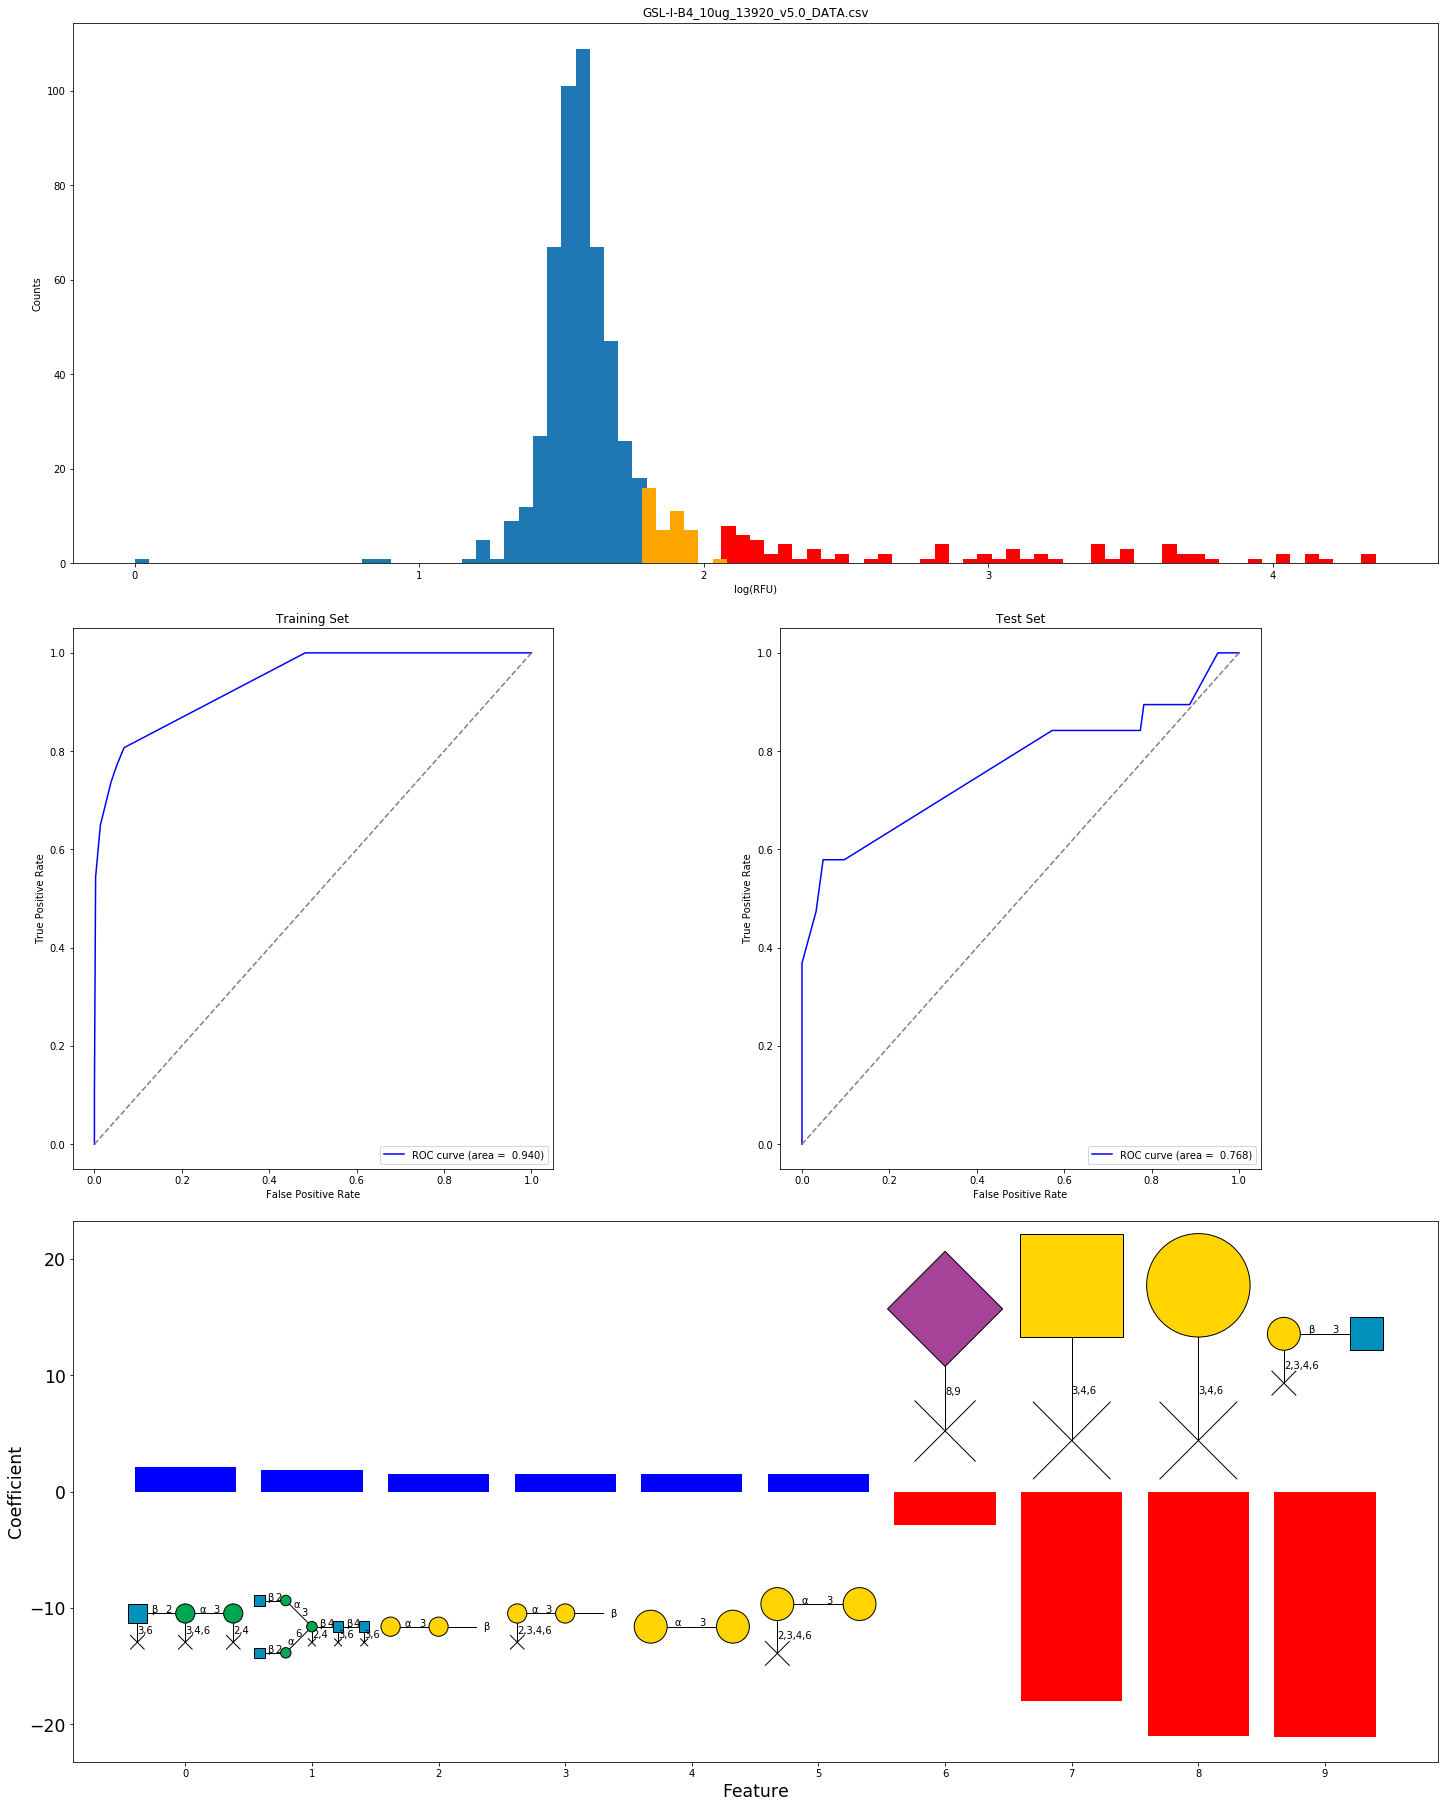

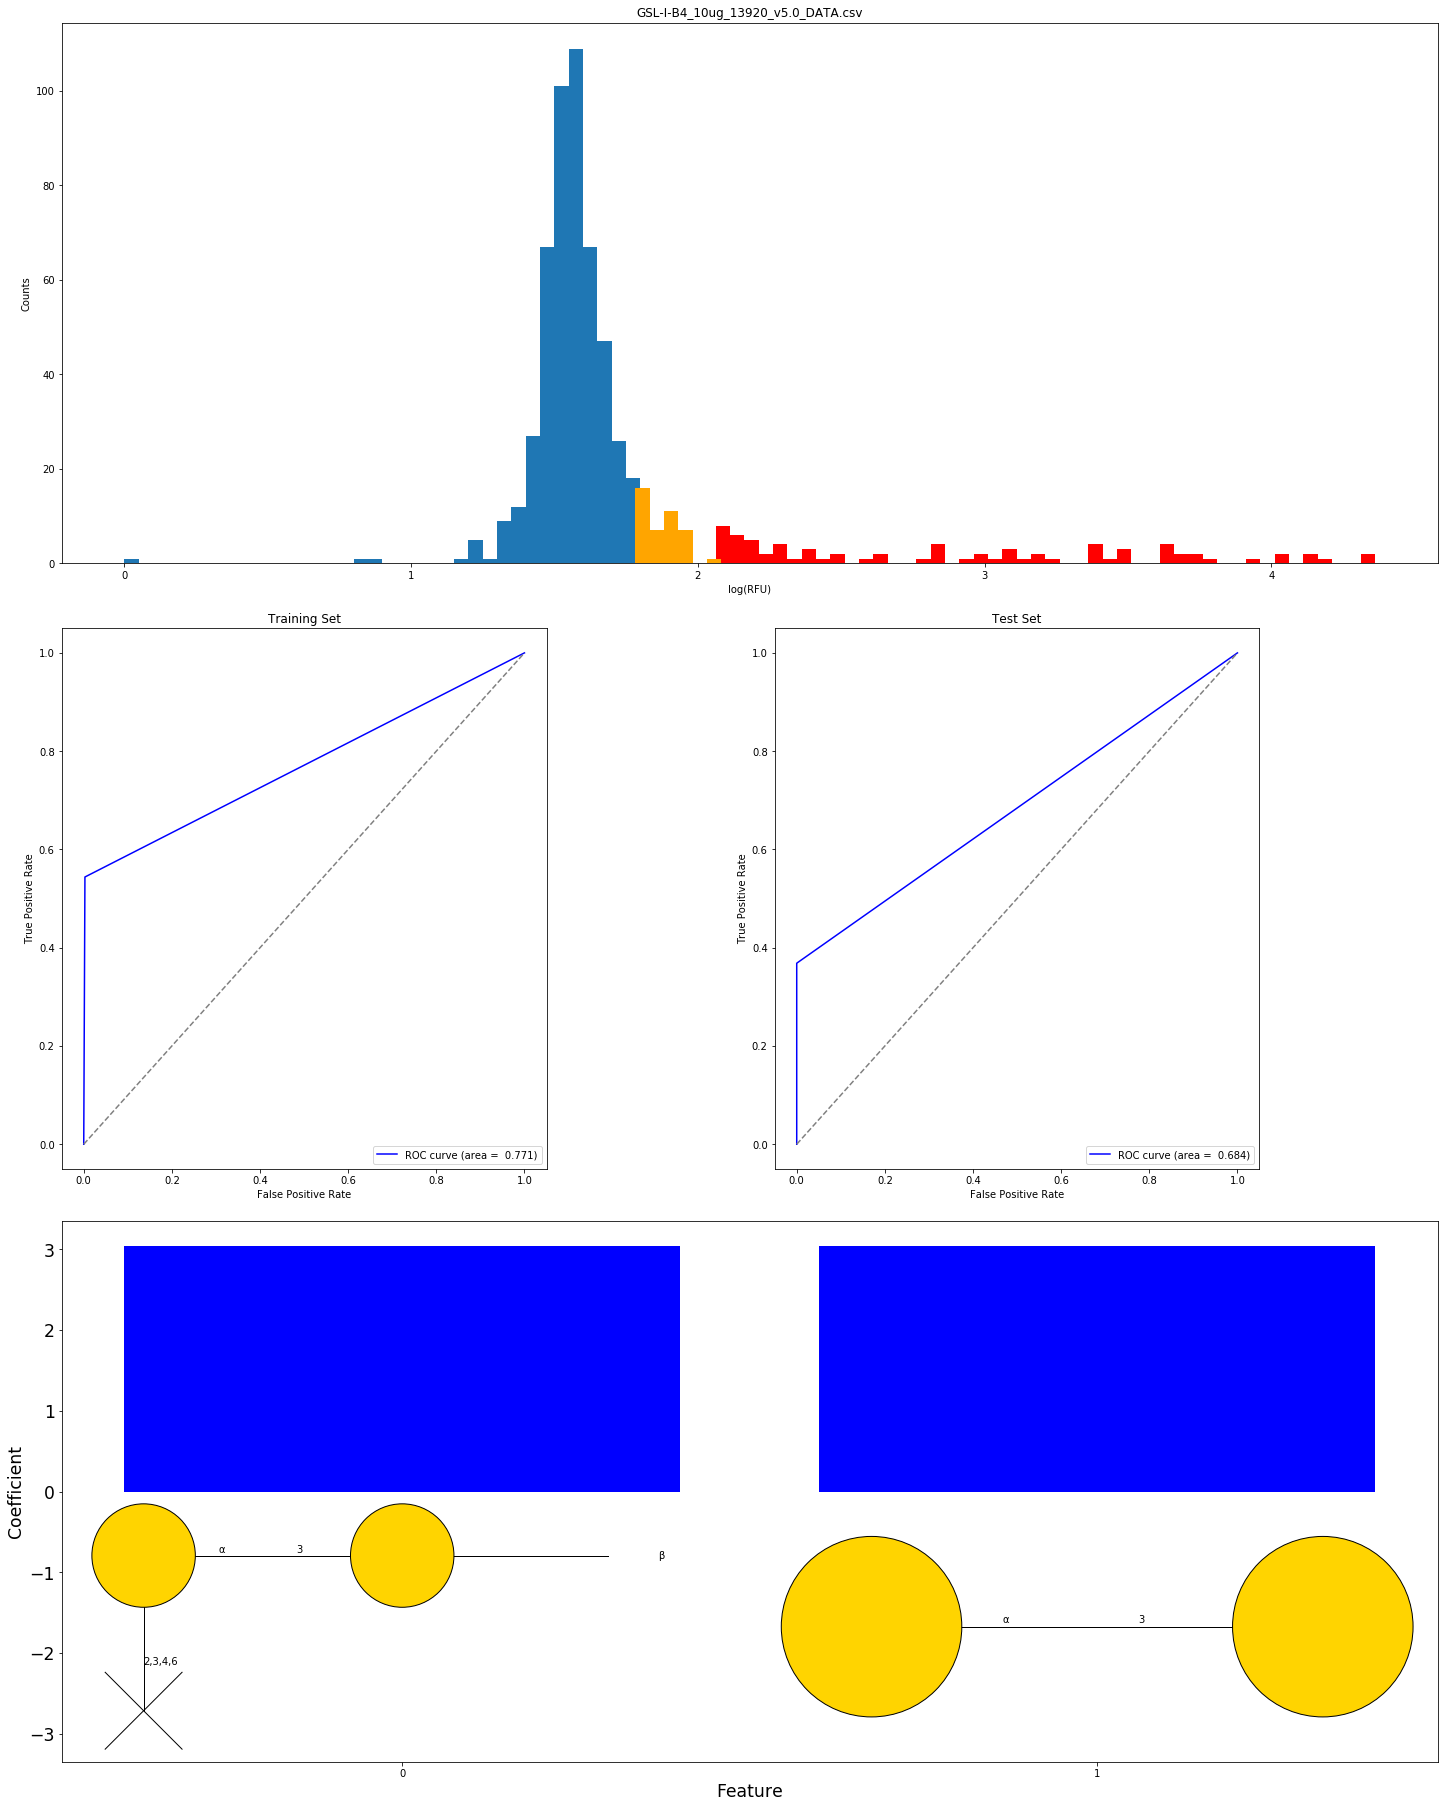

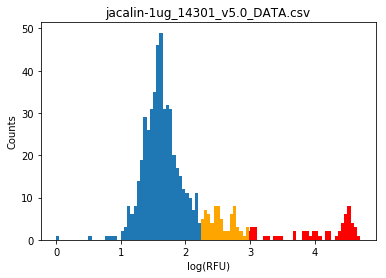

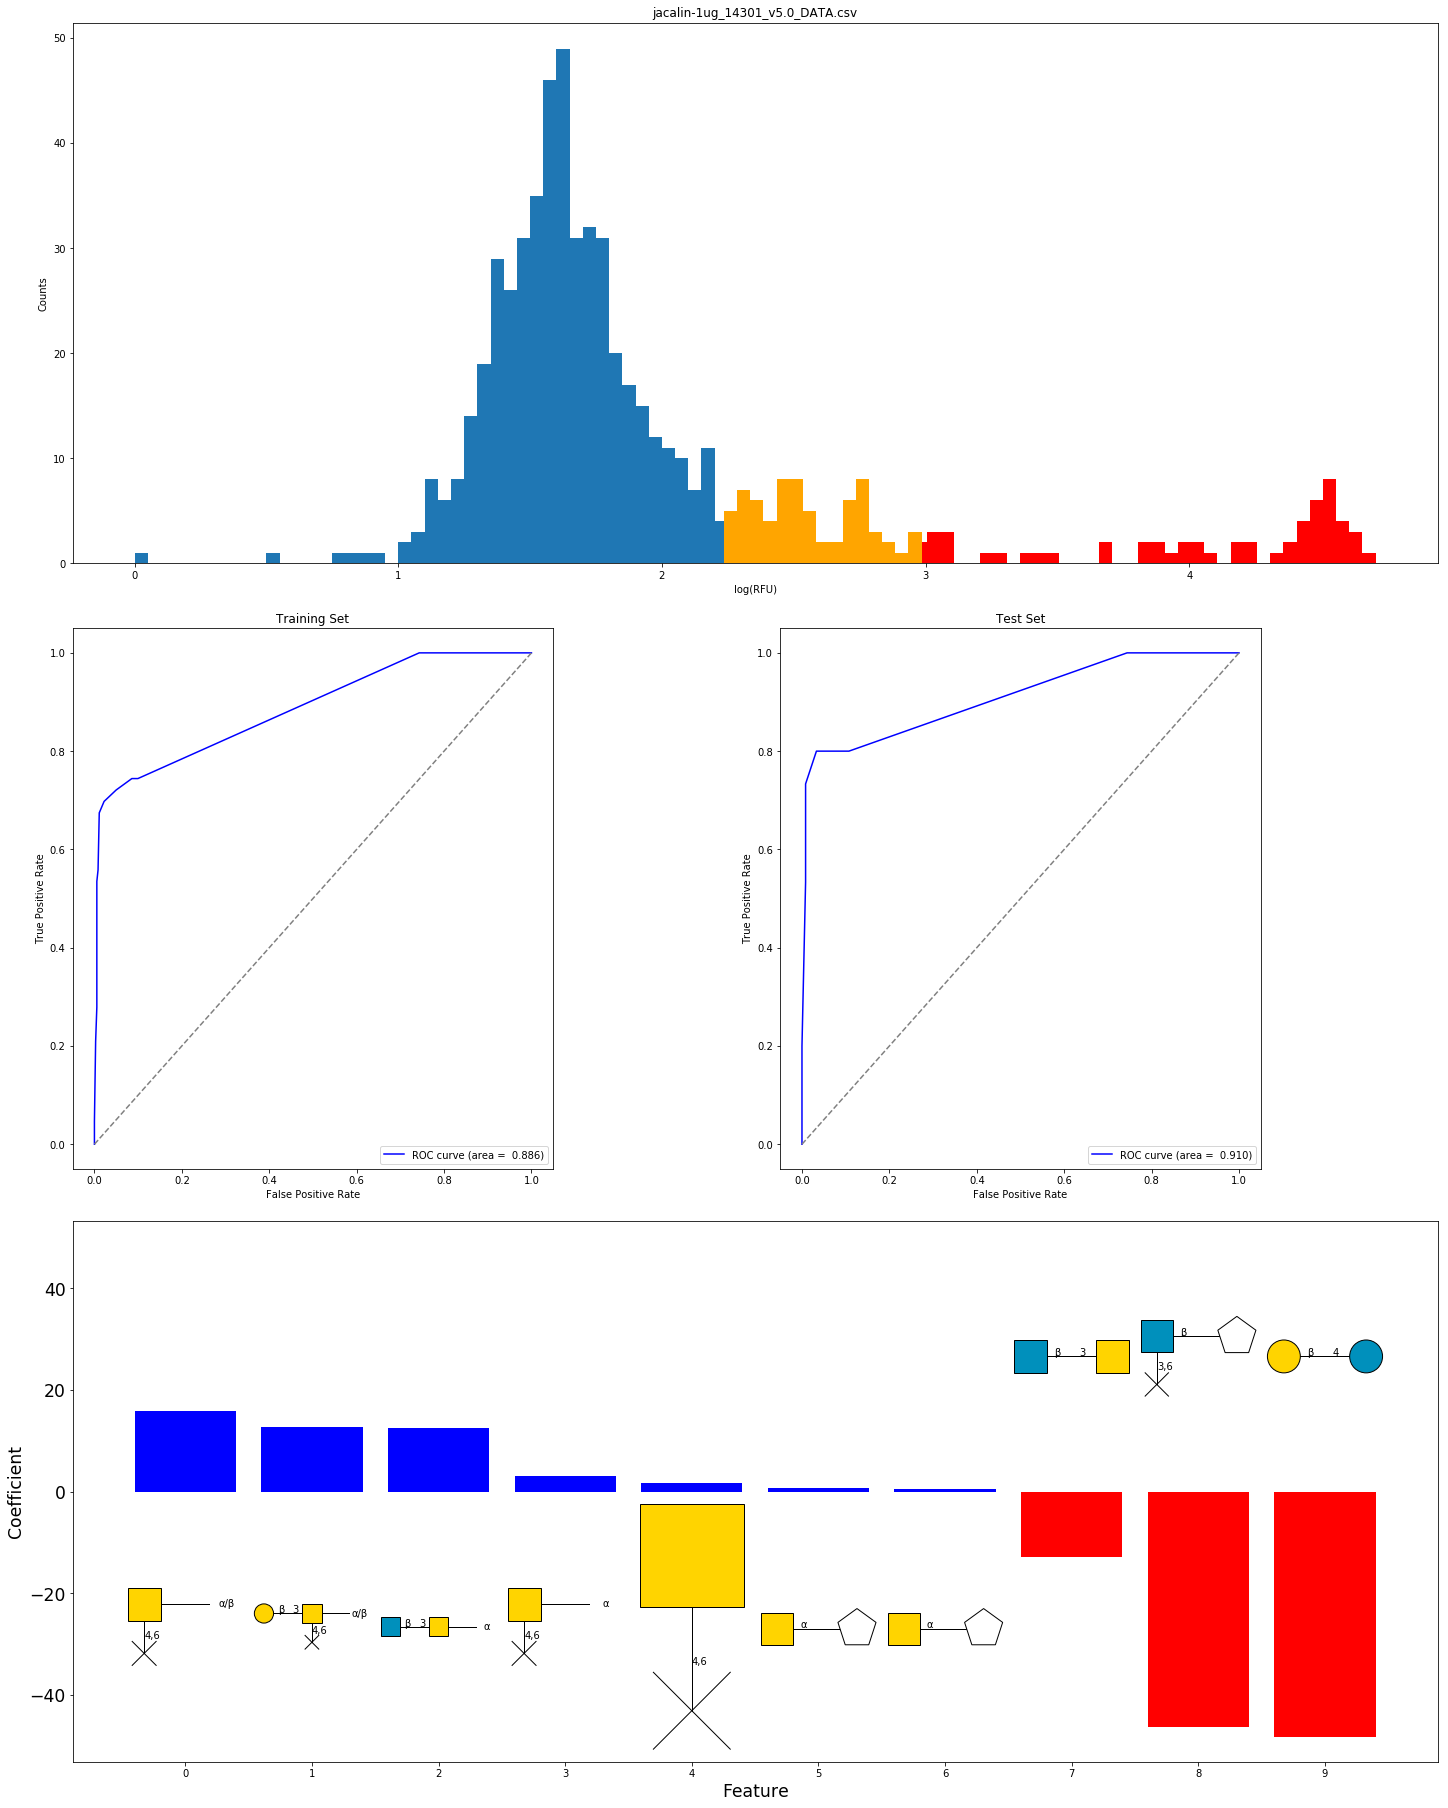

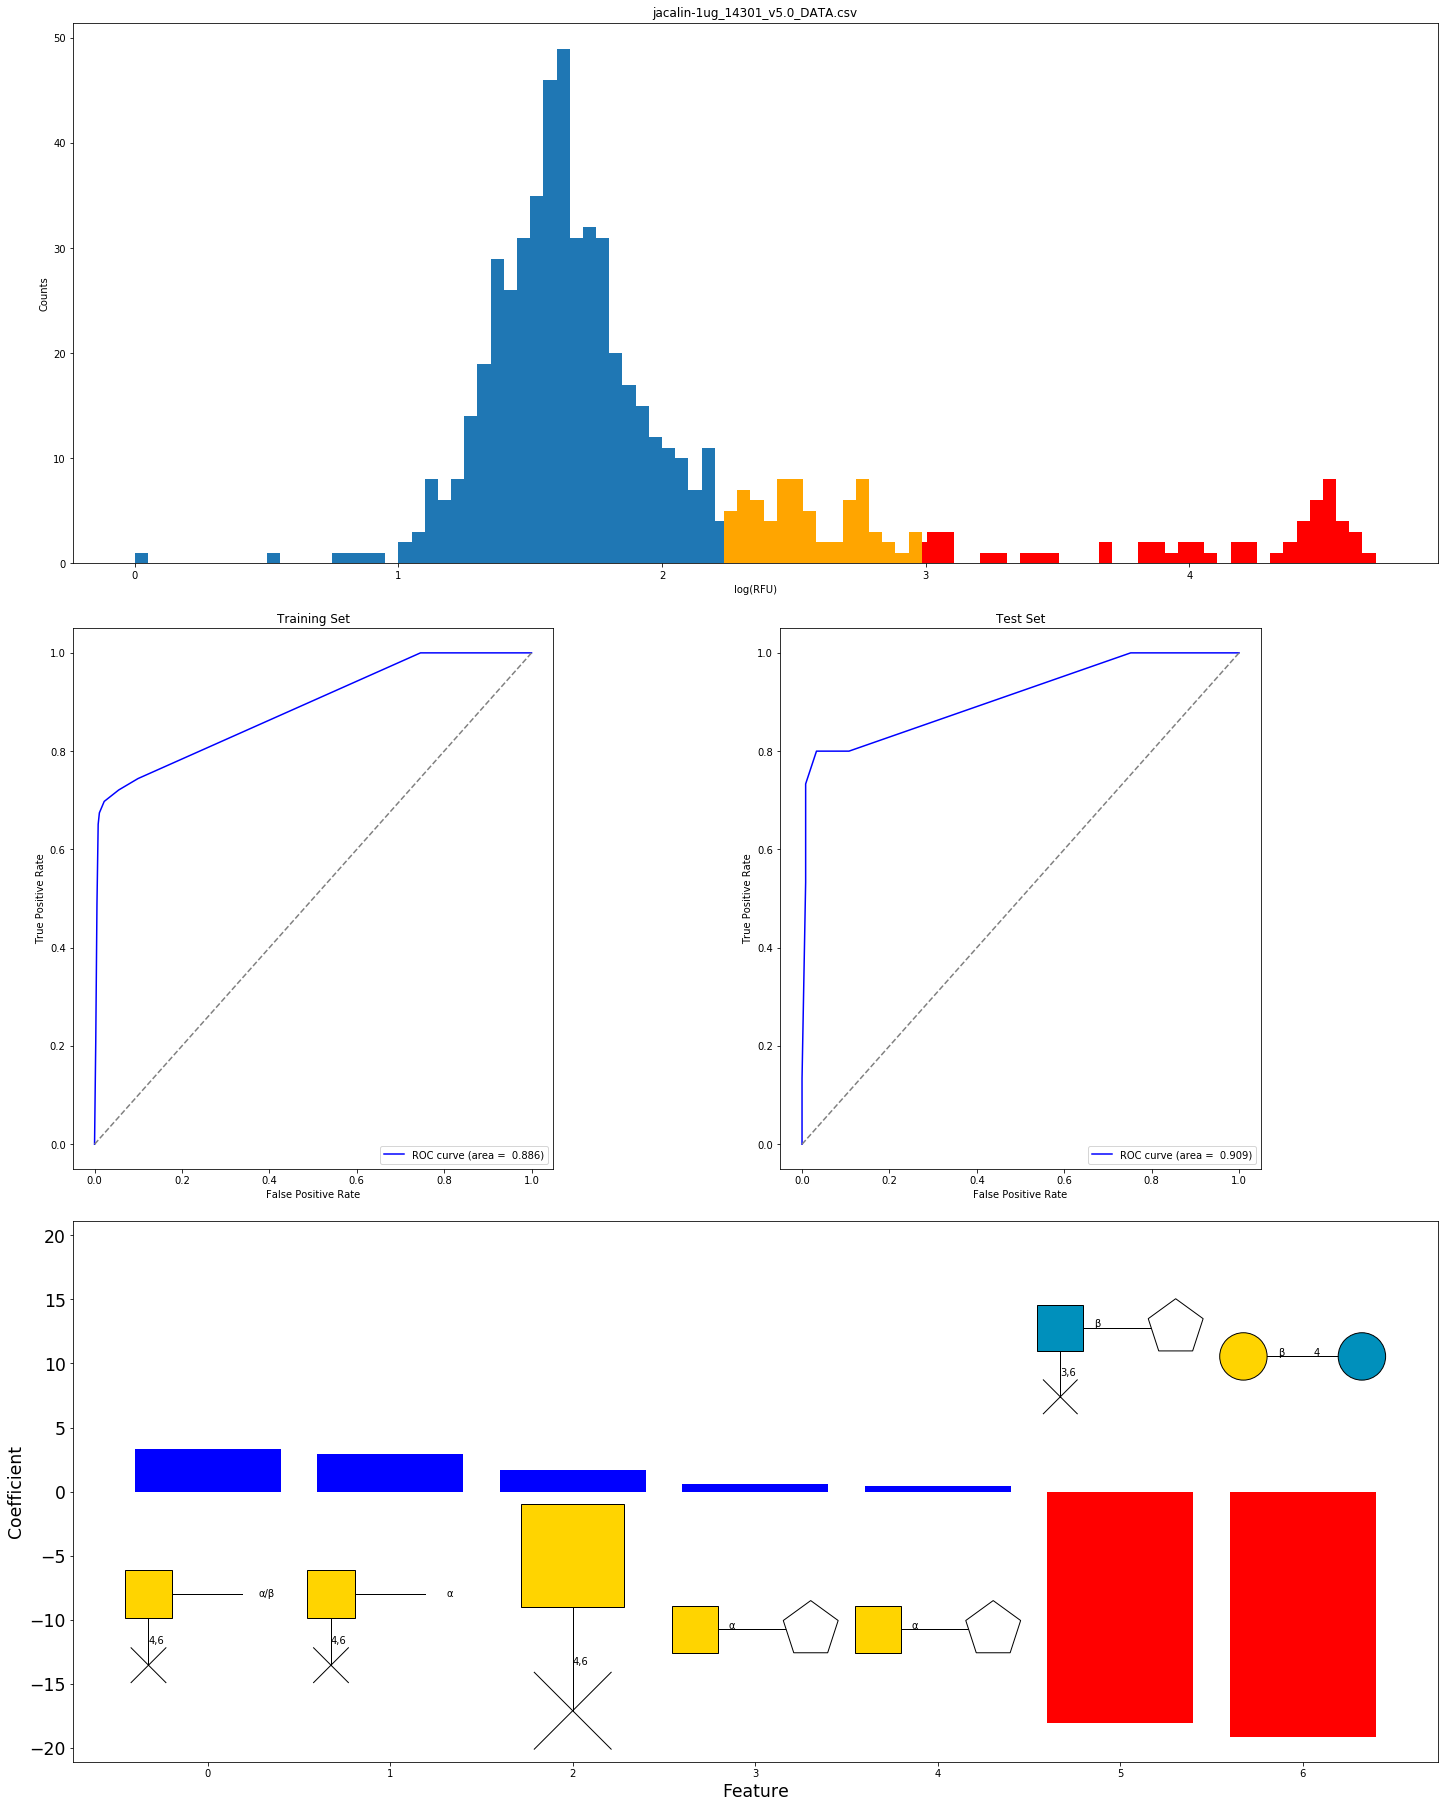

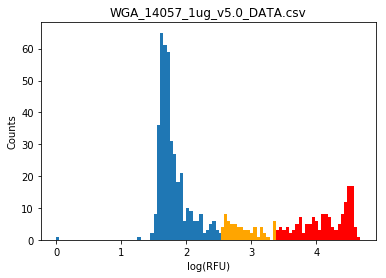

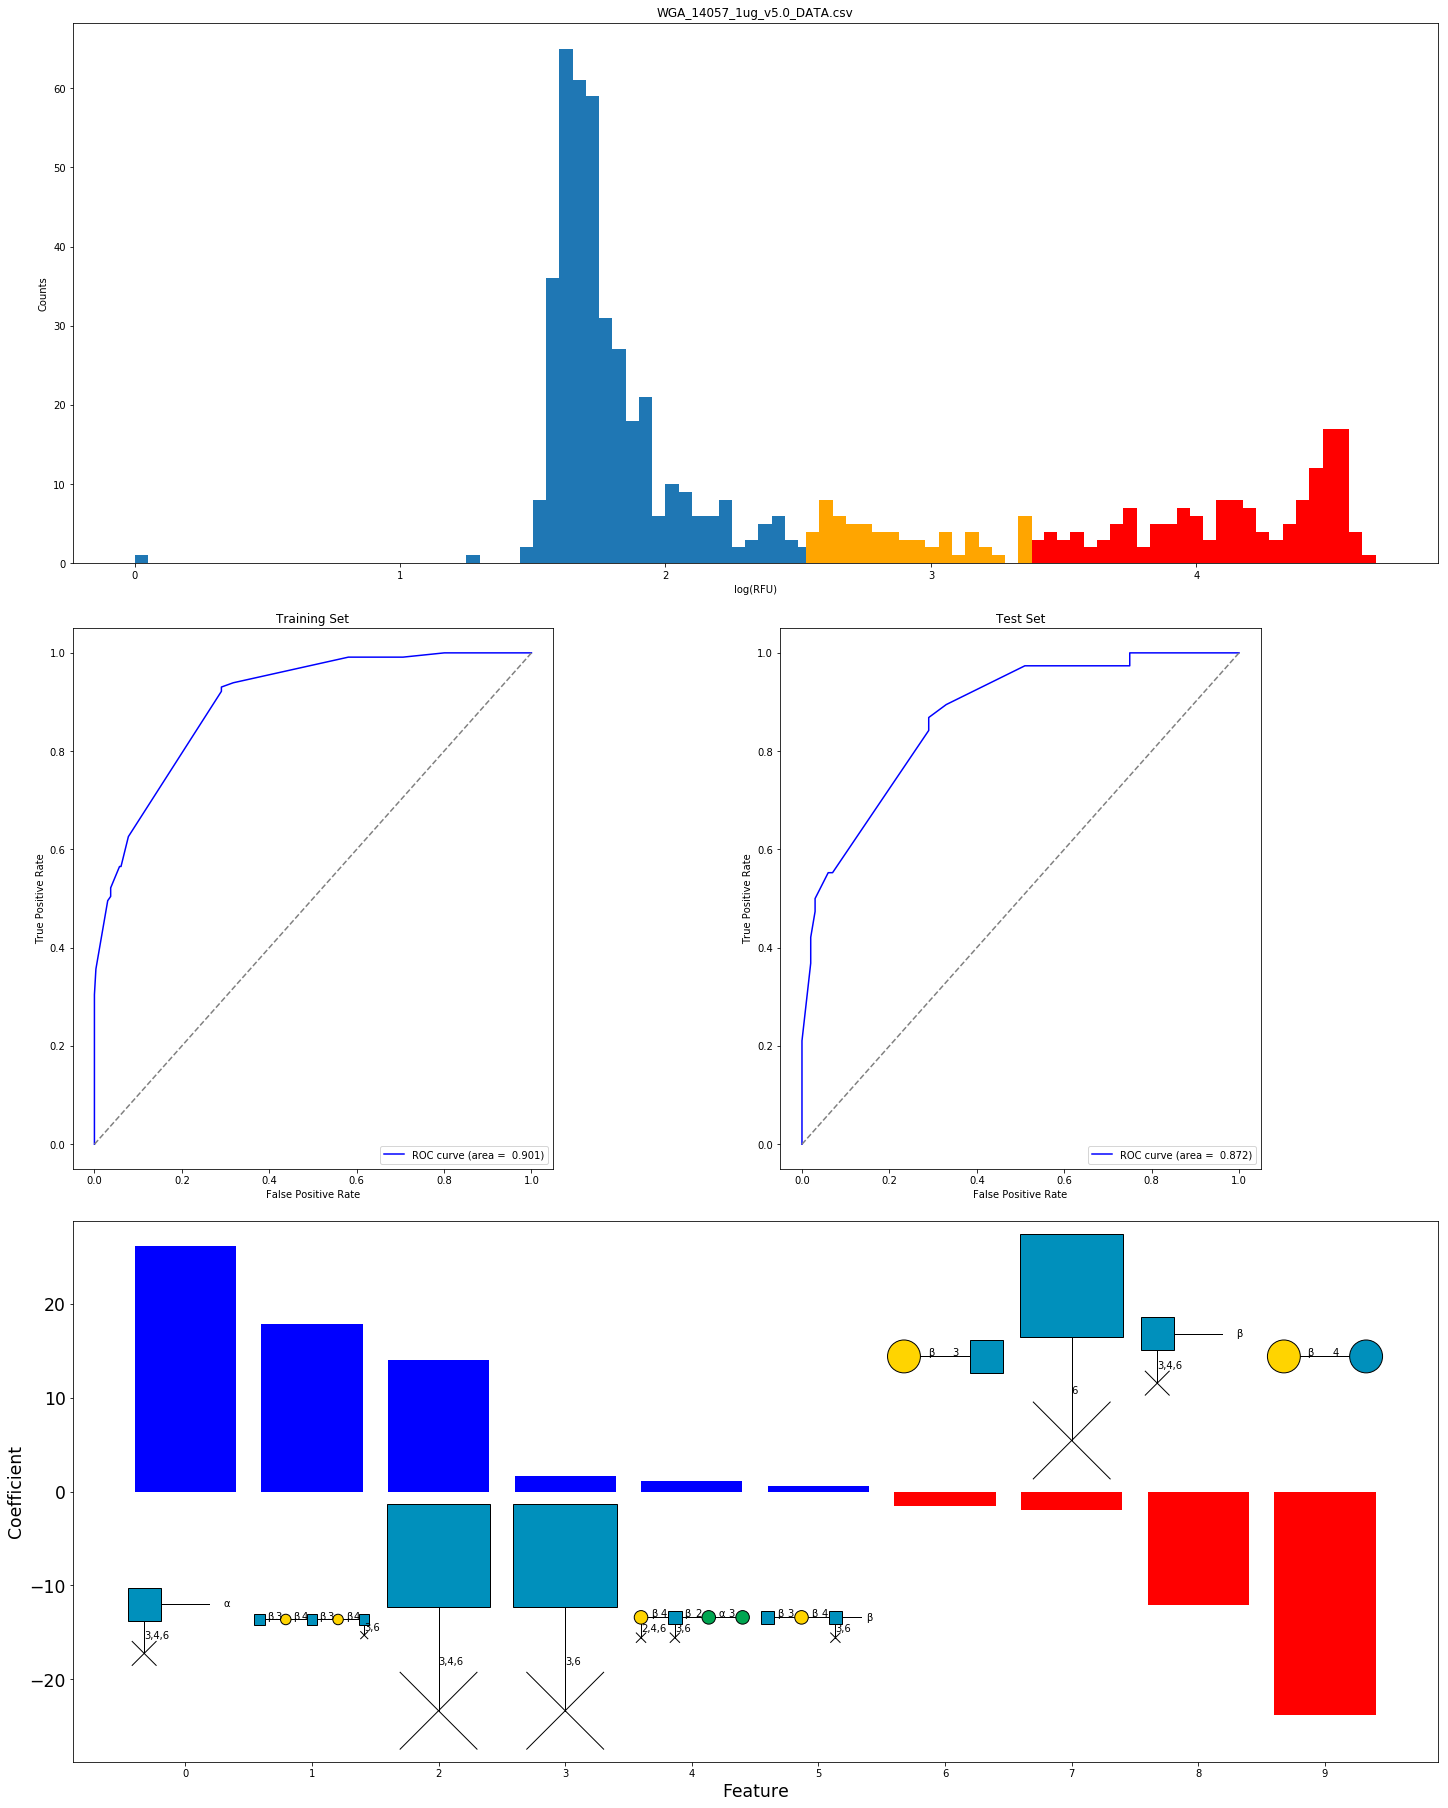

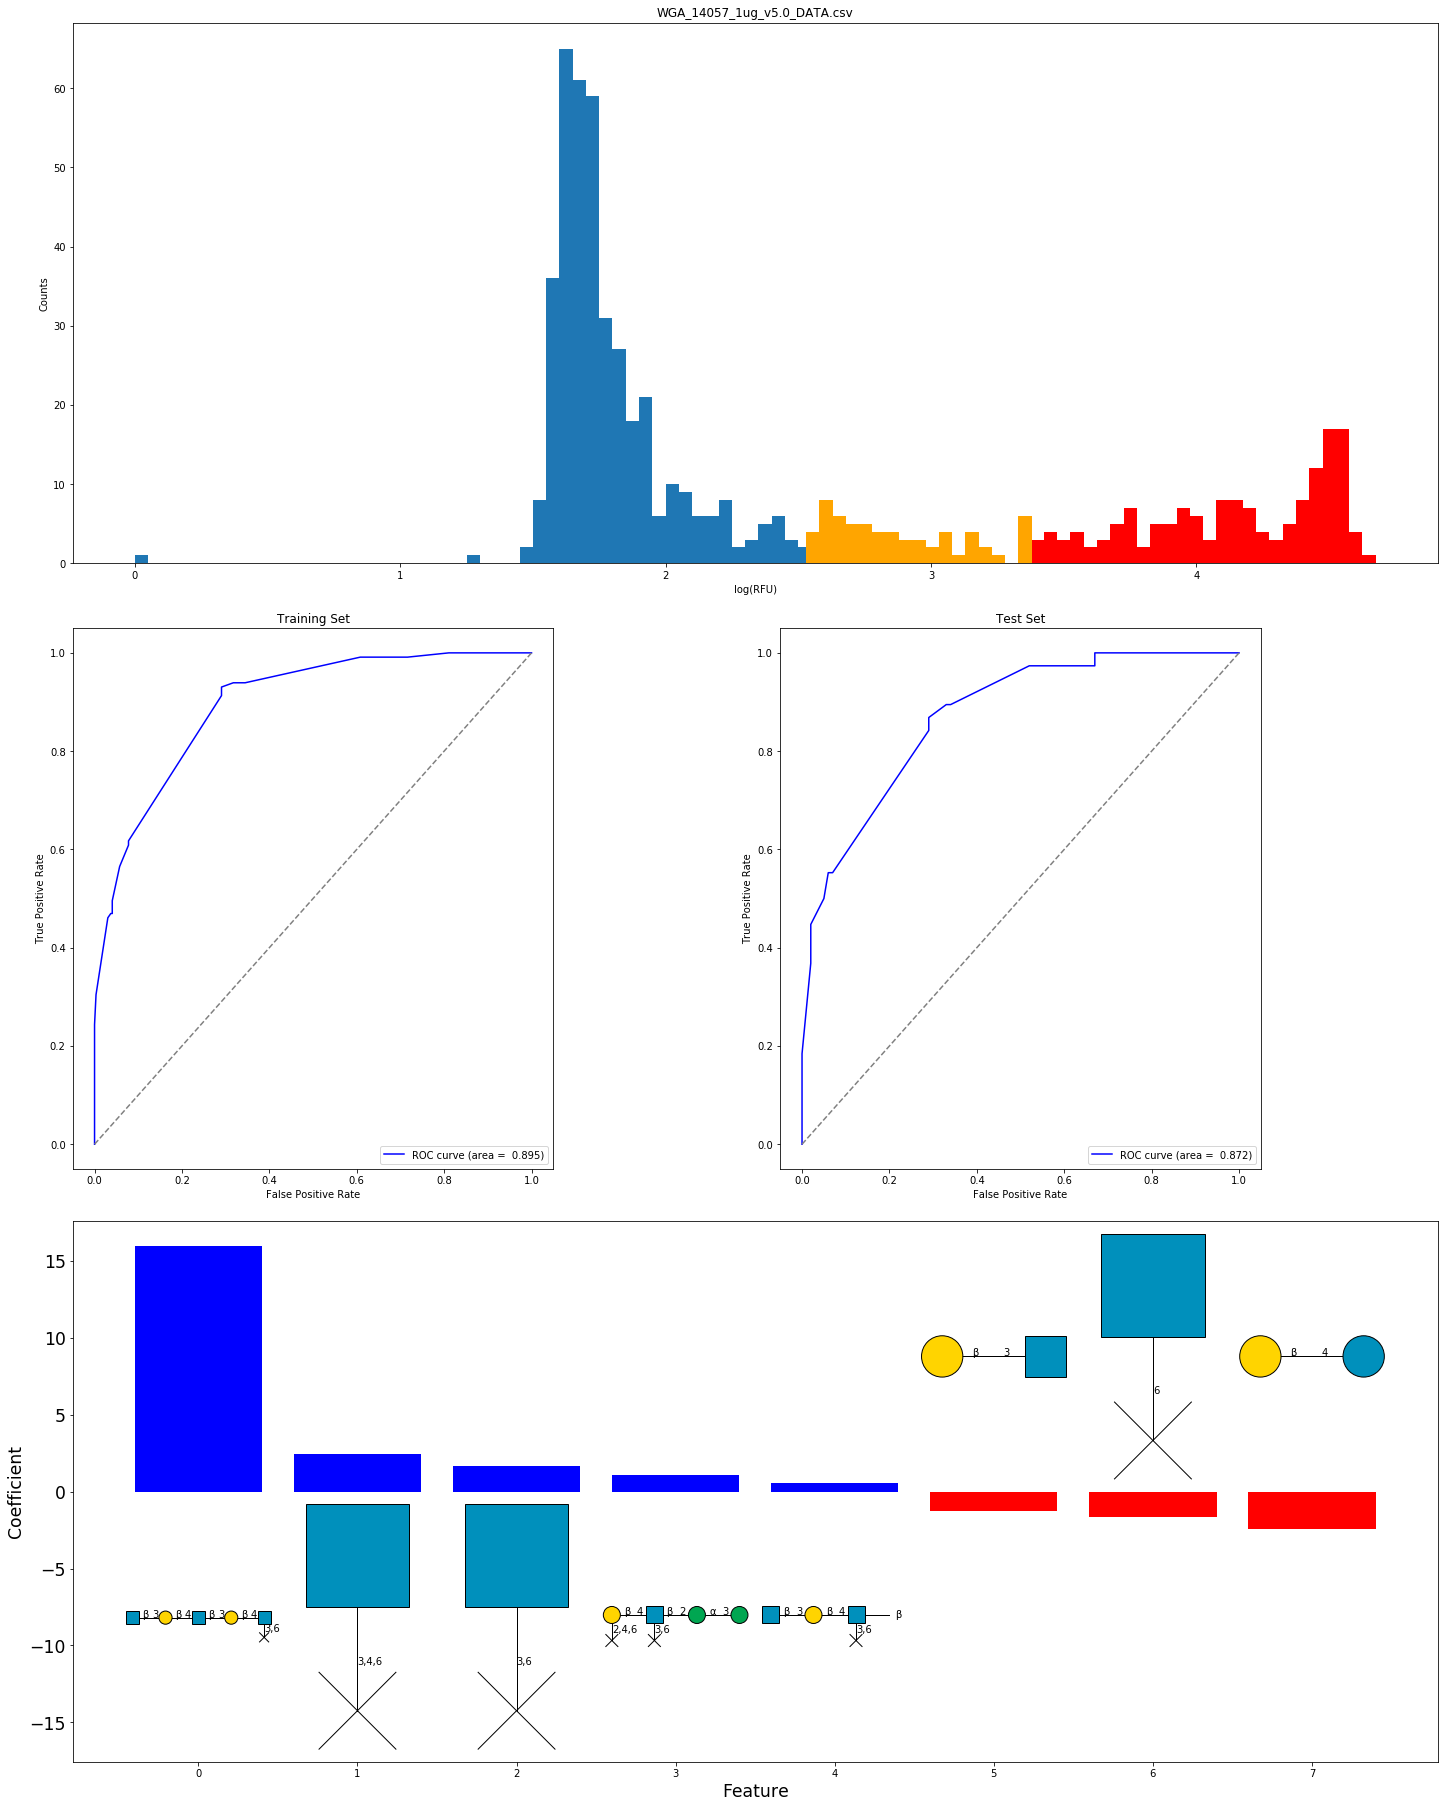

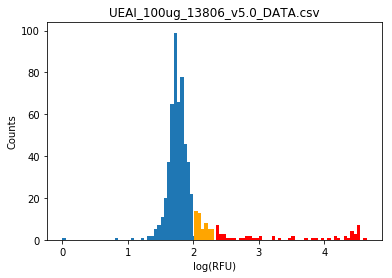

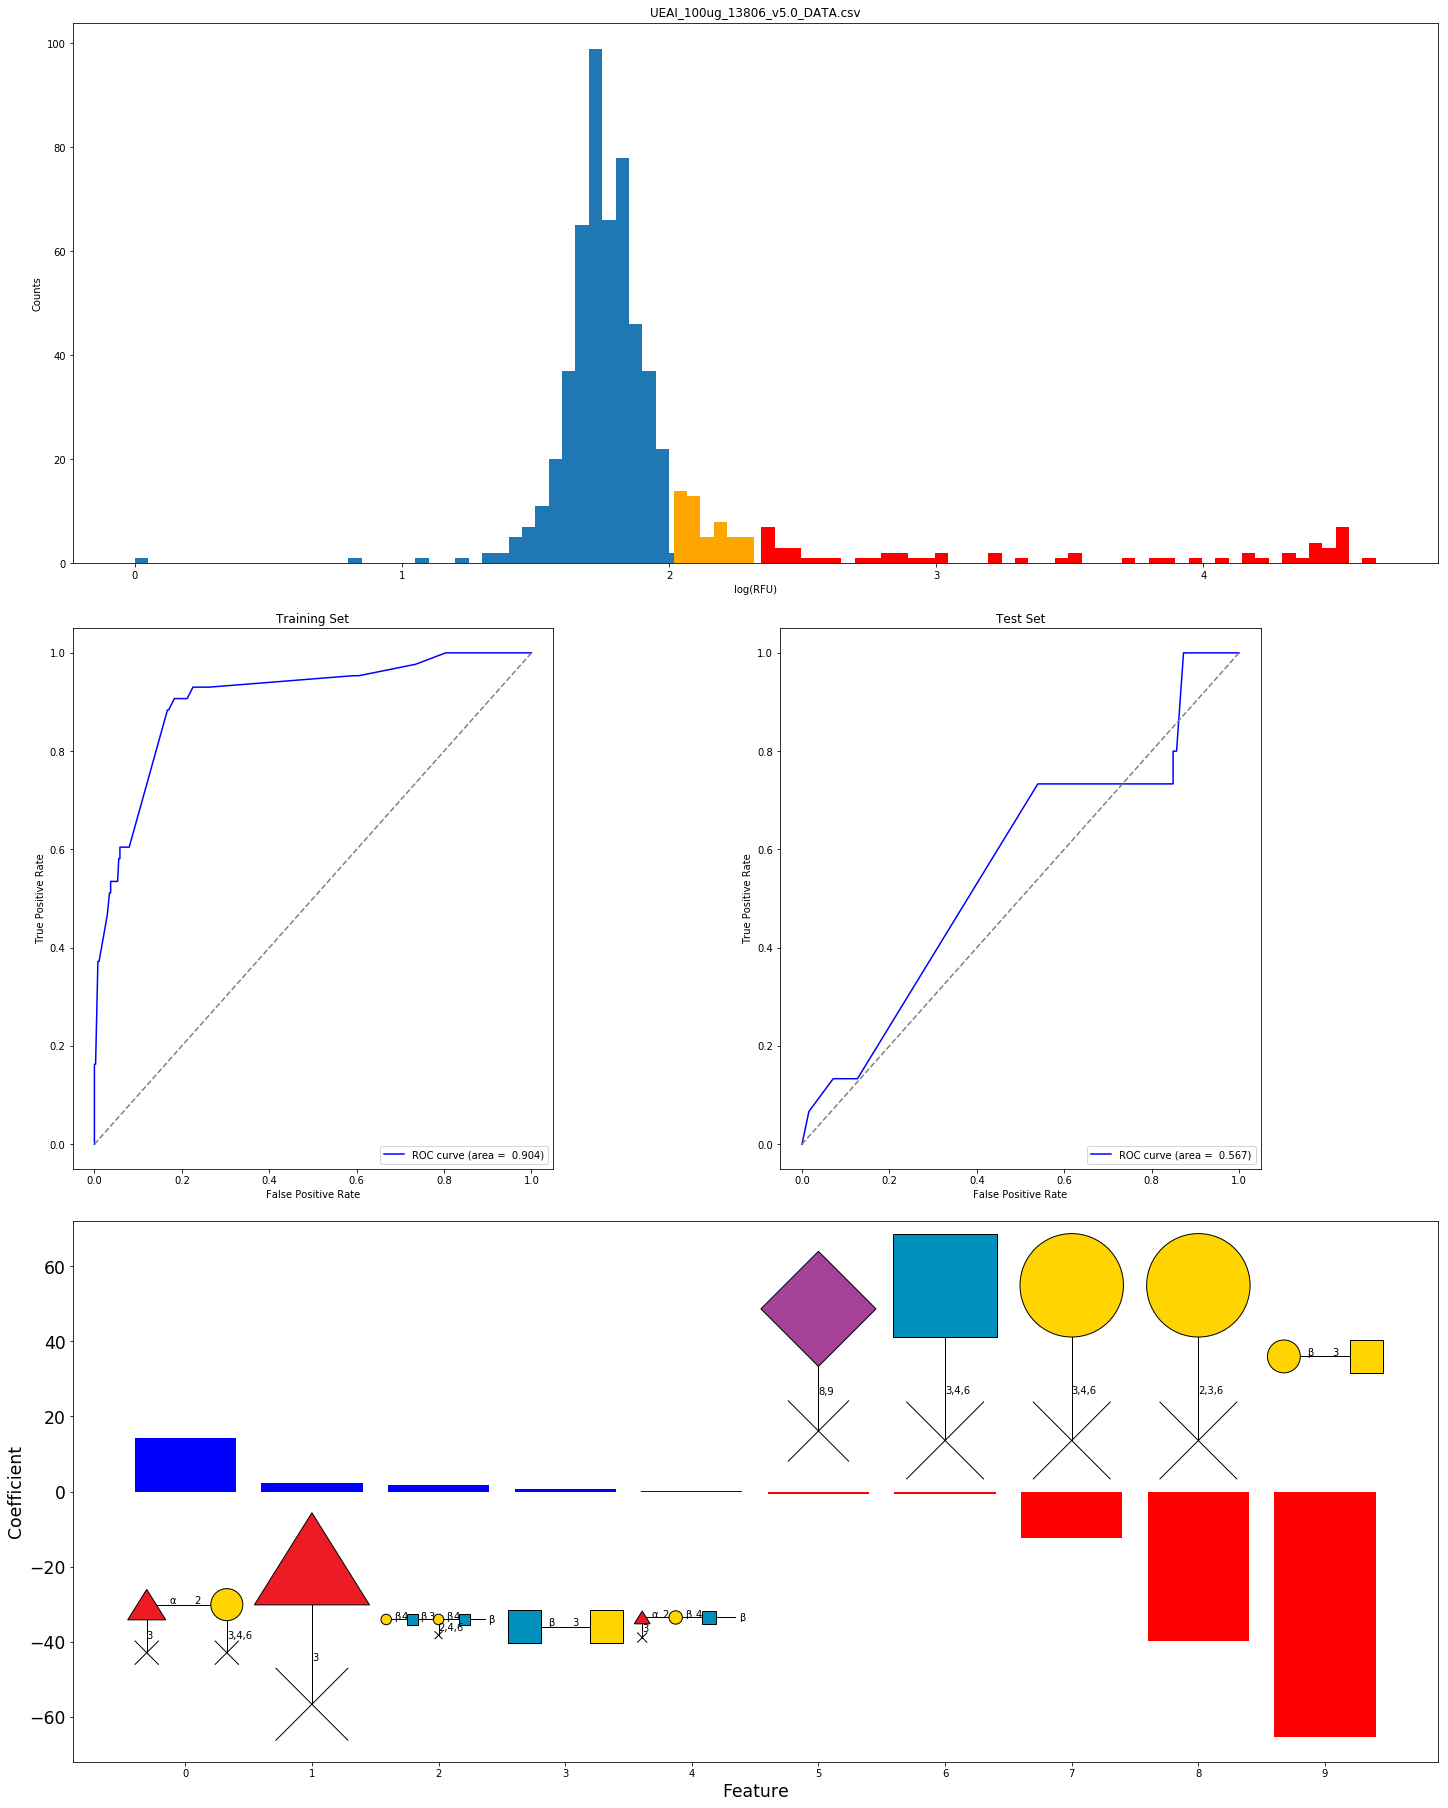

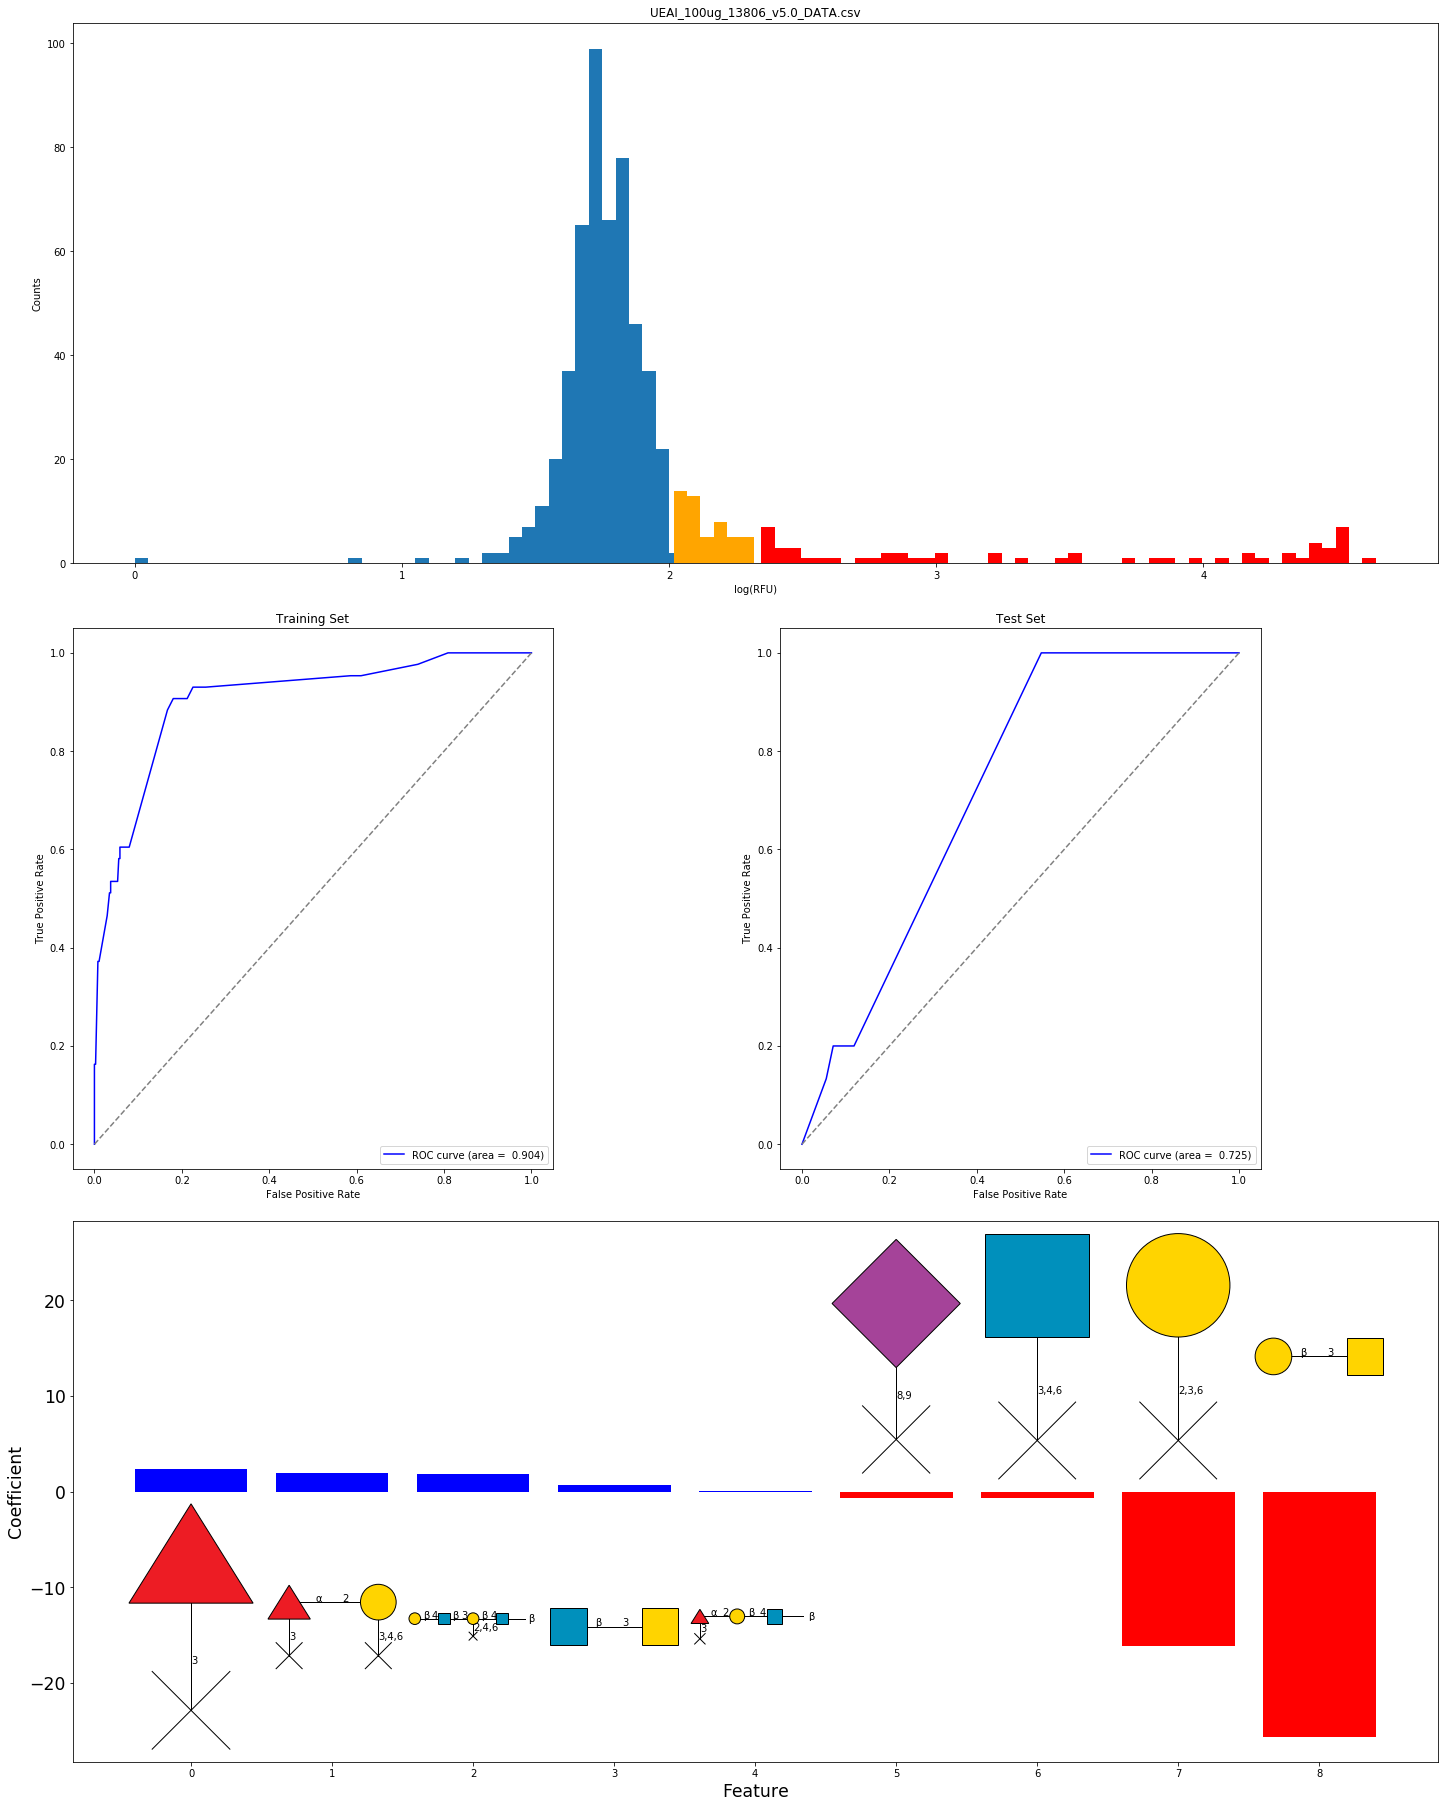

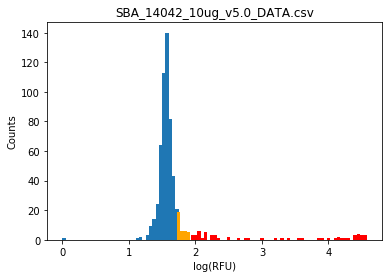

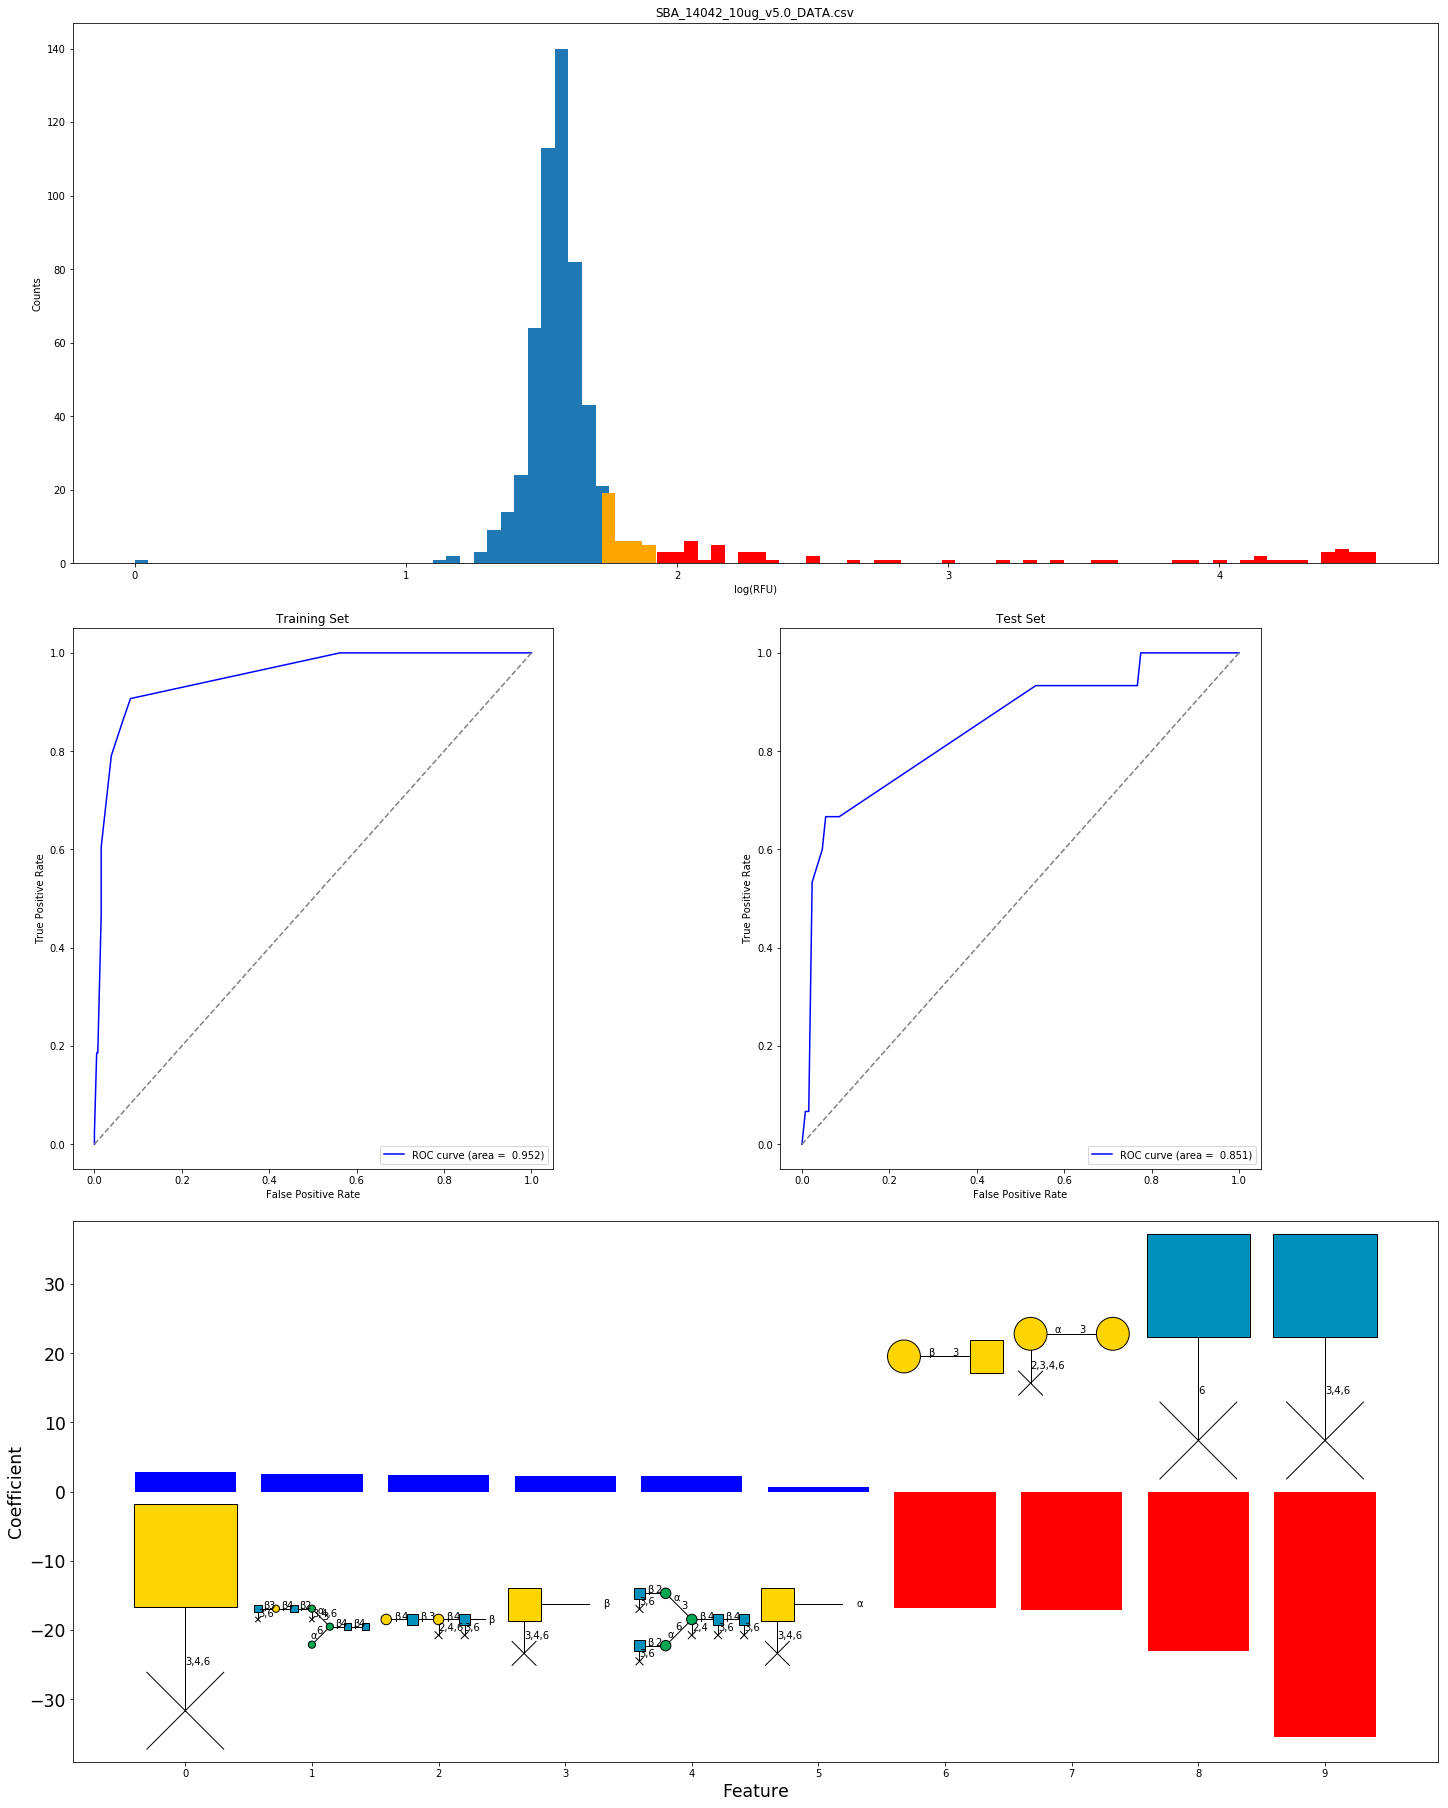

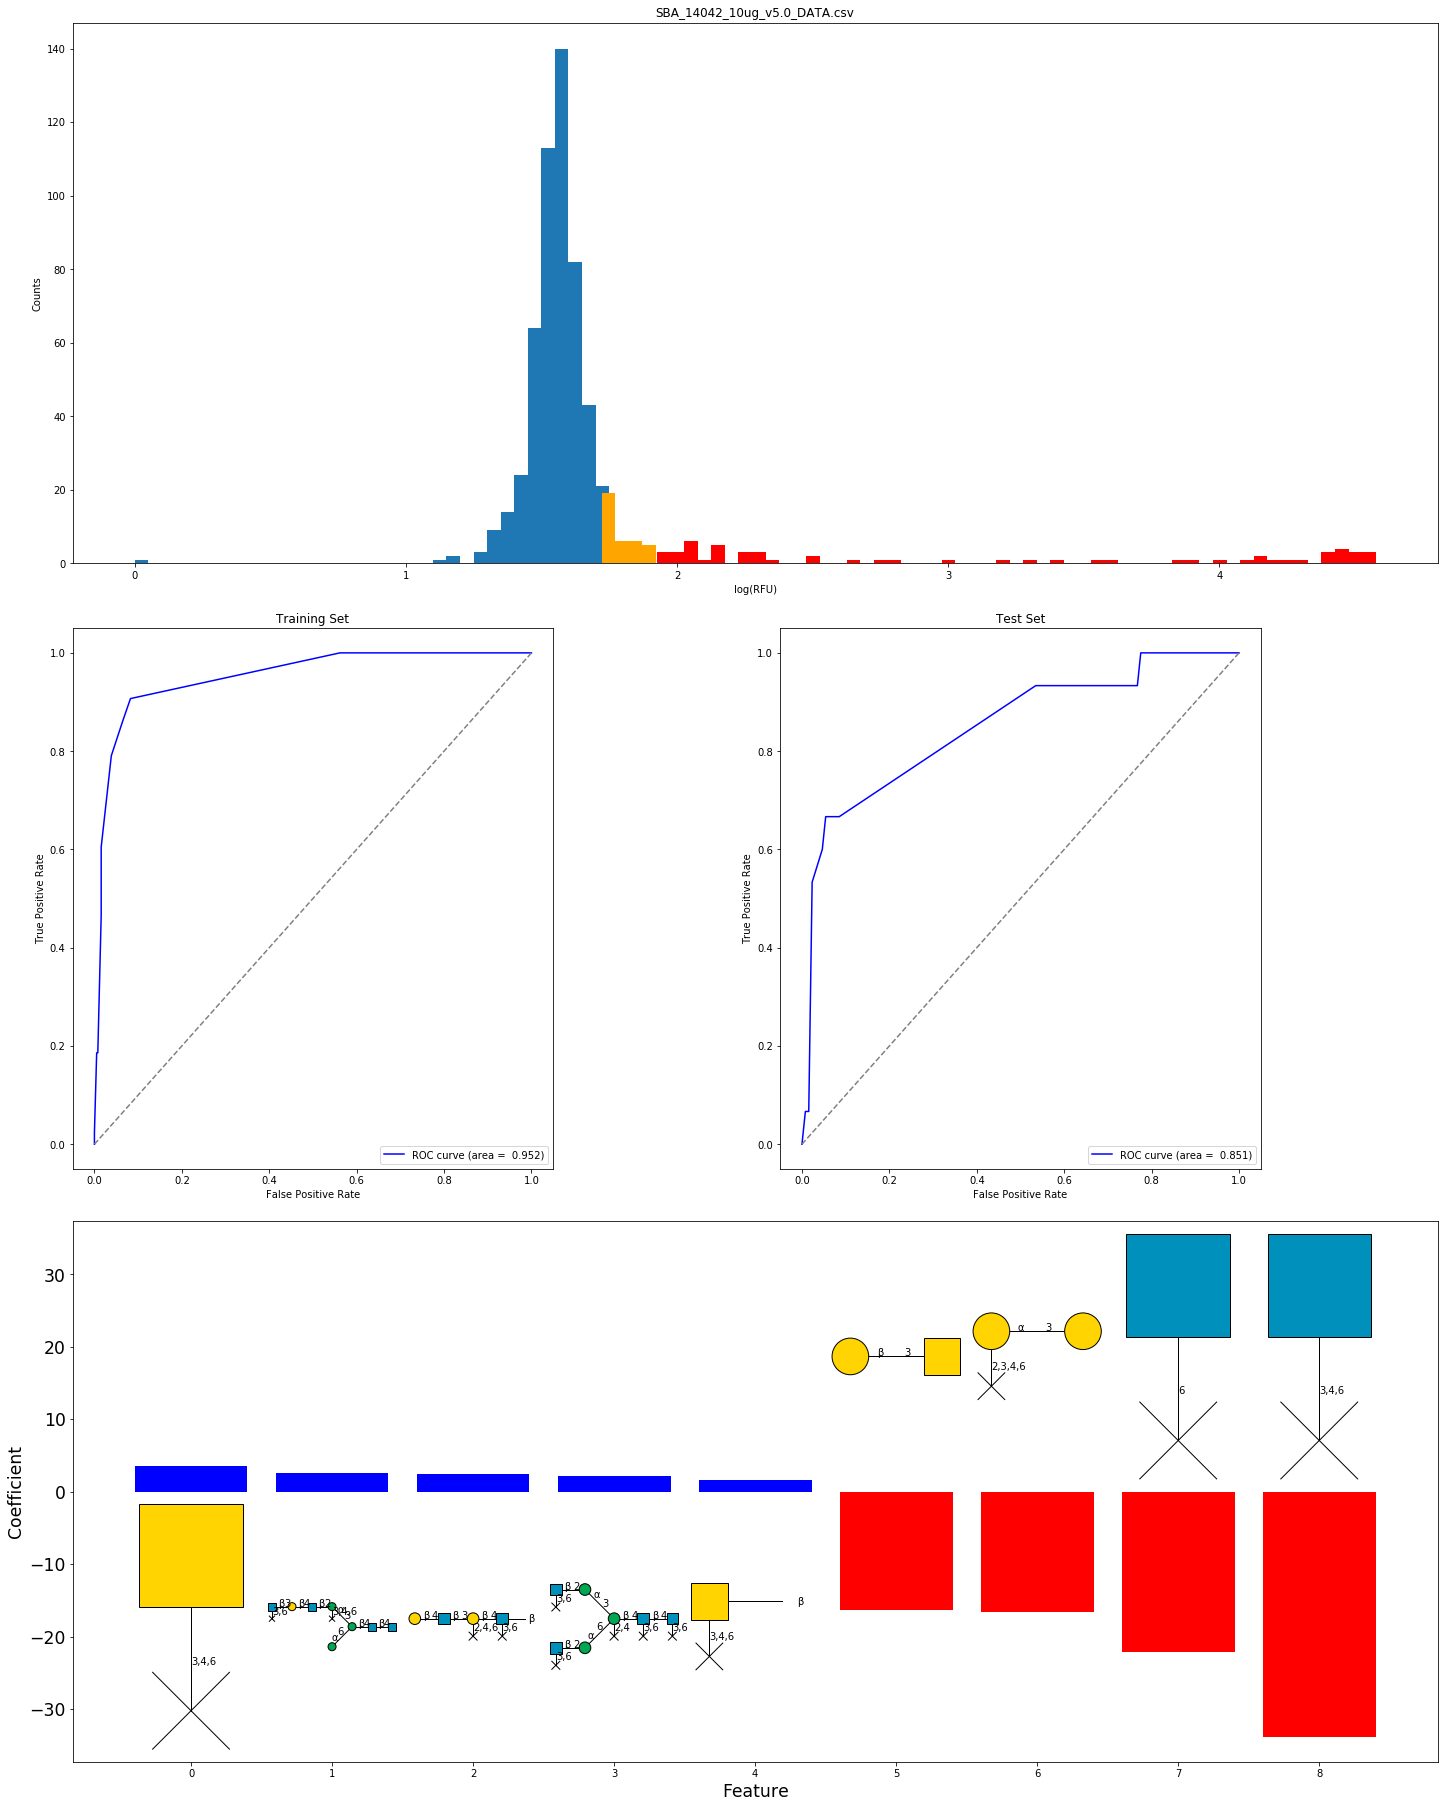

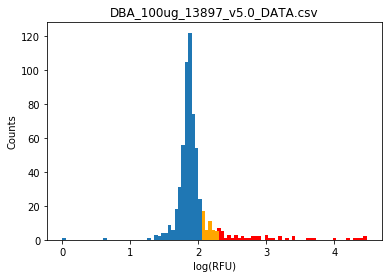

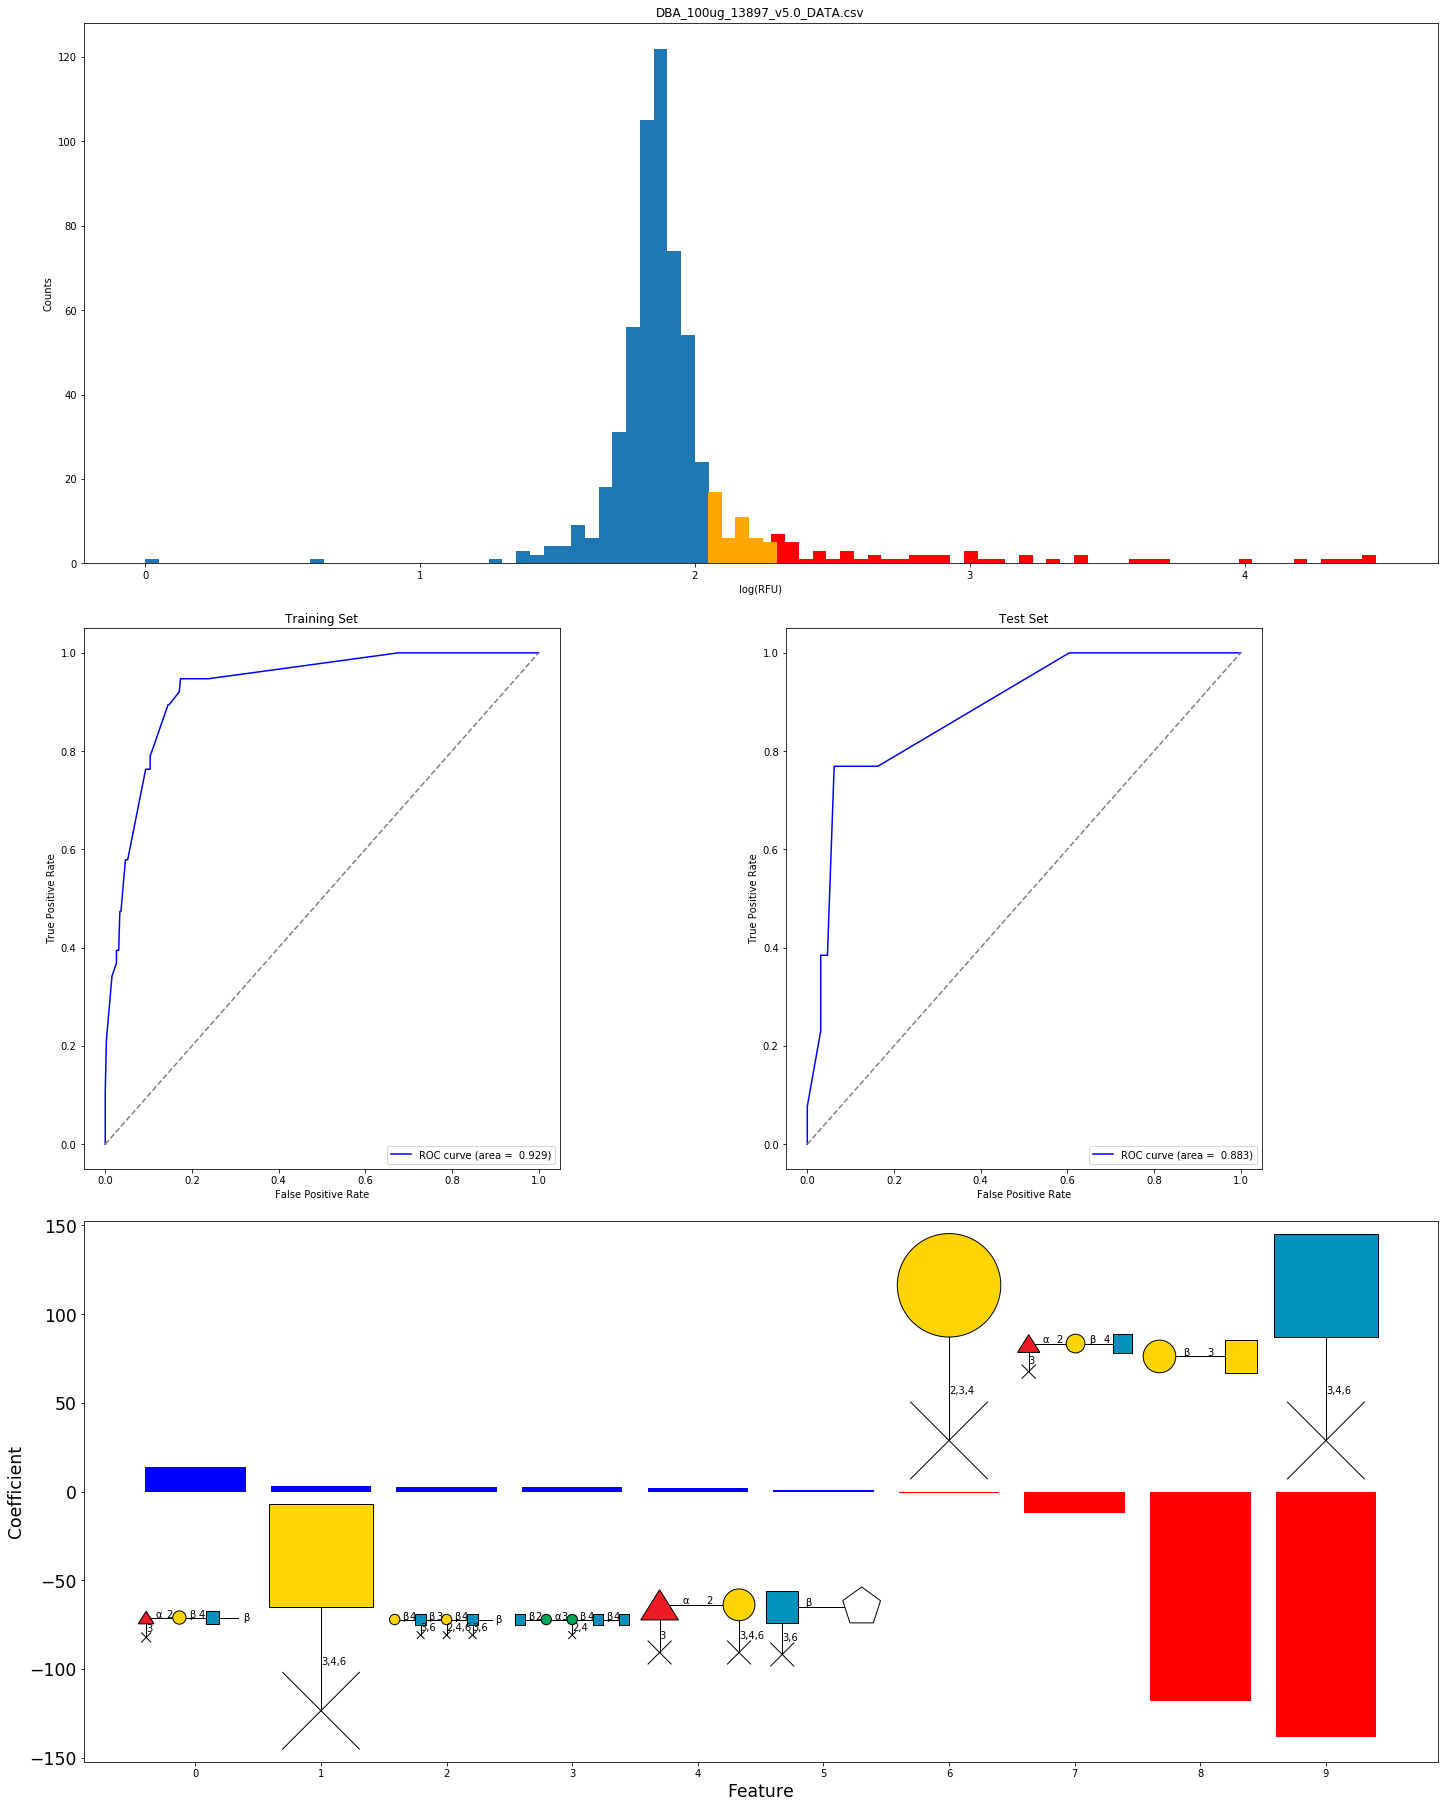

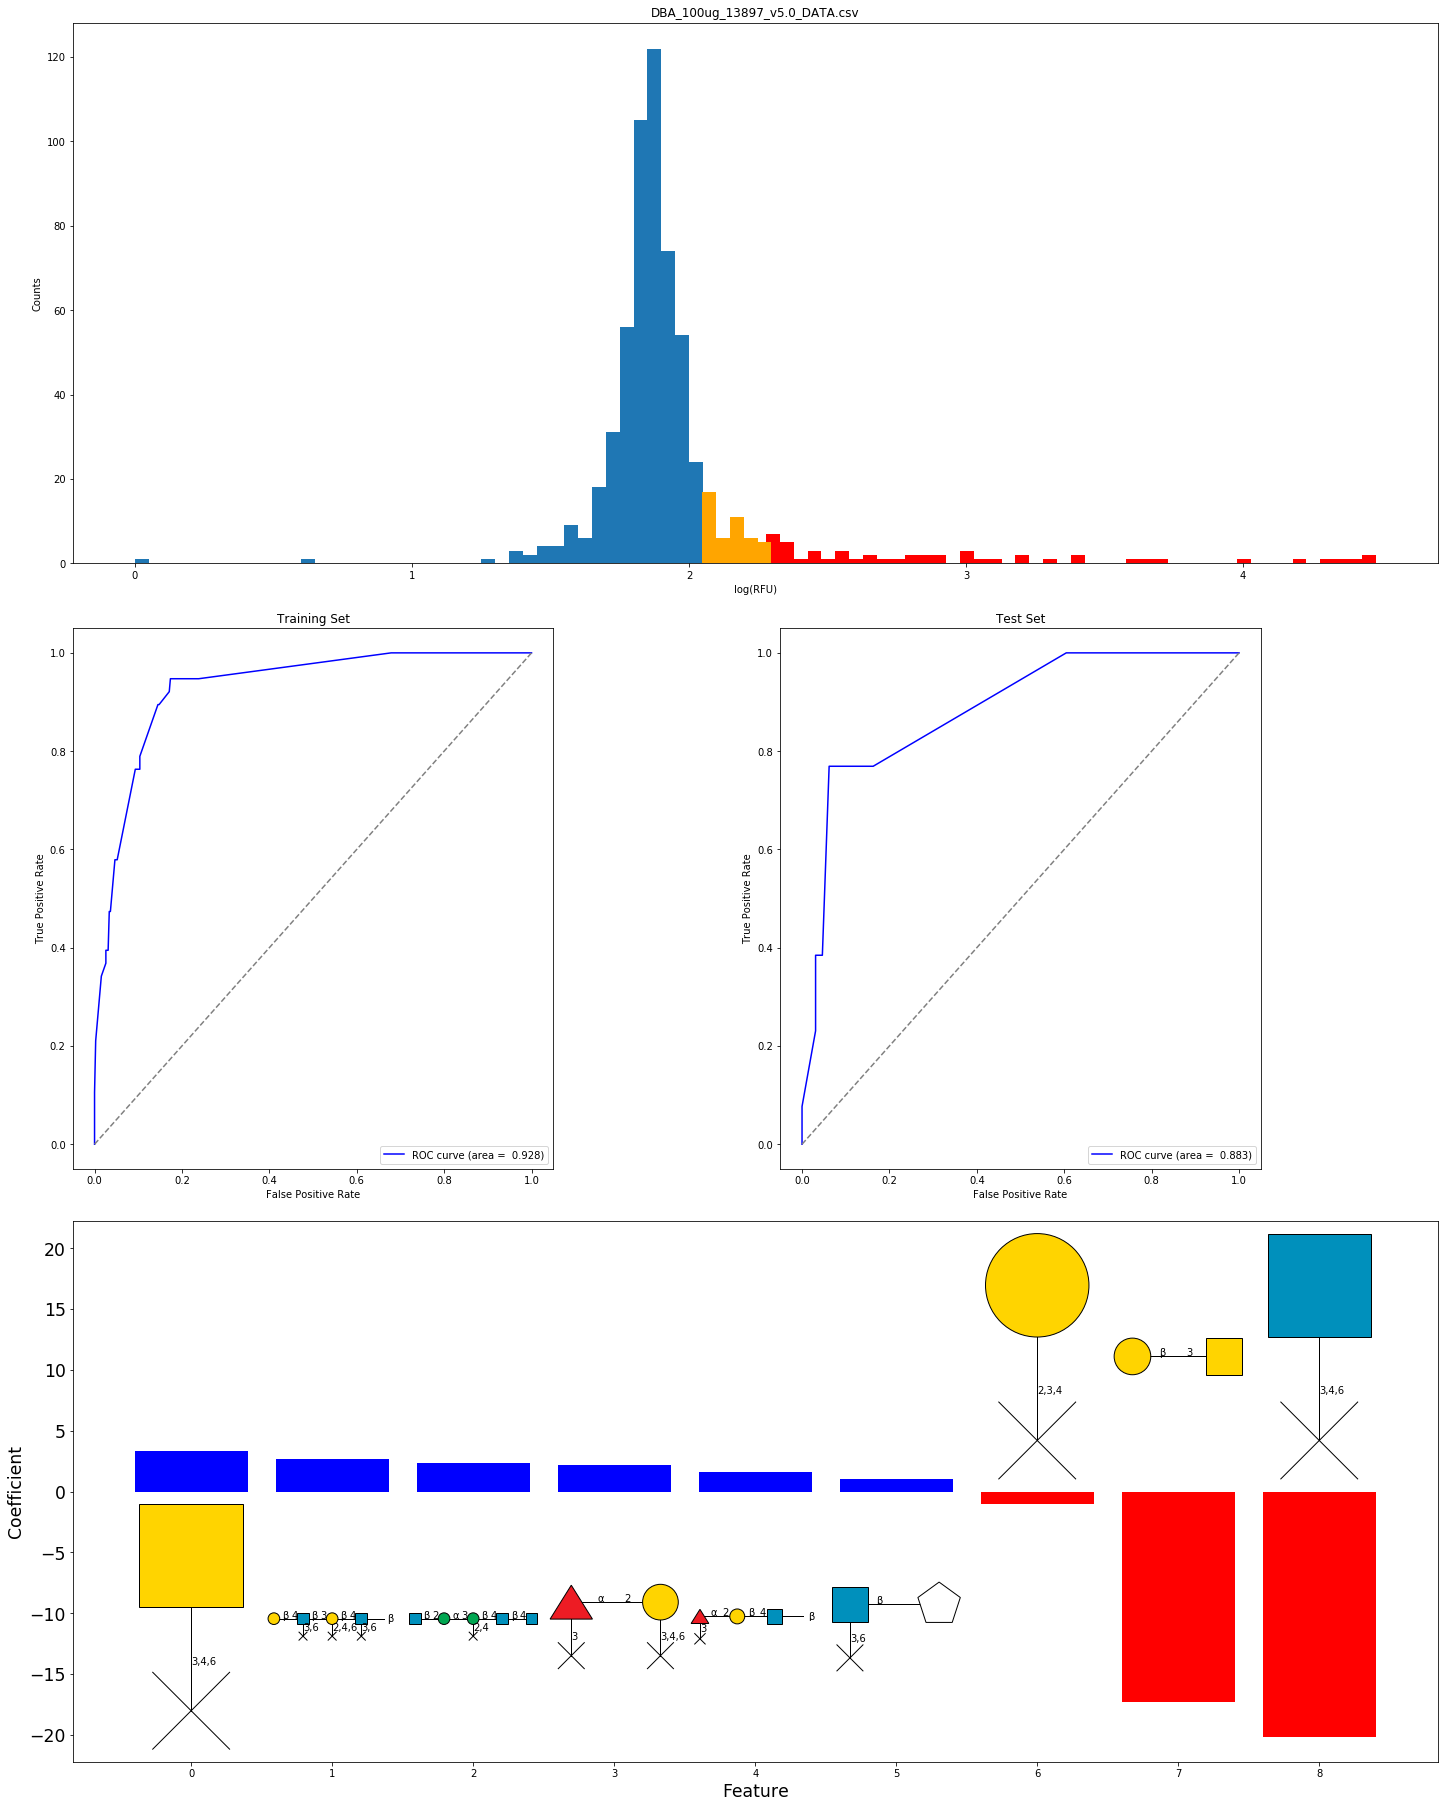

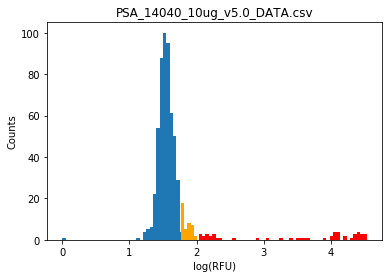

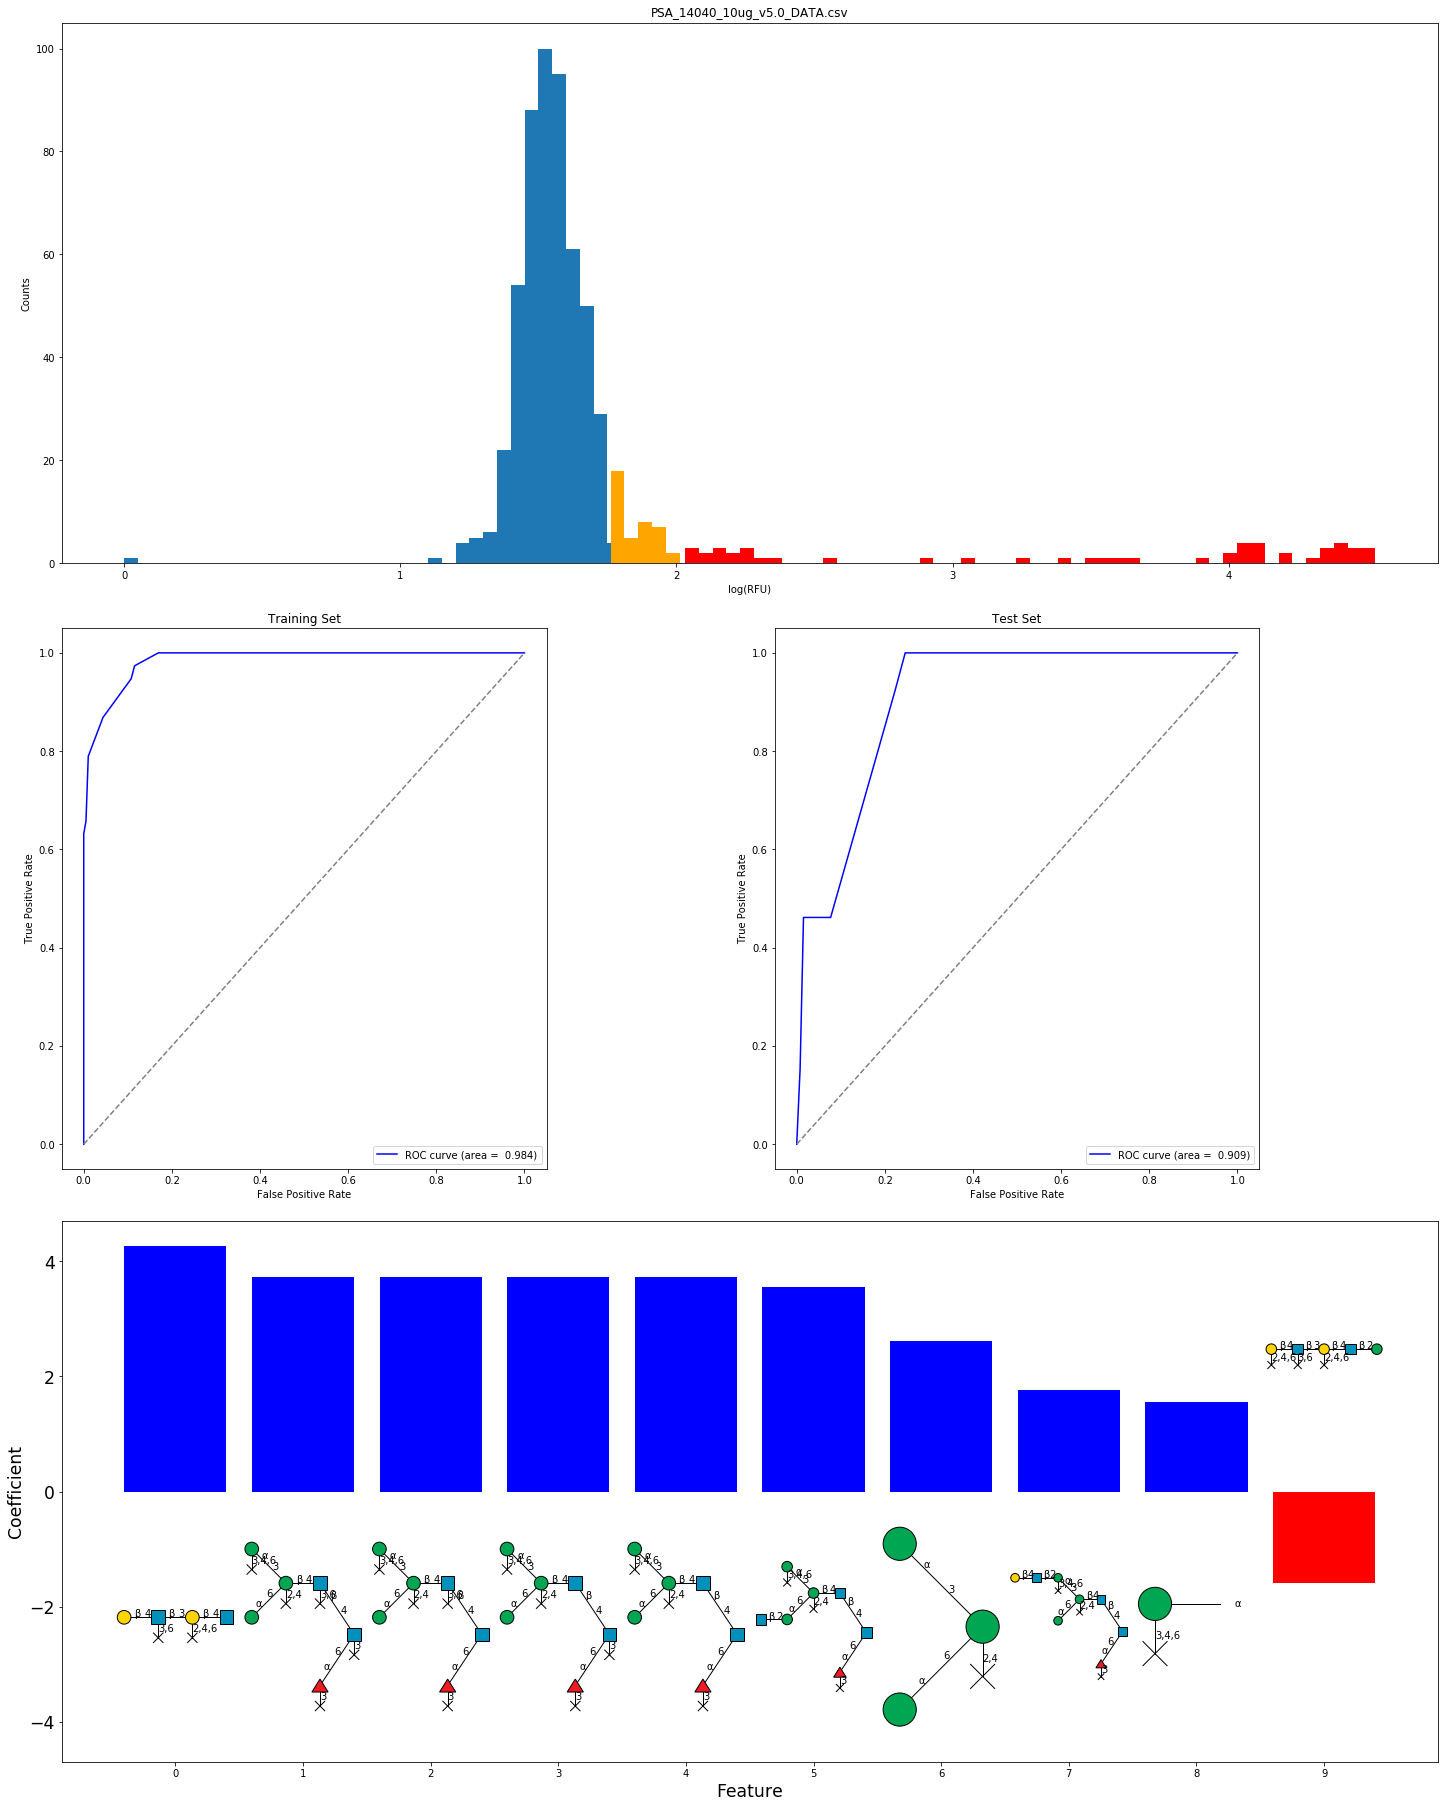

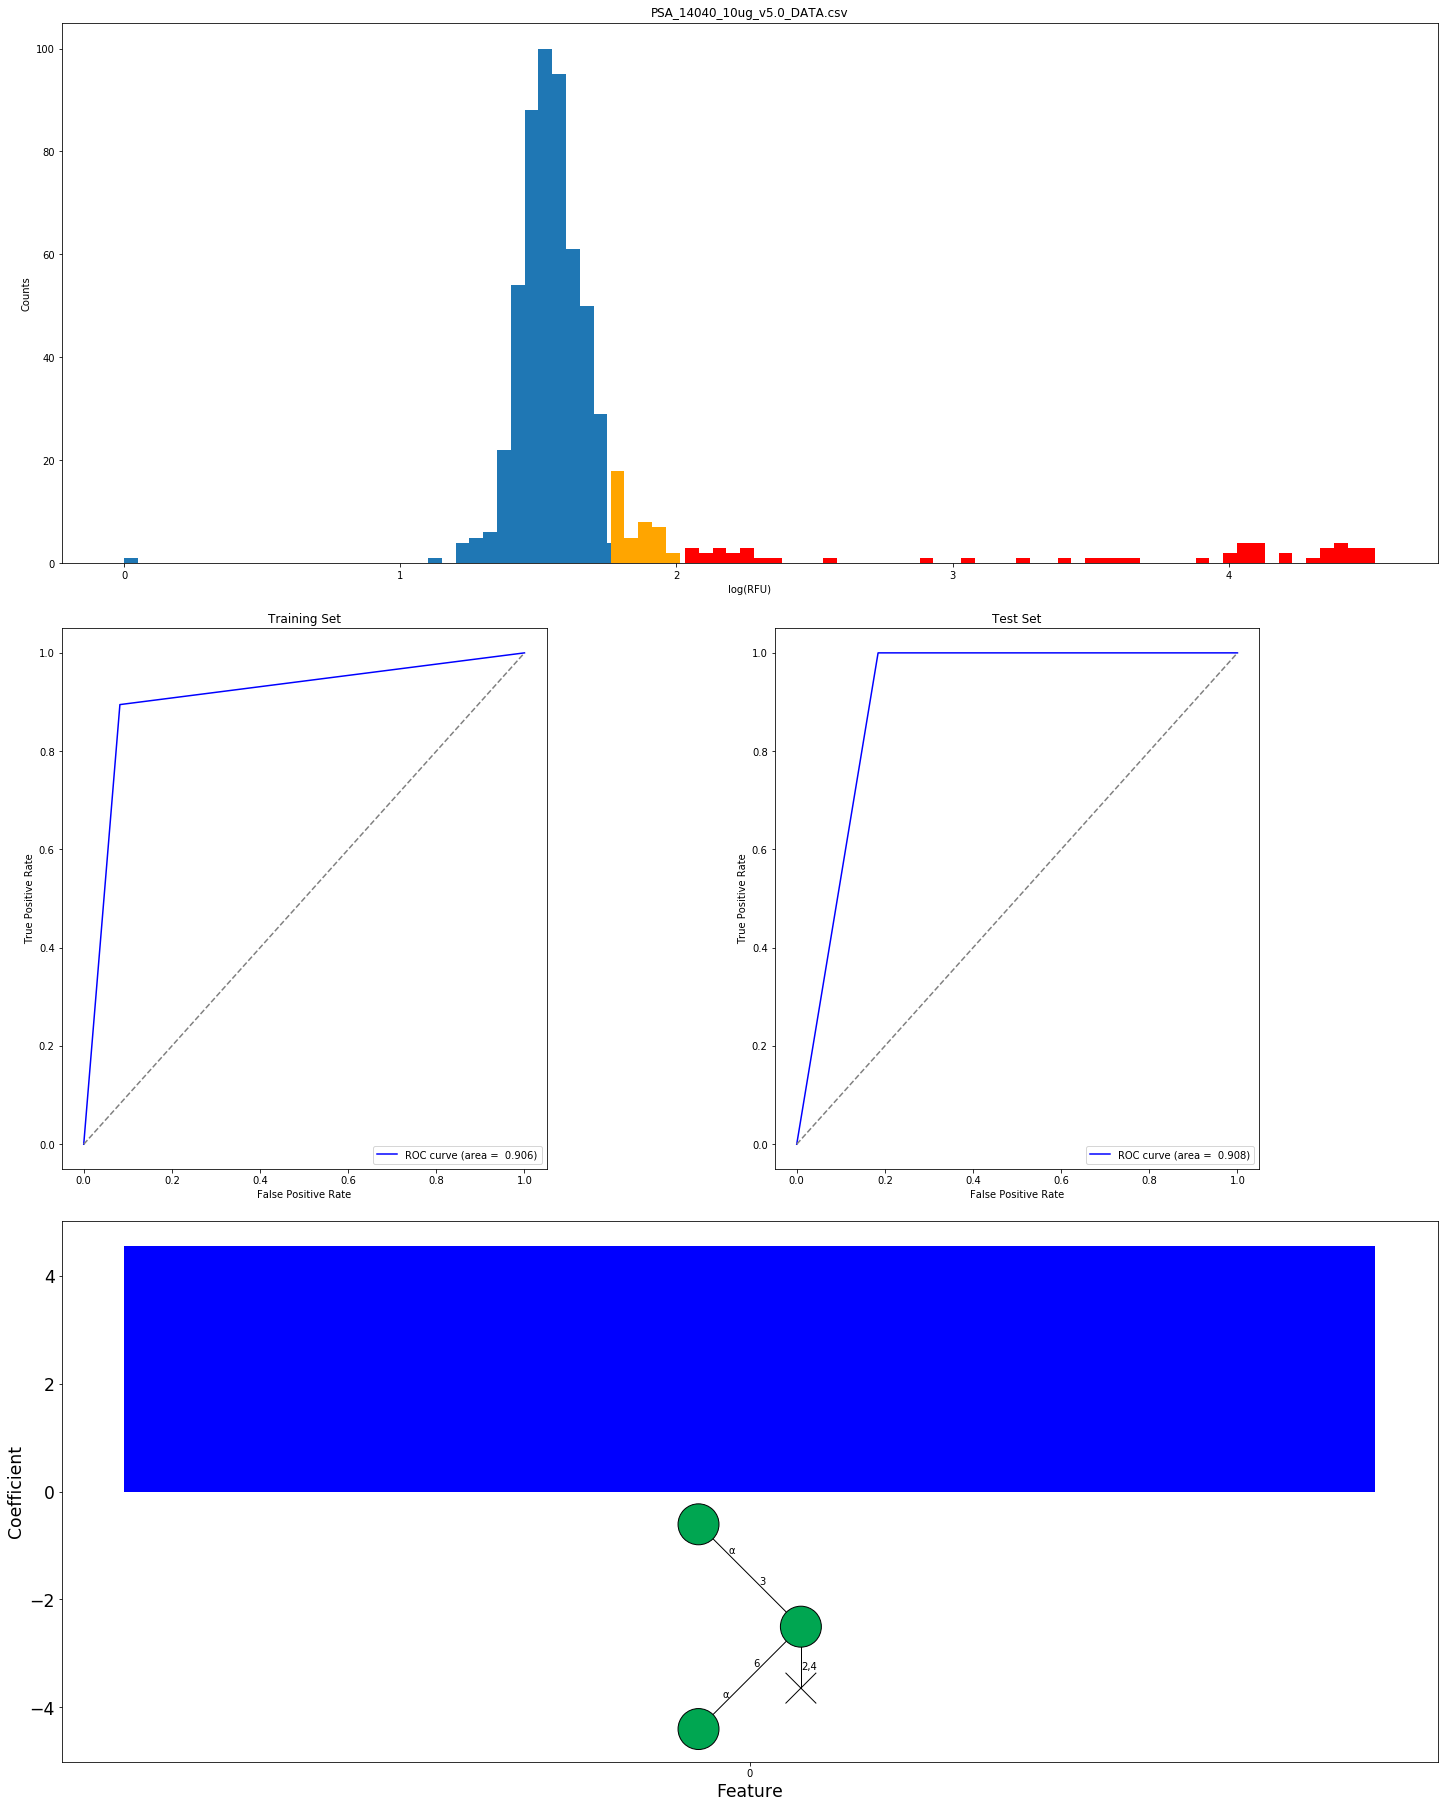

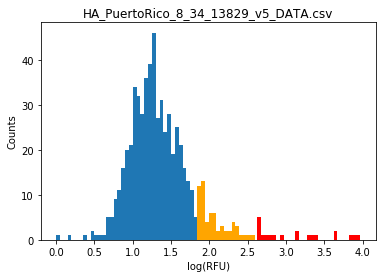

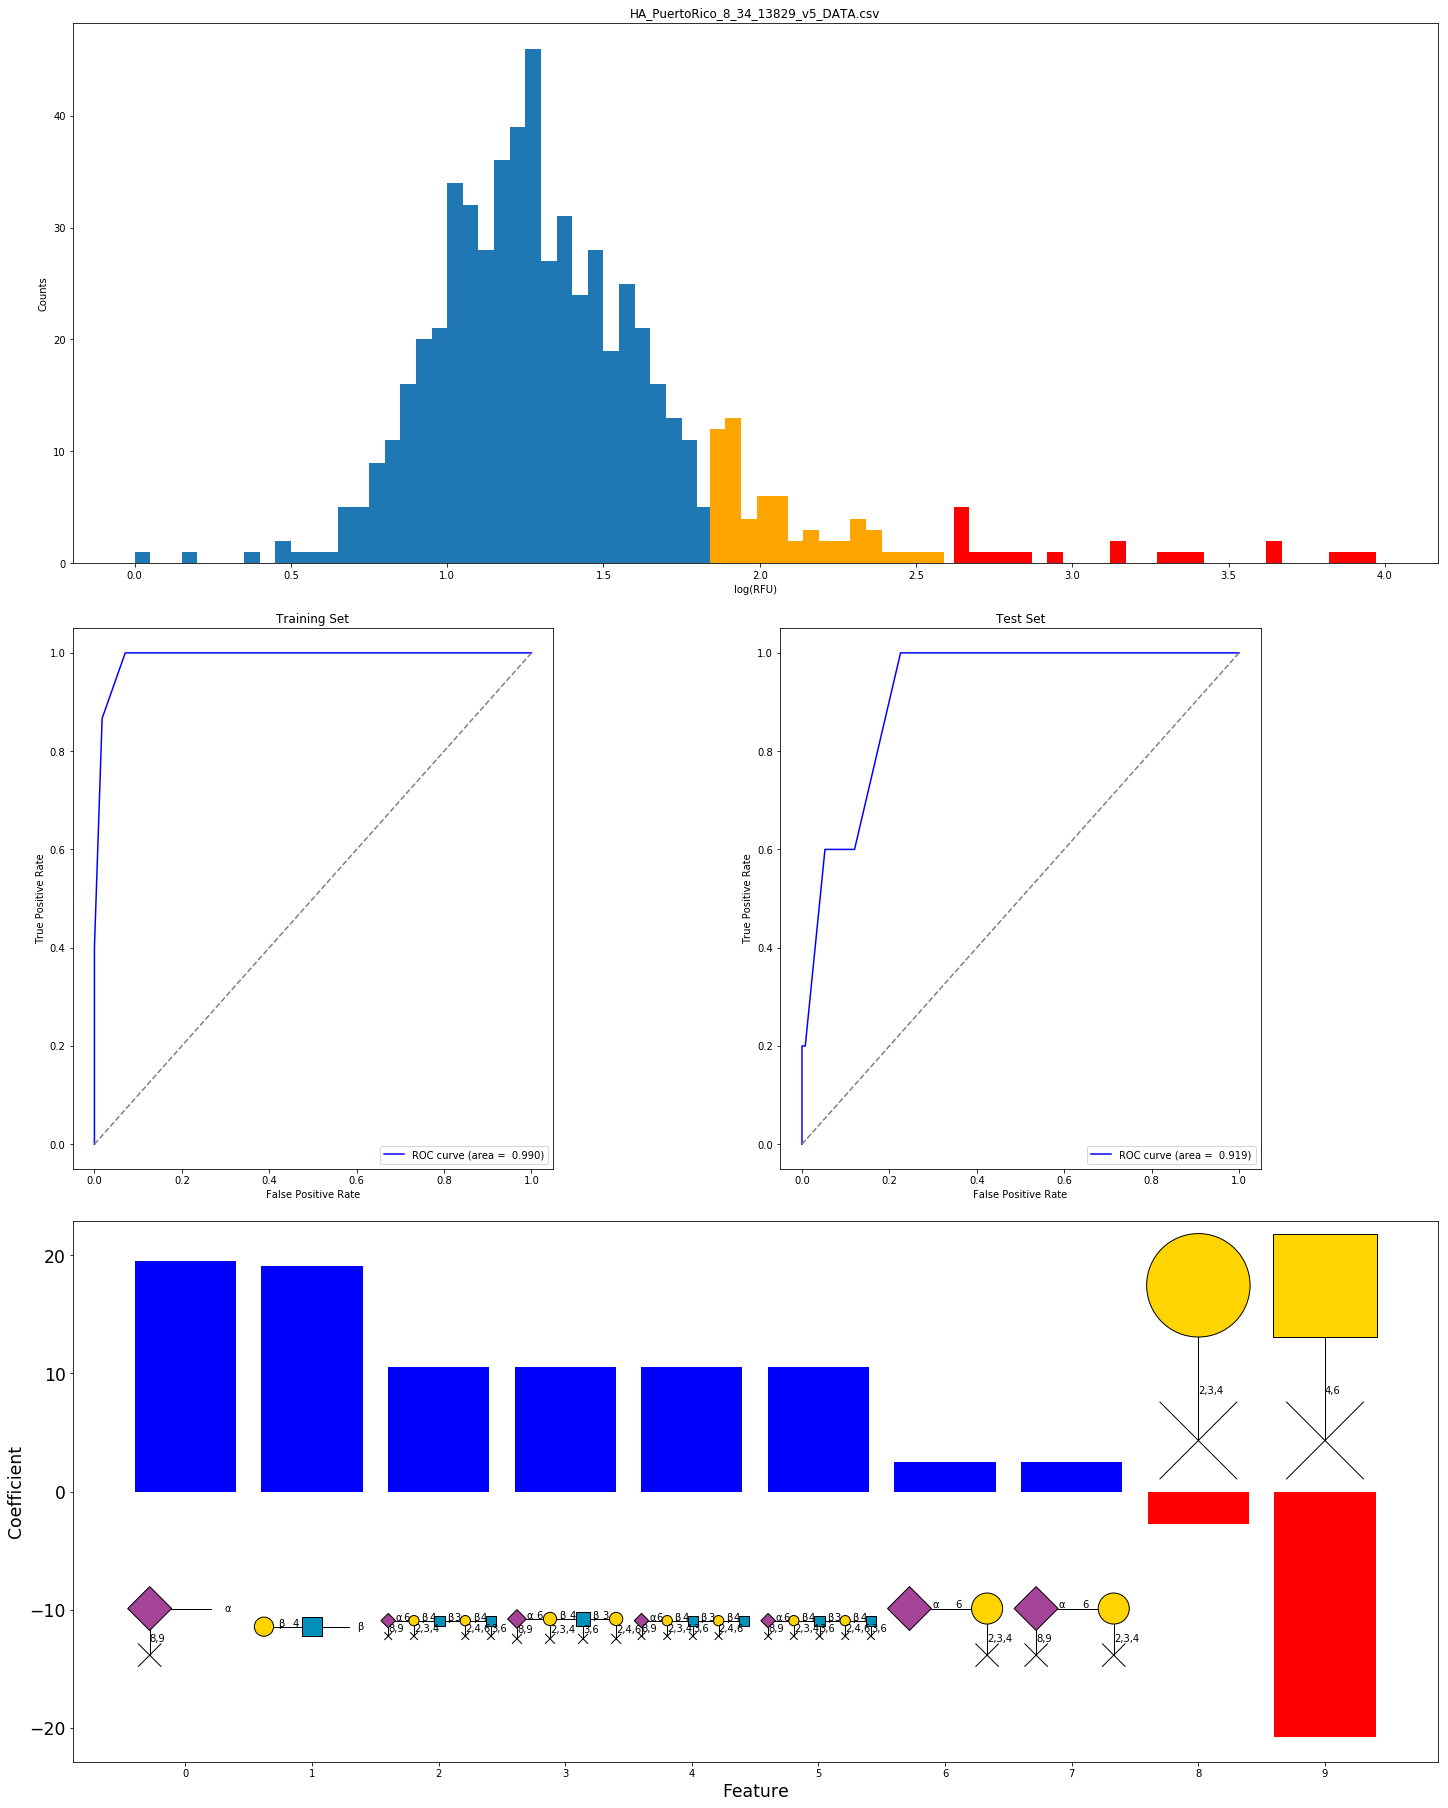

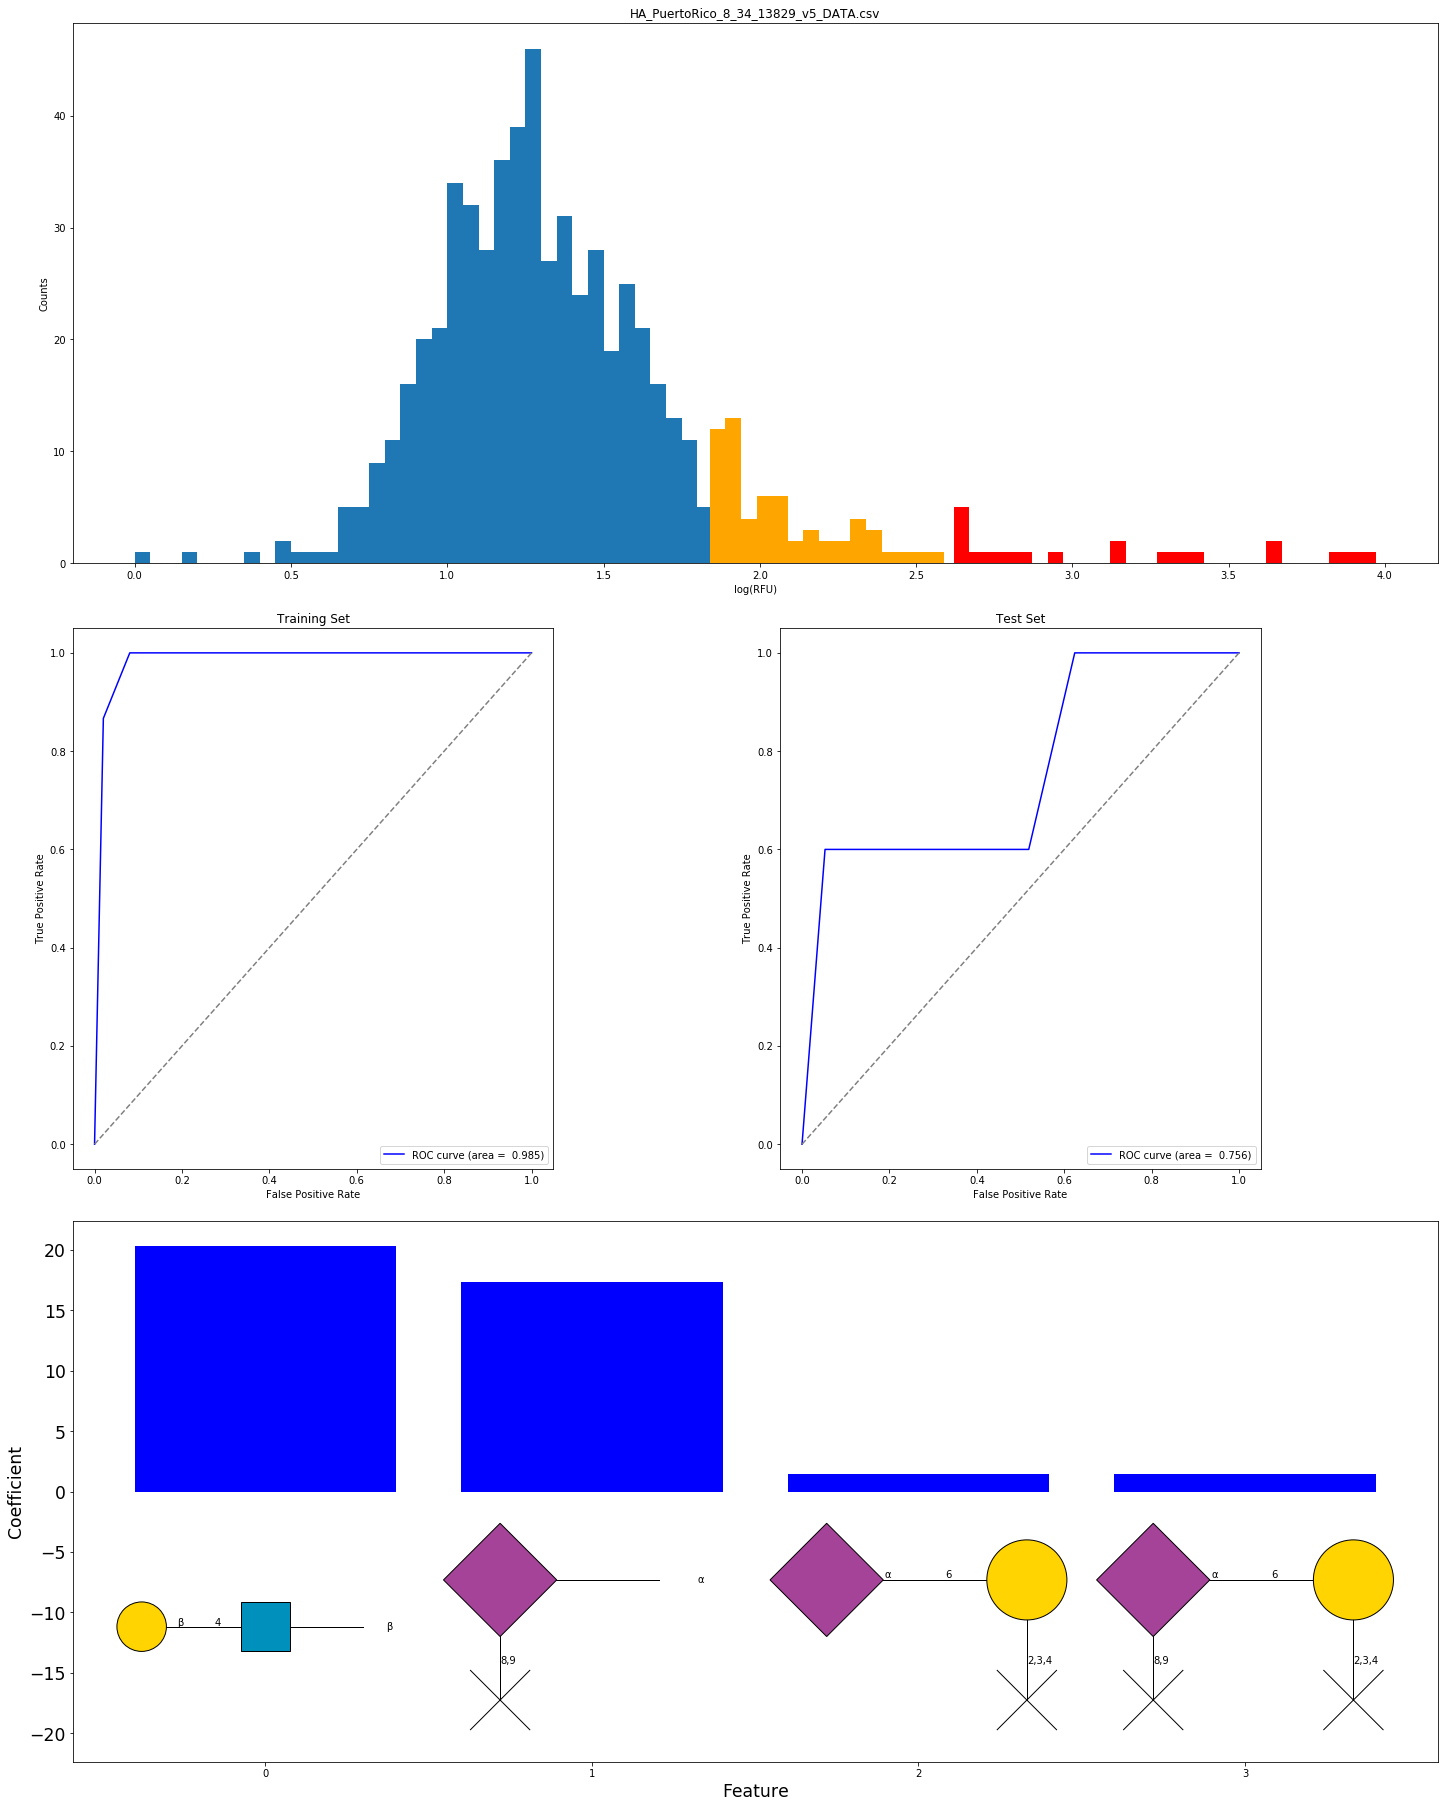

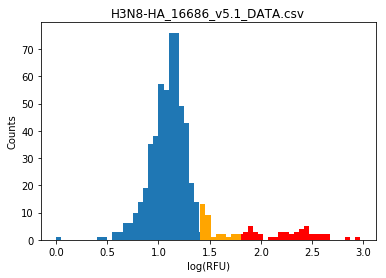

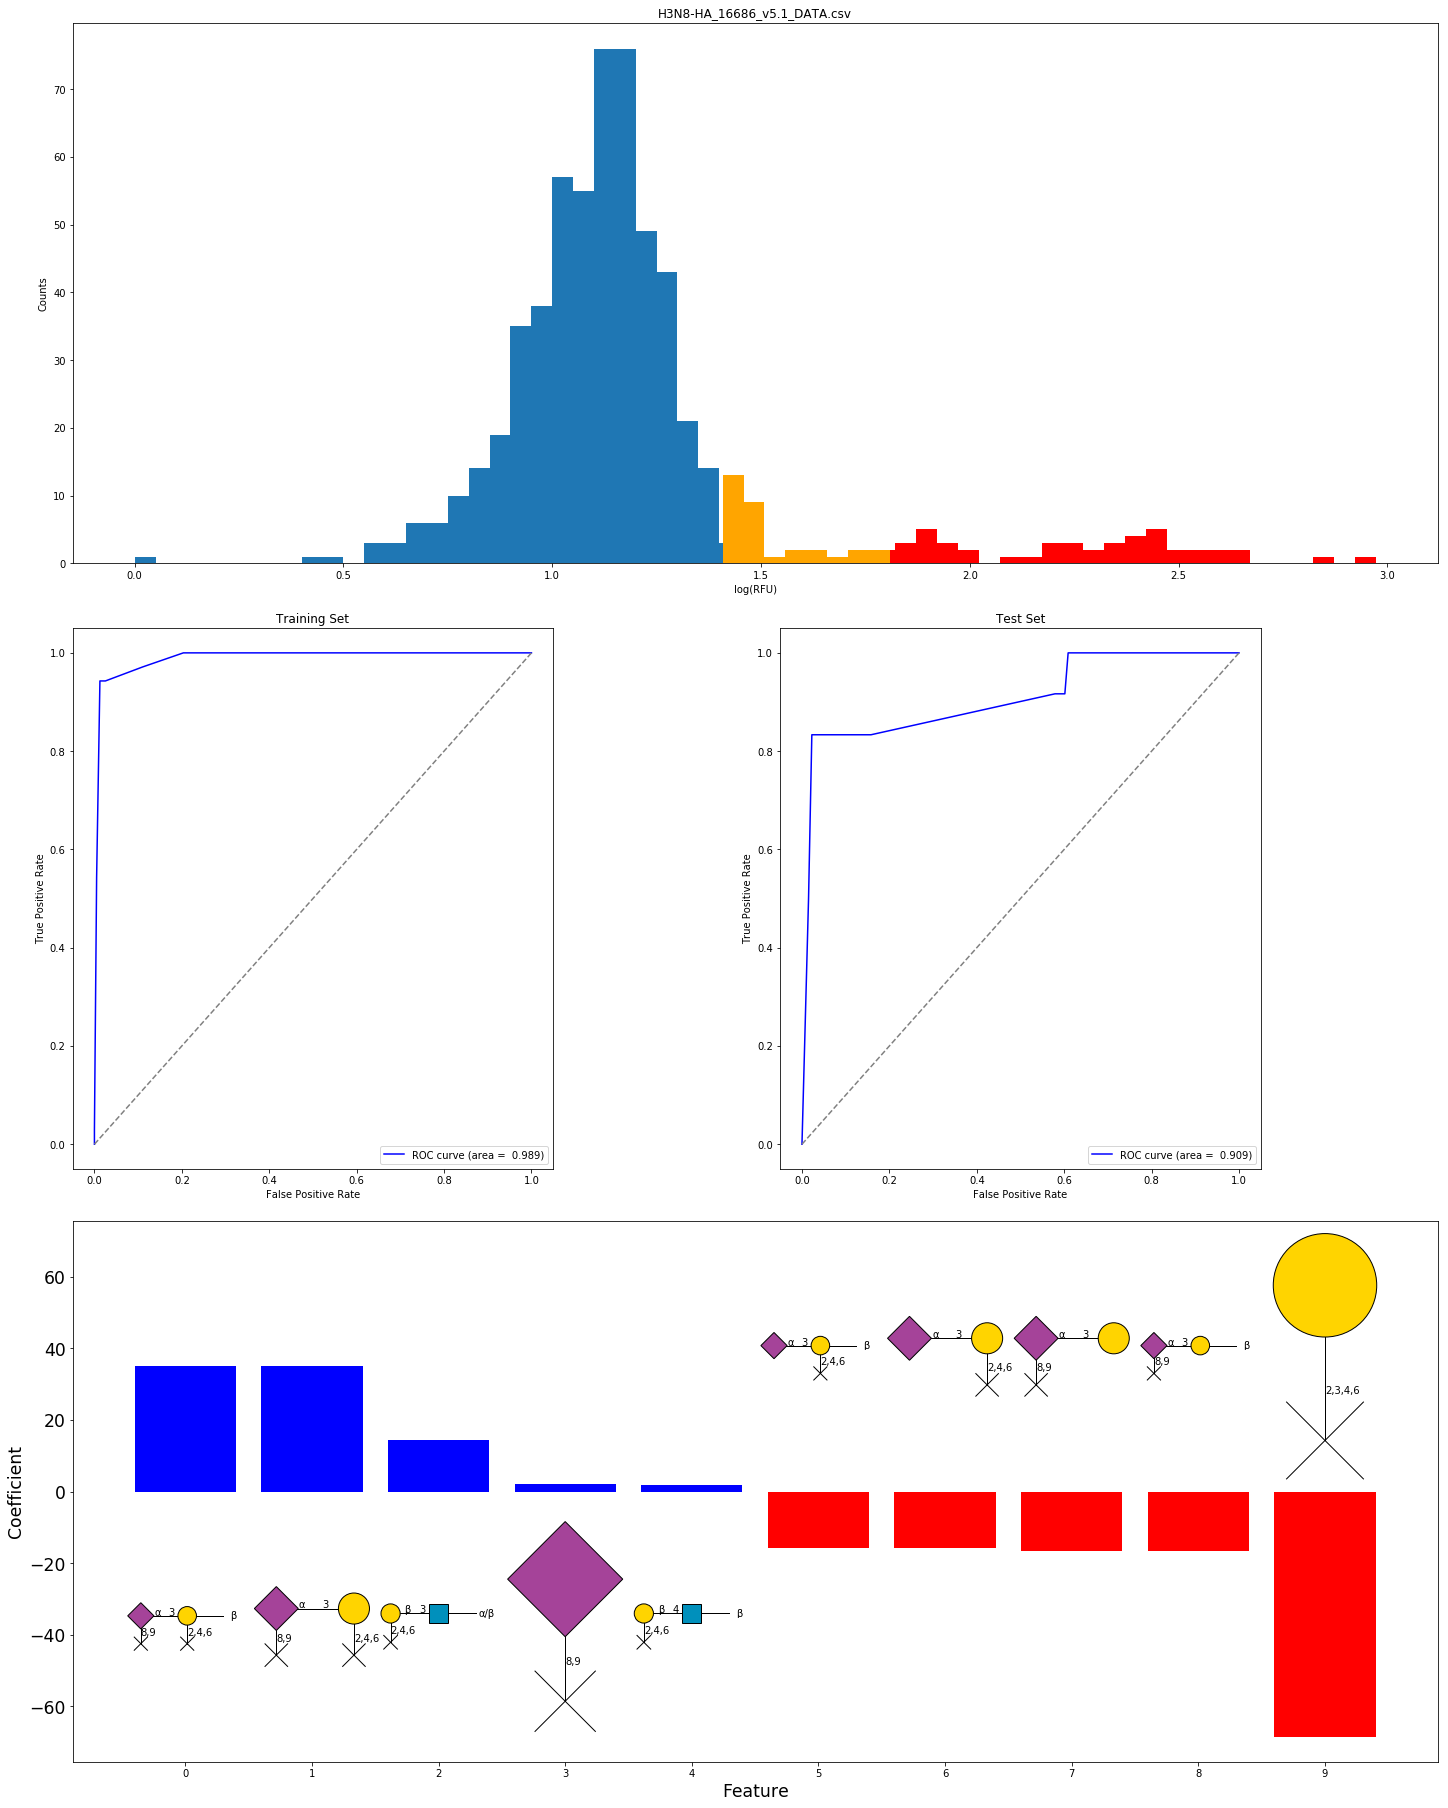

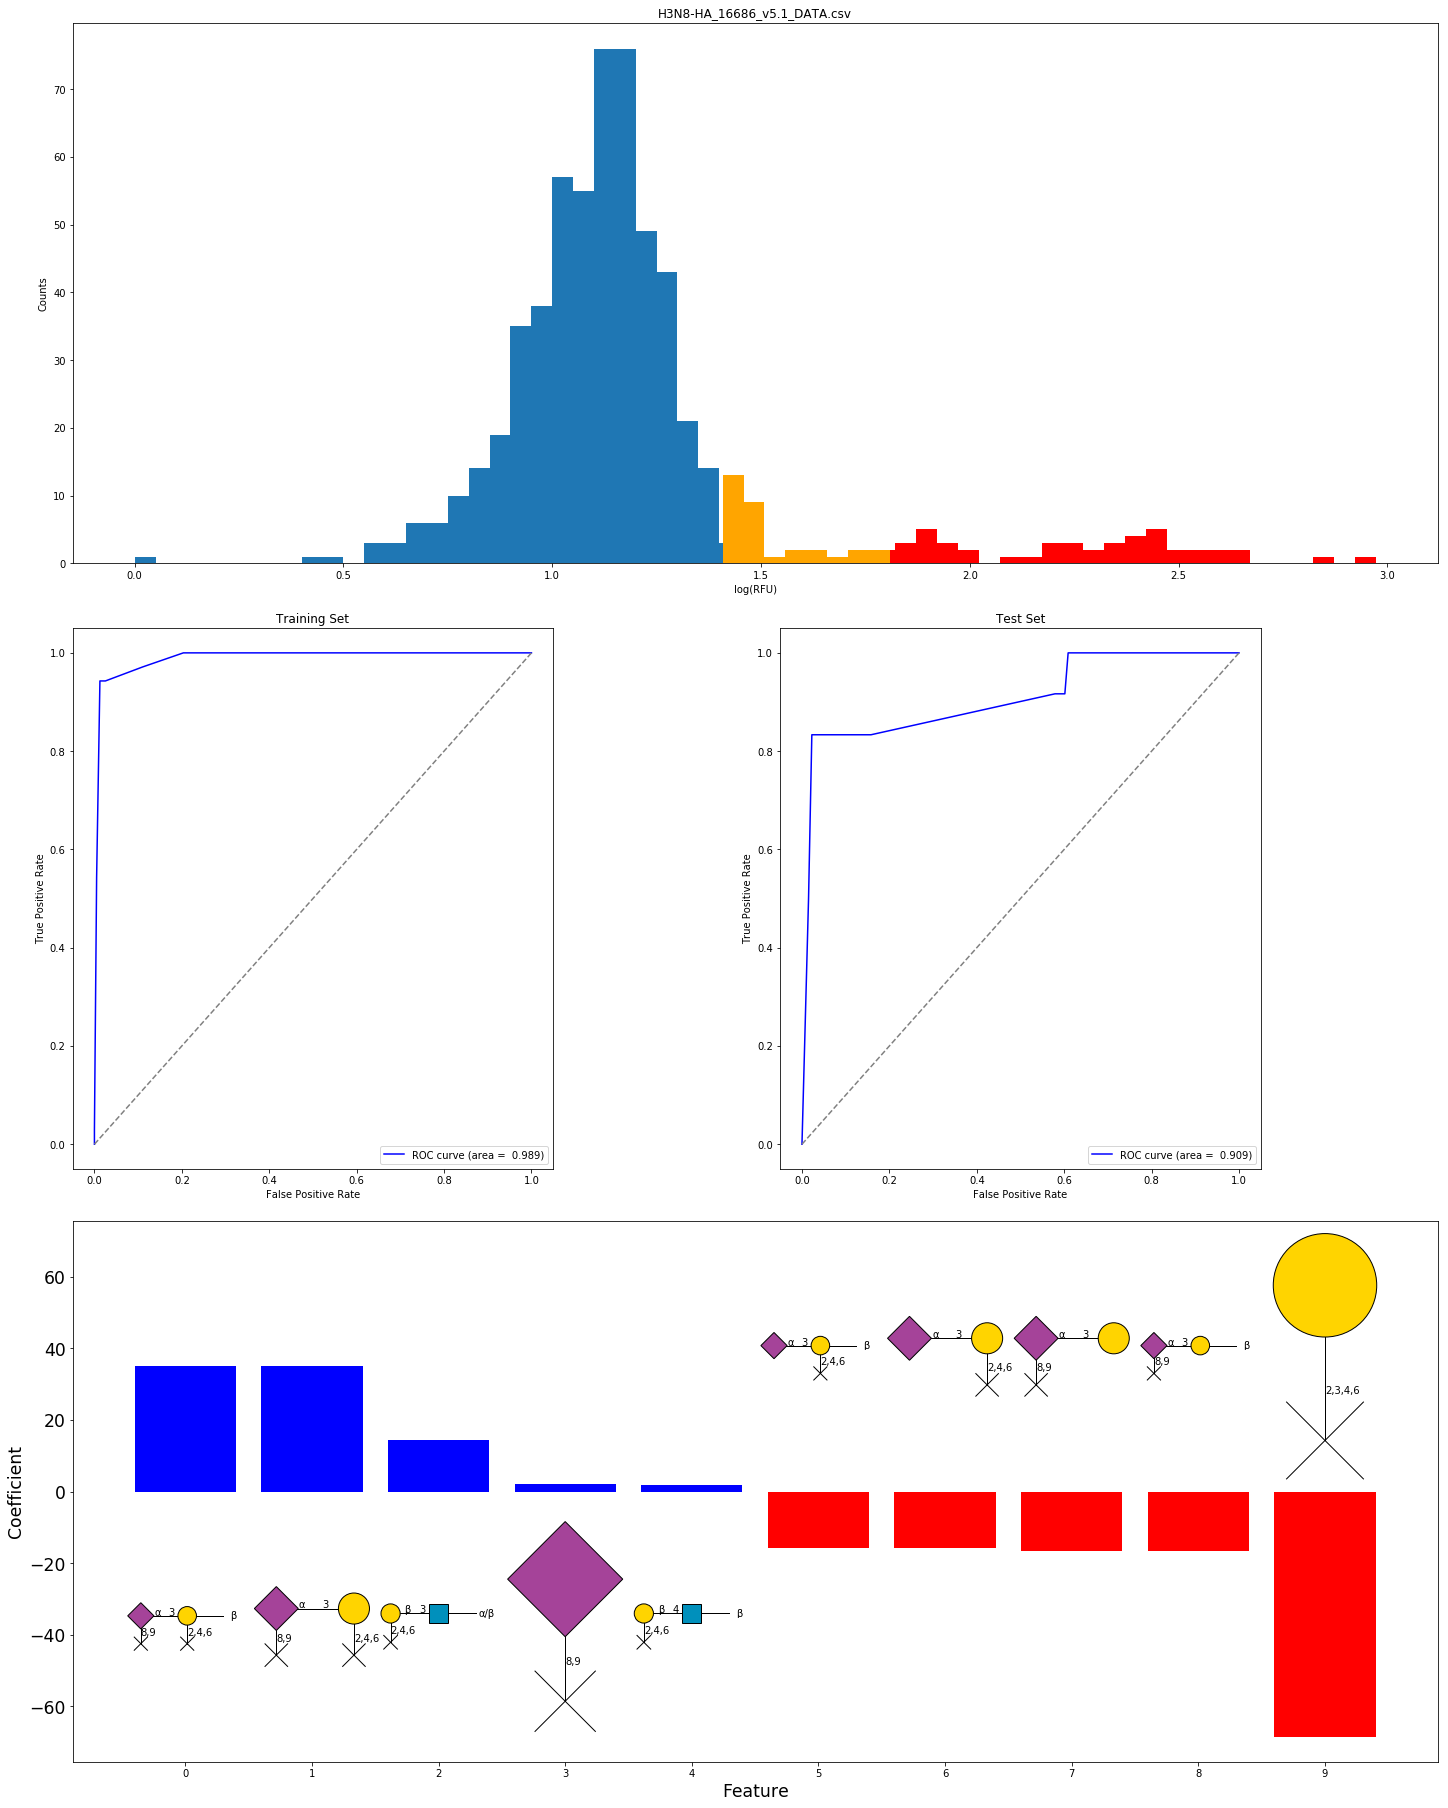

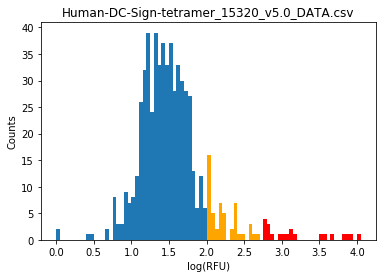

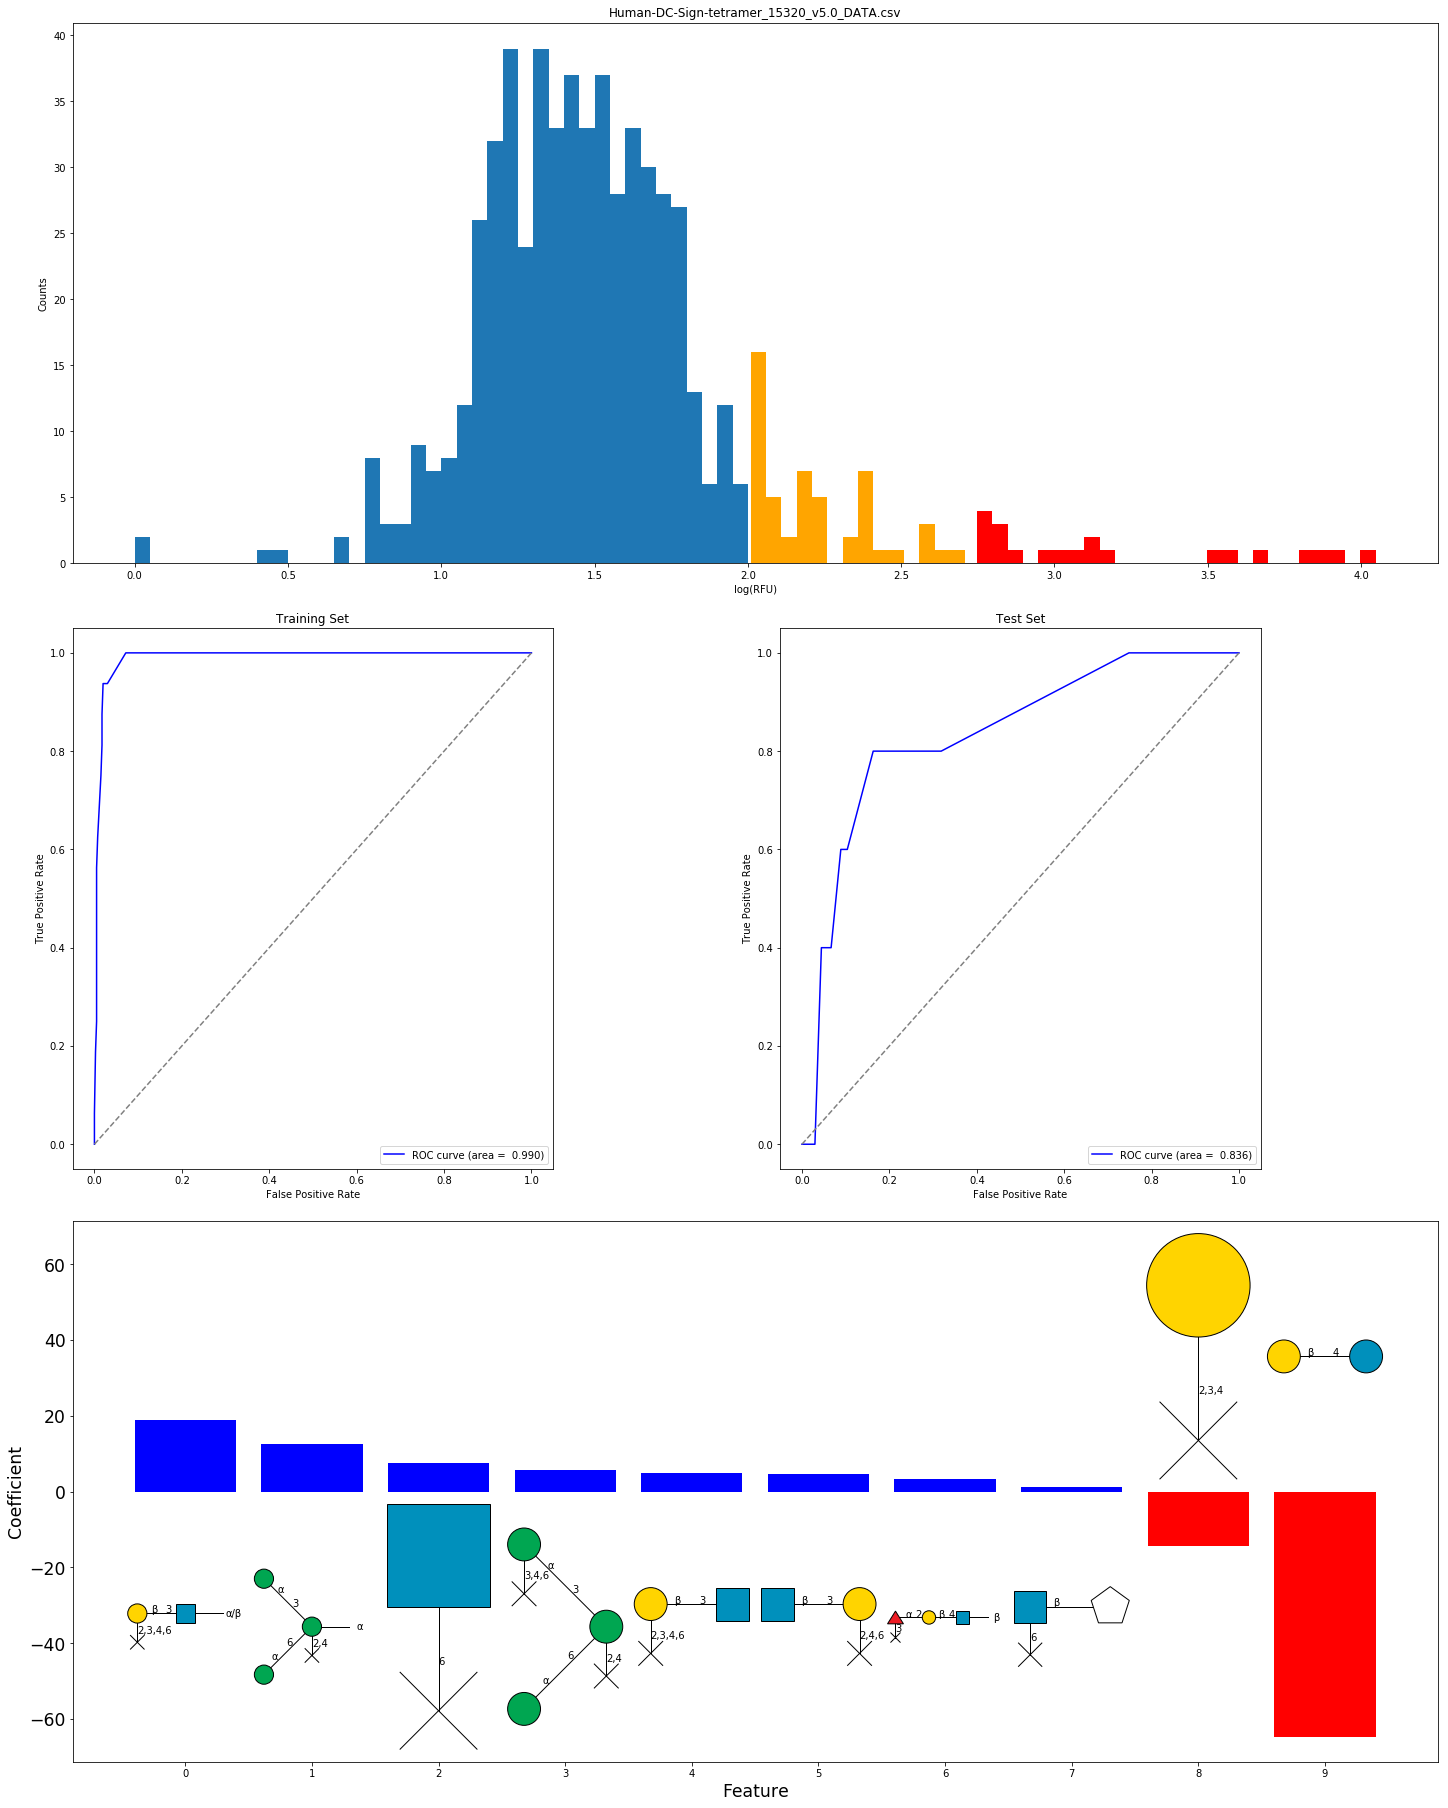

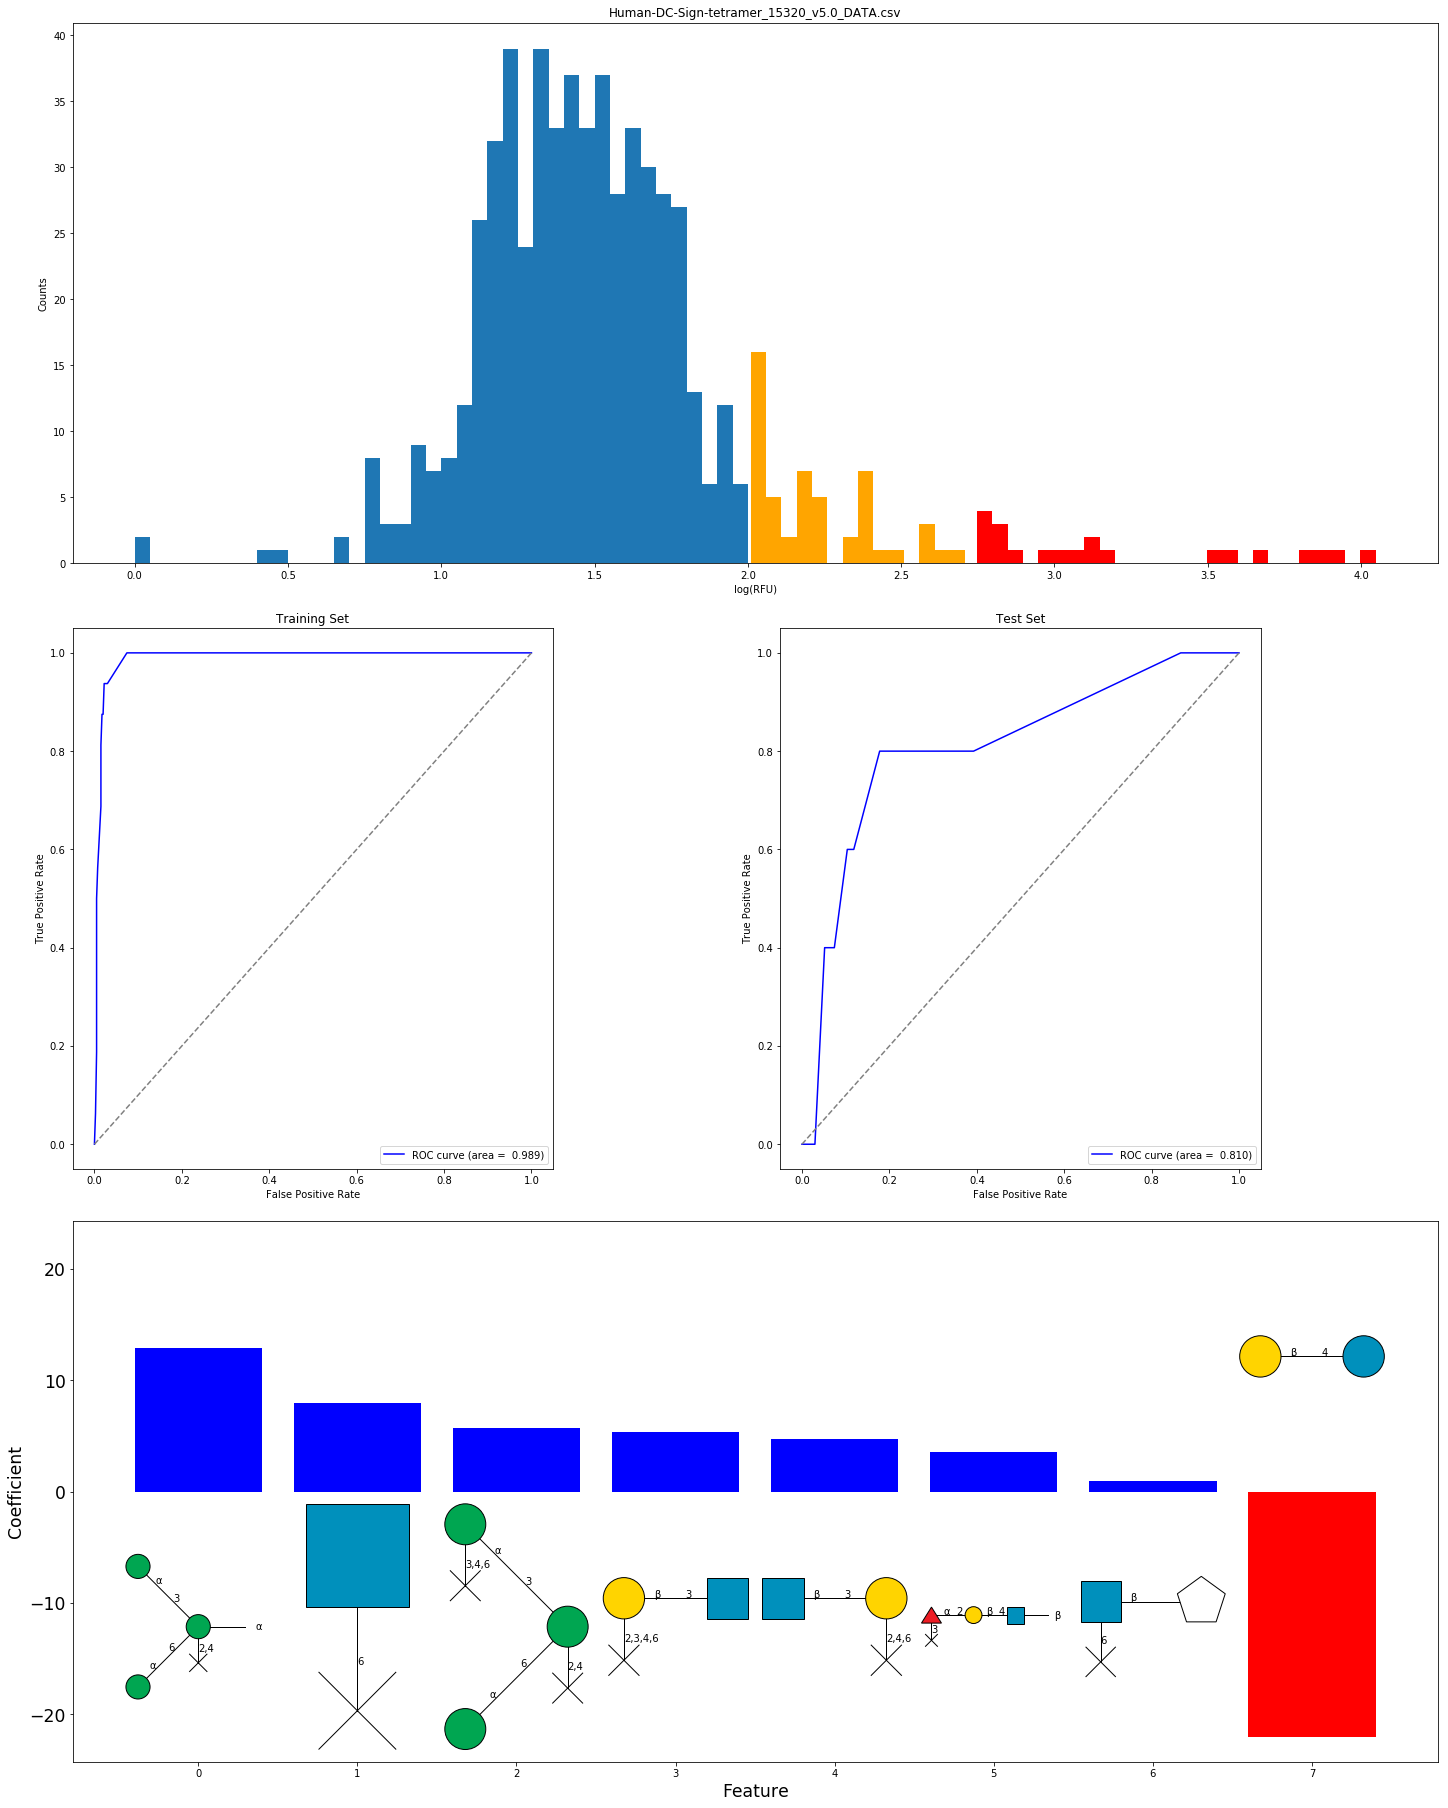

In [10]:
data = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for csv_file in csv_files:
        data[csv_file] = run_pipeline(GlycanData(os.path.join(DATA_DIR, csv_file)), csv_file, random_seed=42)
        

# Plot ROC curves and AUC values

Mean AUC value:  0.877
Median AUC value:  0.898
IQR of AUC values:  0.841 -  0.922


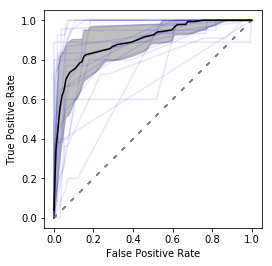

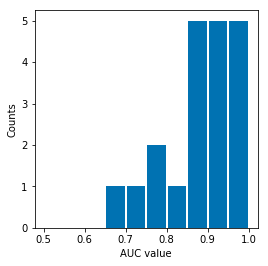

In [14]:
from scipy import interp

mean_fpr = np.linspace(0, 1, 100)

fig, axes = plt.subplots(figsize=(4, 4))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_aspect('equal', adjustable='box')
auc_values = []
tpr_list = []

for csv_file in csv_files:
    data_point = data[csv_file]
    y = data_point[7]
    X = data_point[8]
    logistic_clf = data_point[0]
    fpr, tpr, _ = roc_curve(y, logistic_clf.predict_proba(X)[:,1], drop_intermediate=False)
    tpr_list.append(interp(mean_fpr, fpr, tpr))
    auc_values.append(auc(fpr, tpr))
    ax.plot(fpr, tpr, color='blue', alpha=0.1, label=f'ROC curve (area = {auc(fpr, tpr): 2.3f})')
    ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))

mean_tpr = np.mean(tpr_list, axis=0)
median_tpr = np.median(tpr_list, axis=0)
upper_tpr = np.percentile(tpr_list, 75, axis=0)
lower_tpr = np.percentile(tpr_list, 25, axis=0)
ax.plot(mean_fpr, median_tpr, color='black')

ax.fill_between(mean_fpr, lower_tpr, upper_tpr, color='grey', alpha=.5,
                 label=r'$\pm$ 1 std. dev.')
fig.savefig("ROC_plot_all_curves.svg")
    
fig, axes = plt.subplots(figsize=(4, 4))
ax2 = axes
ax2.hist(auc_values, range=[0.5,1], bins=10, rwidth=0.9, color=(0, 114/255, 178/255))
ax2.set_xlabel("AUC value")
ax2.set_ylabel("Counts")
fig.savefig("AUC_histogram.svg")



print(f"Mean AUC value: {np.mean(auc_values): 1.3f}")

print(f"Median AUC value: {np.median(auc_values): 1.3f}")
print(f"IQR of AUC values: {np.percentile(auc_values, 25): 1.3f} - {np.percentile(auc_values, 75): 1.3f}")

In [16]:
# Generate table for tex document
for csv_file in csv_files:
    data_point = data[csv_file]
    y = data_point[7]
    X = data_point[8]
    logistic_clf = data_point[0]
    y_train = data_point[5]
    X_train = data_point[6]
    fpr, tpr, _ = roc_curve(y, logistic_clf.predict_proba(X)[:,1], drop_intermediate=False)
    fpr_tr, tpr_tr, _ = roc_curve(y_train, logistic_clf.predict_proba(X_train)[:,1], drop_intermediate=False)
    tpr_list.append(interp(mean_fpr, fpr, tpr))
    auc_values.append(auc(fpr, tpr))
    print(f"{csv_file} & {auc(fpr, tpr): 1.3f} & {auc(fpr_tr, tpr_tr): 1.3f} &.. & \\\\")


ABA_14361_100ug_v5.0_DATA.csv &  0.908 &  0.948 &.. & \\
ConA_13799-10ug_V5.0_DATA.csv &  0.987 &  0.989 &.. & \\
PNA_14030_10ug_v5.0_DATA.csv &  0.909 &  0.908 &.. & \\
RCAI_10ug_14110_v5.0_DATA.csv &  0.962 &  0.958 &.. & \\
PHA-E-10ug_13853_V5.0_DATA.csv &  0.984 &  0.985 &.. & \\
PHA-L-10ug_13856_V5.0_DATA.csv &  0.987 &  0.991 &.. & \\
LCA_10ug_13934_v5.0_DATA.csv &  0.987 &  0.972 &.. & \\
SNA_10ug_13631_v5.0_DATA.csv &  0.889 &  0.981 &.. & \\
MAL-I_10ug_13883_v5.0_DATA.csv &  0.855 &  0.881 &.. & \\
MAL_II_10ug_13886_v5.0_DATA.csv &  0.758 &  0.859 &.. & \\
GSL-I-B4_10ug_13920_v5.0_DATA.csv &  0.684 &  0.771 &.. & \\
jacalin-1ug_14301_v5.0_DATA.csv &  0.909 &  0.886 &.. & \\
WGA_14057_1ug_v5.0_DATA.csv &  0.872 &  0.895 &.. & \\
UEAI_100ug_13806_v5.0_DATA.csv &  0.725 &  0.904 &.. & \\
SBA_14042_10ug_v5.0_DATA.csv &  0.851 &  0.952 &.. & \\
DBA_100ug_13897_v5.0_DATA.csv &  0.883 &  0.928 &.. & \\
PSA_14040_10ug_v5.0_DATA.csv &  0.908 &  0.906 &.. & \\
HA_PuertoRico_8_34_13829_v


### Running file H3N8-HA_16686_v5.1_DATA.csv ###


Logistic regression
MCC score: 0.855
stdev: 0.0588

Regularisation parameter for H3N8-HA_16686_v5.1_DATA.csv = [8.49753436]
Logistic regression
MCC score: 0.835
stdev: 0.152



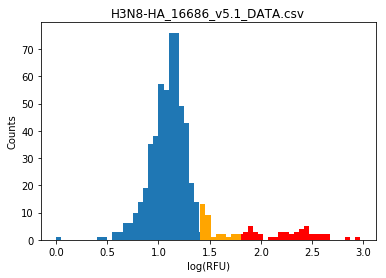

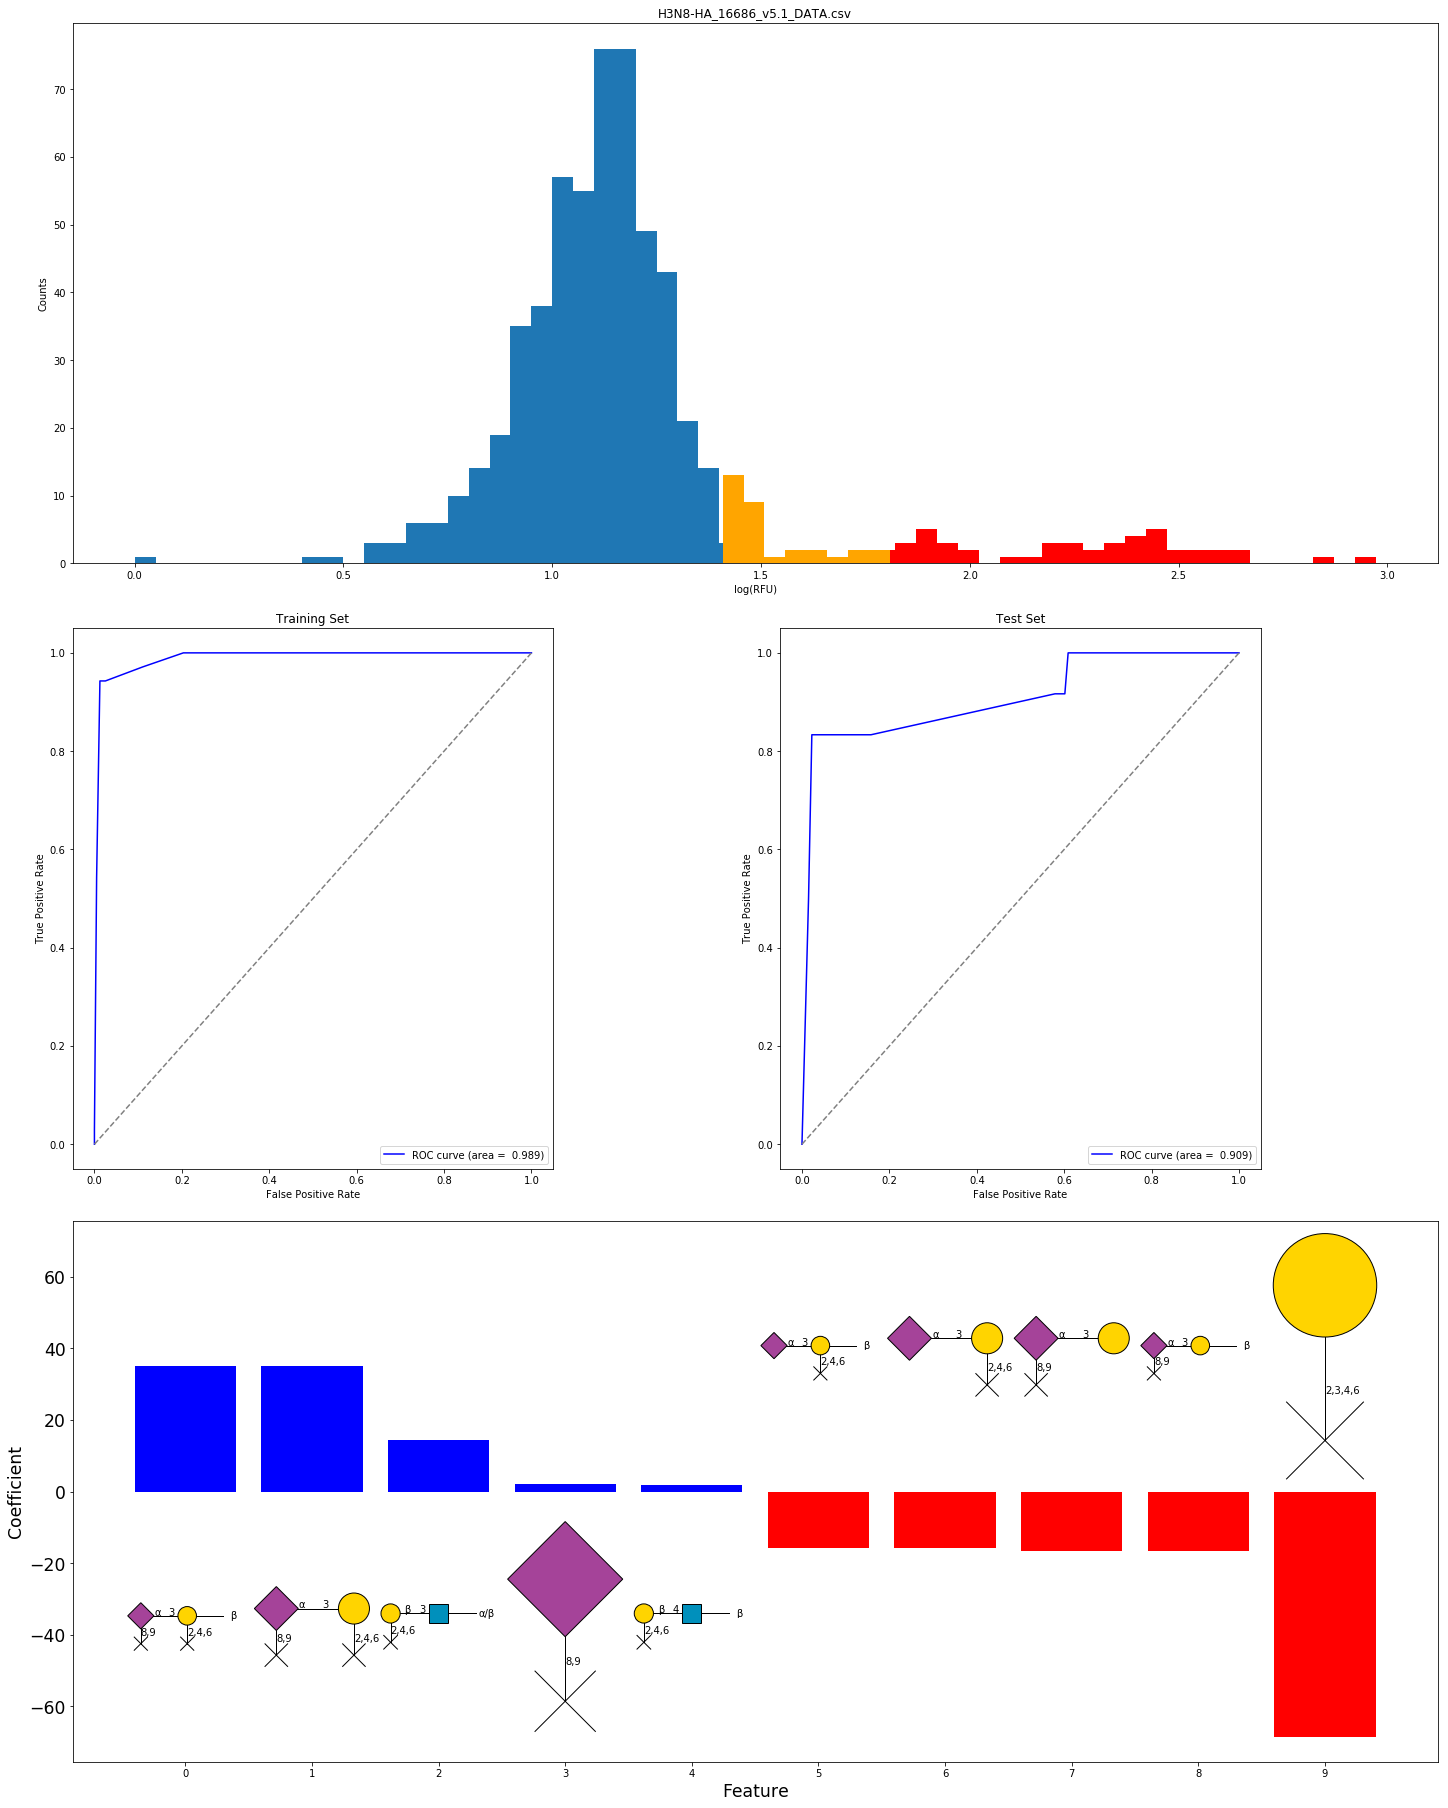

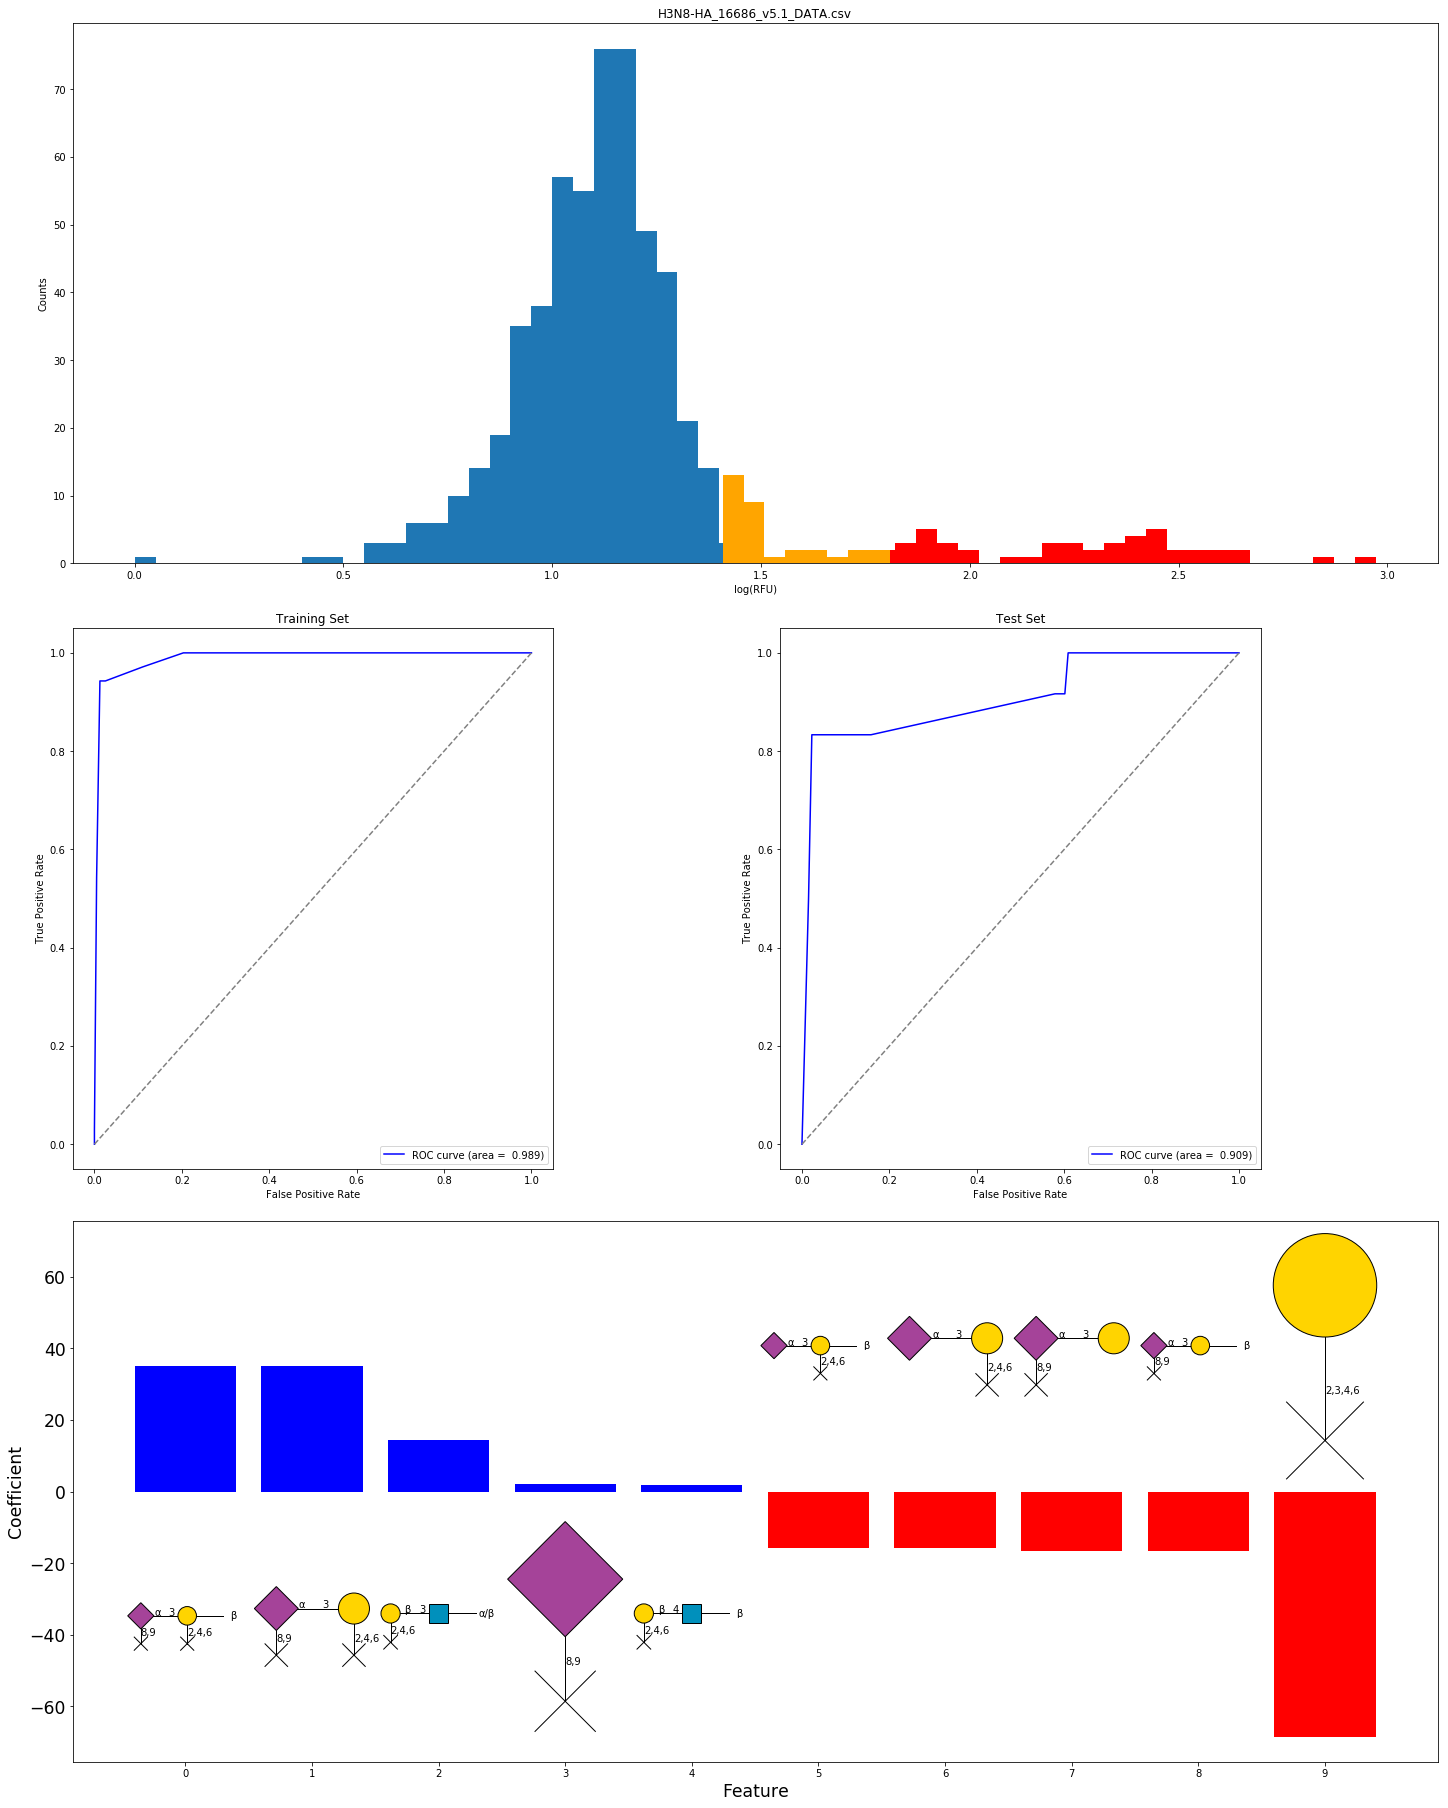

In [17]:
#A/harbor seal/Massachusetts/1/2011(H3N8)
seal_csv = 'H3N8-HA_16686_v5.1_DATA.csv'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    run_pipeline(GlycanData(os.path.join(DATA_DIR, seal_csv)), seal_csv, random_seed=42)


### Running file PNA_14030_10ug_v5.0_DATA.csv ###


Logistic regression
MCC score: 0.628
stdev: 0.0571

Regularisation parameter for PNA_14030_10ug_v5.0_DATA.csv = [0.03853529]
Logistic regression
MCC score: 0.638
stdev: 0.0871



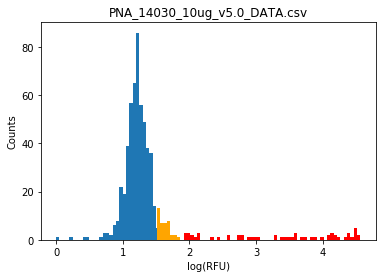

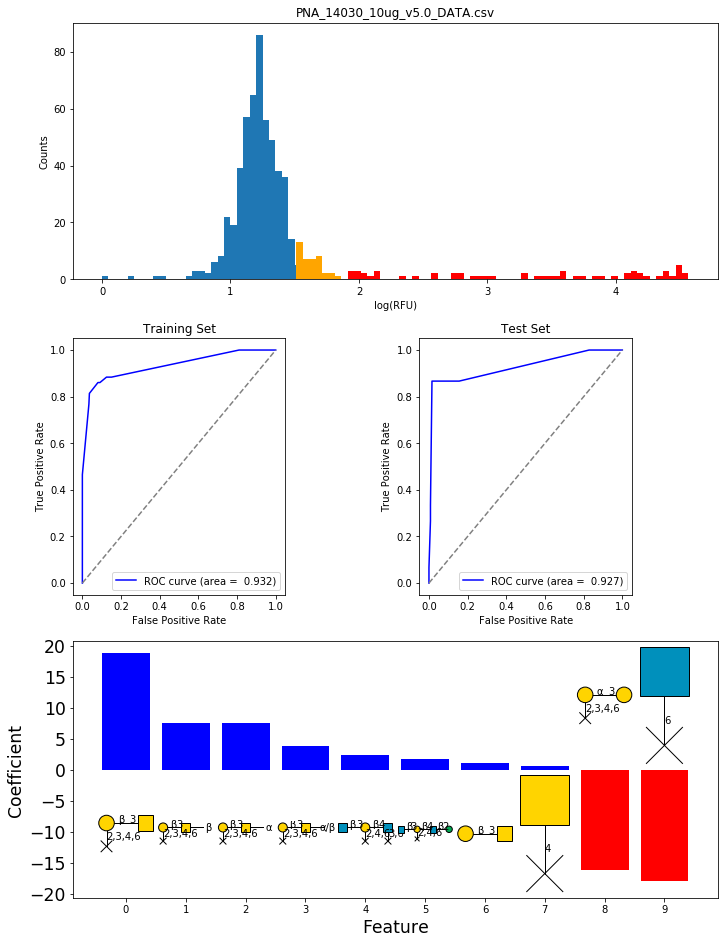

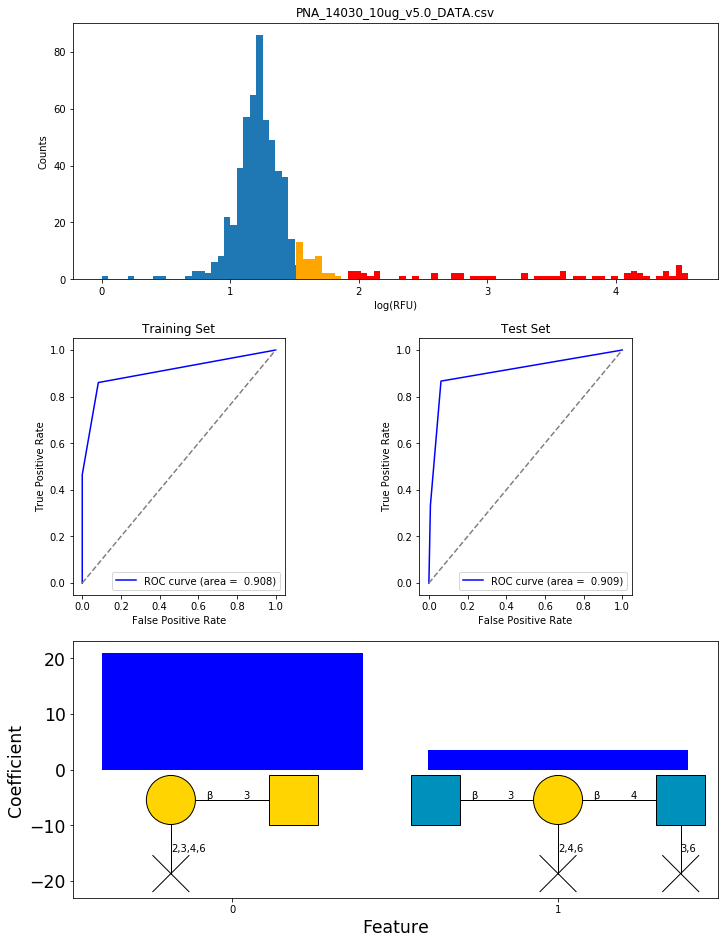

In [18]:
pna_csv = 'PNA_14030_10ug_v5.0_DATA.csv'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pna_data = run_pipeline(GlycanData(os.path.join(DATA_DIR, pna_csv)), pna_csv, random_seed=42, figsize=(10, 13))

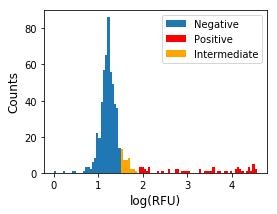

In [19]:
g = GlycanData(os.path.join(DATA_DIR, pna_csv))
test_csv_file = pna_csv

# Read in all glycan structures from csv. Match to closest CFG array version.
# Reads in glycan structures from respective array version.
glycan_list, array_version, mismatches, sum_lev = get_likely_cfg_array_version(list(g._csv_data['Structure']), mismatch_threshold=50)

# Get binding classes
thresholds = (1.5, 3.5)
binding_class_ternary = g.calculate_binders(thresholds)

# Plot data distribution
fig, ax = plt.subplots(figsize=[4,3])
g.plot_log_rfu_histogram(ax, title=test_csv_file, thresholds=thresholds)
ax.legend(['Negative', 'Positive', 'Intermediate'])
ax.set_xlabel('log(RFU)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title('')
fig.savefig('PNA_Histogram.svg')

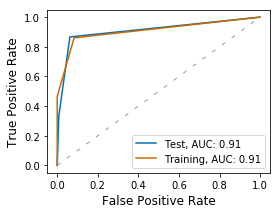

In [20]:
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
#ax.set_aspect('equal', adjustable='box')
auc_values = []
tpr_list = []

csv_file = pna_csv
data_point = data[csv_file]
y = data_point[7]
X = data_point[8]
y_train = data_point[5]
X_train = data_point[6]
logistic_clf = data_point[0]
fpr, tpr, _ = roc_curve(y, logistic_clf.predict_proba(X)[:,1], drop_intermediate=False)
fpr_train, tpr_train, _ = roc_curve(y_train, logistic_clf.predict_proba(X_train)[:,1], drop_intermediate=False)

ax.plot(fpr, tpr, color=(0, 0.45, 0.70), label=f'Test, AUC:{auc(fpr, tpr): 2.2f}')
ax.plot(fpr_train, tpr_train, color=(0.8, 0.4, 0), label=f'Training, AUC:{auc(fpr_train, tpr_train): 2.2f}')
ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))
ax.legend()
fig.savefig('PNA_ROC_Curves.svg')


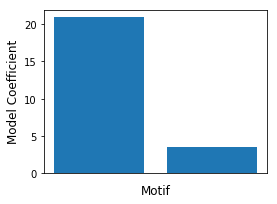

In [21]:
logistic_clf.coef_
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('Motif', fontsize=12)
ax.set_ylabel('Model Coefficient', fontsize=12)
ax.bar(range(0, len(logistic_clf.coef_[0])), sorted(logistic_clf.coef_[0], key=lambda x: -x))
#ax.set_ylim([-10, 20])
ax.set_xticklabels([])
ax.xaxis.set_ticks_position('none') 
fig.savefig('PNA_Coefficients.svg')

# Con A


### Running file ConA_13799-10ug_V5.0_DATA.csv ###


Logistic regression
MCC score: 0.925
stdev: 0.048

Regularisation parameter for ConA_13799-10ug_V5.0_DATA.csv = [0.17073526]
Logistic regression
MCC score: 0.928
stdev: 0.0486



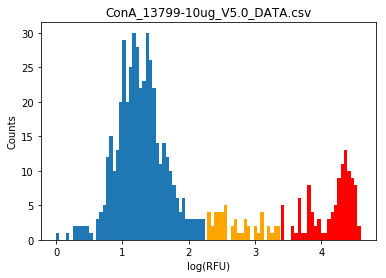

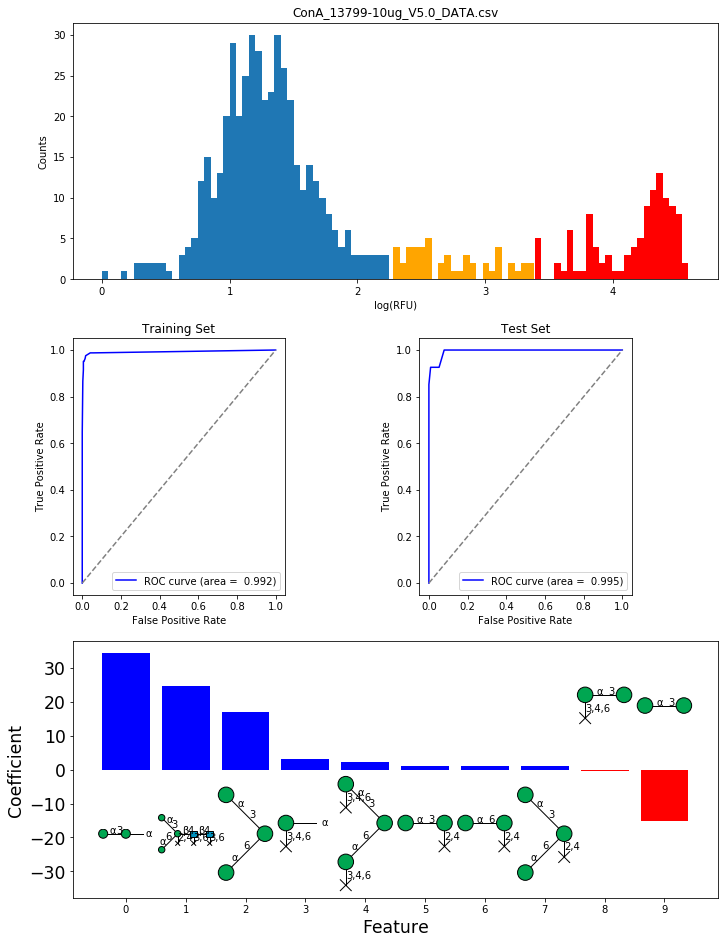

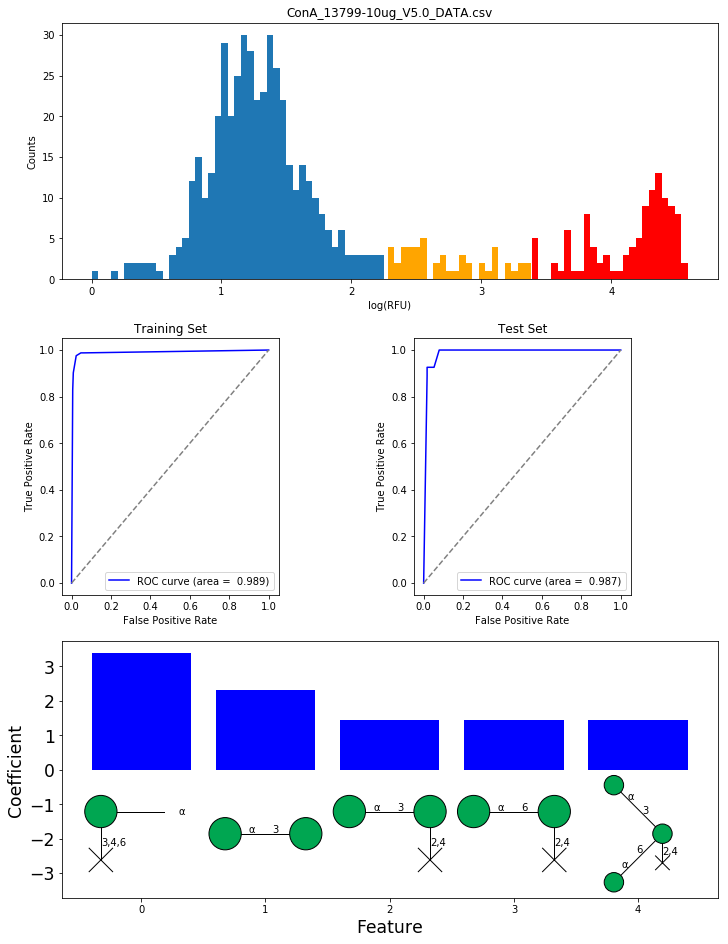

In [22]:
cona_csv = 'ConA_13799-10ug_V5.0_DATA.csv'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pna_data = run_pipeline(GlycanData(os.path.join(DATA_DIR, cona_csv)), cona_csv, random_seed=42, figsize=(10, 13))

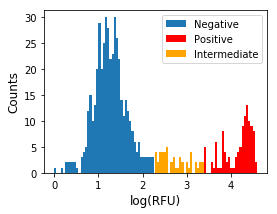

In [23]:
g = GlycanData(os.path.join(DATA_DIR, cona_csv))
test_csv_file = cona_csv

# Read in all glycan structures from csv. Match to closest CFG array version.
# Reads in glycan structures from respective array version.
glycan_list, array_version, mismatches, sum_lev = get_likely_cfg_array_version(list(g._csv_data['Structure']), mismatch_threshold=50)

# Get binding classes
thresholds = (1.5, 3.5)
binding_class_ternary = g.calculate_binders(thresholds)

# Plot data distribution
fig, ax = plt.subplots(figsize=[4,3])
g.plot_log_rfu_histogram(ax, title=test_csv_file, thresholds=thresholds)
ax.legend(['Negative', 'Positive', 'Intermediate'])
ax.set_xlabel('log(RFU)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title('')
fig.savefig('ConA_Histogram.svg')

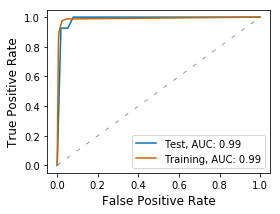

In [24]:
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
#ax.set_aspect('equal', adjustable='box')
auc_values = []
tpr_list = []

csv_file = cona_csv
data_point = data[csv_file]
y = data_point[7]
X = data_point[8]
y_train = data_point[5]
X_train = data_point[6]
logistic_clf = data_point[0]
fpr, tpr, _ = roc_curve(y, logistic_clf.predict_proba(X)[:,1], drop_intermediate=False)
fpr_train, tpr_train, _ = roc_curve(y_train, logistic_clf.predict_proba(X_train)[:,1], drop_intermediate=False)

ax.plot(fpr, tpr, color=(0, 0.45, 0.70), label=f'Test, AUC:{auc(fpr, tpr): 2.2f}')
ax.plot(fpr_train, tpr_train, color=(0.8, 0.4, 0), label=f'Training, AUC:{auc(fpr_train, tpr_train): 2.2f}')
ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))
ax.legend()
fig.savefig('ConA_ROC_Curves.svg')


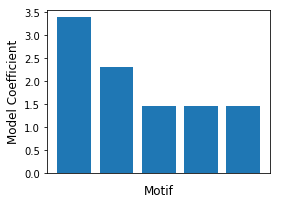

In [25]:
logistic_clf.coef_
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('Motif', fontsize=12)
ax.set_ylabel('Model Coefficient', fontsize=12)
ax.bar(range(0, len(logistic_clf.coef_[0])), sorted(logistic_clf.coef_[0], key=lambda x: -x))
#ax.set_ylim([-10, 20])
ax.set_xticklabels([])
ax.xaxis.set_ticks_position('none') 
fig.savefig('ConA_Coefficients.svg')

# RCA I


### Running file RCAI_10ug_14110_v5.0_DATA.csv ###


Logistic regression
MCC score: 0.89
stdev: 0.0646

Regularisation parameter for RCAI_10ug_14110_v5.0_DATA.csv = [0.06734151]
Logistic regression
MCC score: 0.859
stdev: 0.058



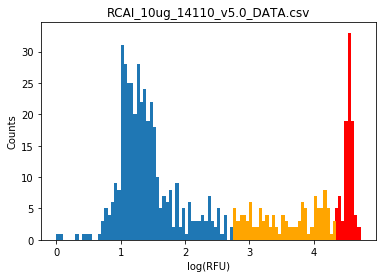

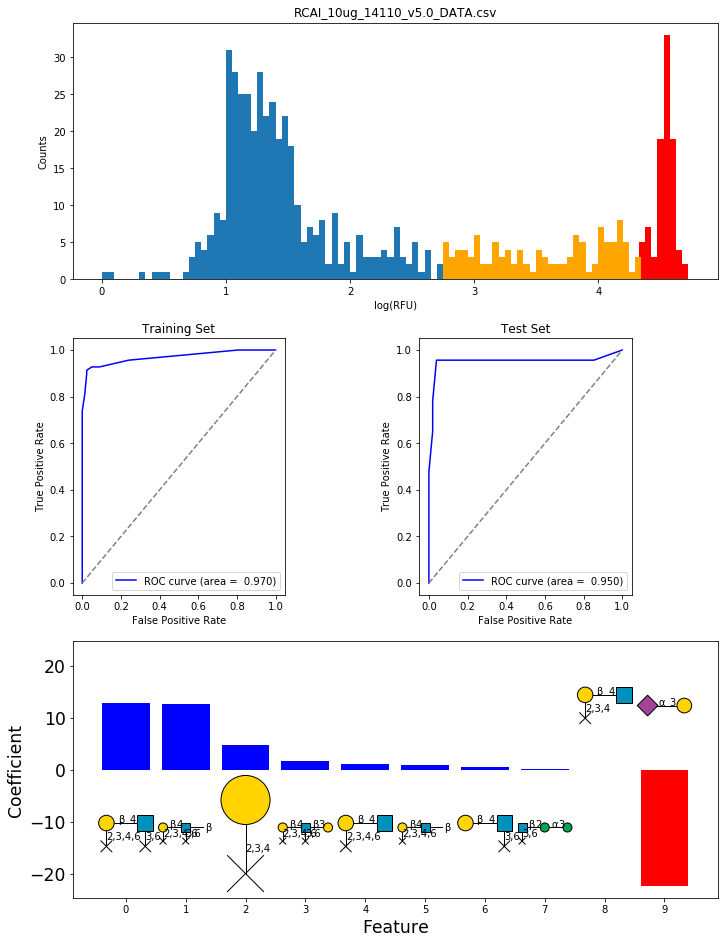

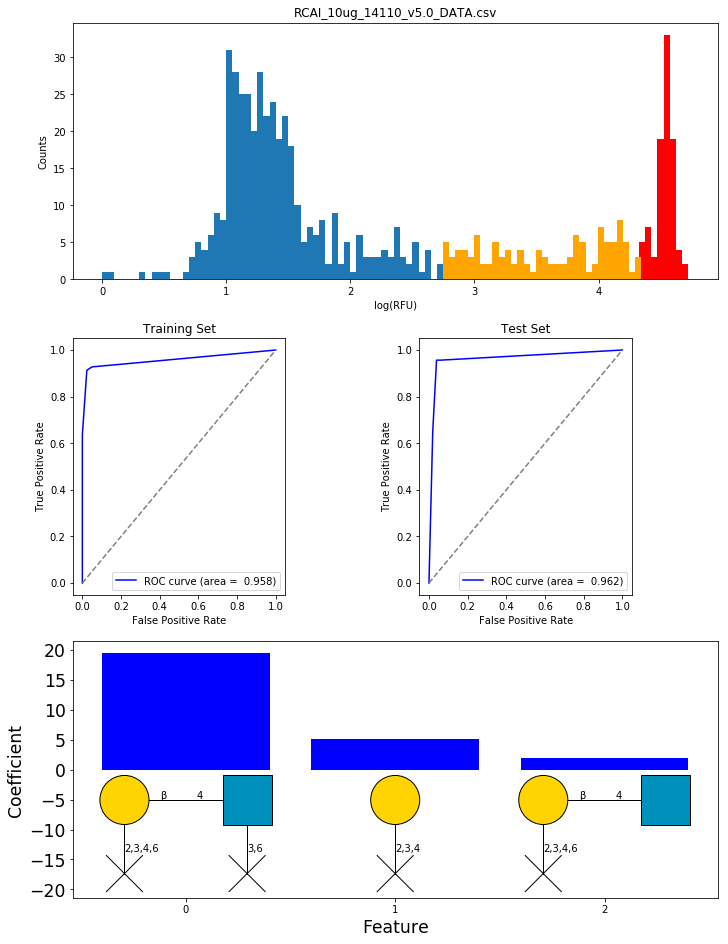

In [26]:
rcai_csv = 'RCAI_10ug_14110_v5.0_DATA.csv'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pna_data = run_pipeline(GlycanData(os.path.join(DATA_DIR, rcai_csv)), rcai_csv, random_seed=42, figsize=(10, 13))

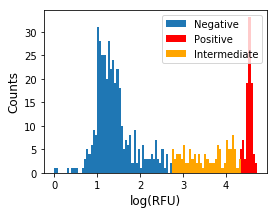

In [27]:
g = GlycanData(os.path.join(DATA_DIR, rcai_csv))
test_csv_file = rcai_csv

# Read in all glycan structures from csv. Match to closest CFG array version.
# Reads in glycan structures from respective array version.
glycan_list, array_version, mismatches, sum_lev = get_likely_cfg_array_version(list(g._csv_data['Structure']), mismatch_threshold=50)

# Get binding classes
thresholds = (1.5, 3.5)
binding_class_ternary = g.calculate_binders(thresholds)

# Plot data distribution
fig, ax = plt.subplots(figsize=[4,3])
g.plot_log_rfu_histogram(ax, title=test_csv_file, thresholds=thresholds)
ax.legend(['Negative', 'Positive', 'Intermediate'])
ax.set_xlabel('log(RFU)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title('')
fig.savefig('RCAI_Histogram.svg')

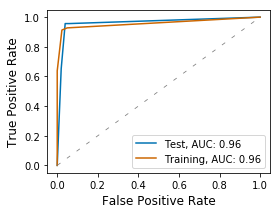

In [28]:
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
#ax.set_aspect('equal', adjustable='box')
auc_values = []
tpr_list = []

csv_file = rcai_csv
data_point = data[csv_file]
y = data_point[7]
X = data_point[8]
y_train = data_point[5]
X_train = data_point[6]
logistic_clf = data_point[0]
fpr, tpr, _ = roc_curve(y, logistic_clf.predict_proba(X)[:,1], drop_intermediate=False)
fpr_train, tpr_train, _ = roc_curve(y_train, logistic_clf.predict_proba(X_train)[:,1], drop_intermediate=False)

ax.plot(fpr, tpr, color=(0, 0.45, 0.70), label=f'Test, AUC:{auc(fpr, tpr): 2.2f}')
ax.plot(fpr_train, tpr_train, color=(0.8, 0.4, 0), label=f'Training, AUC:{auc(fpr_train, tpr_train): 2.2f}')
ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))
ax.legend()
fig.savefig('RCAI_ROC_Curves.svg')


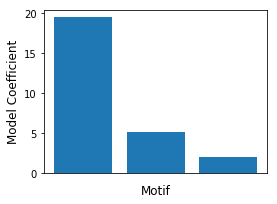

In [29]:
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('Motif', fontsize=12)
ax.set_ylabel('Model Coefficient', fontsize=12)
ax.bar(range(0, len(logistic_clf.coef_[0])), sorted(logistic_clf.coef_[0], key=lambda x: -x))
#ax.set_ylim([-10, 20])
ax.set_xticklabels([])
ax.xaxis.set_ticks_position('none') 
fig.savefig('RCAI_Coefficients.svg')

# Seal FLU!!


### Running file H3N8-HA_16686_v5.1_DATA.csv ###


Logistic regression
MCC score: 0.855
stdev: 0.0588

Regularisation parameter for H3N8-HA_16686_v5.1_DATA.csv = [8.49753436]
Logistic regression
MCC score: 0.835
stdev: 0.152



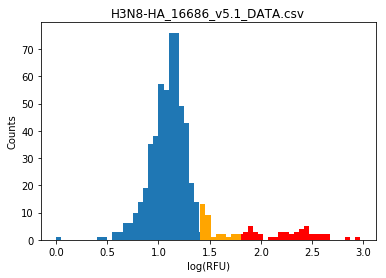

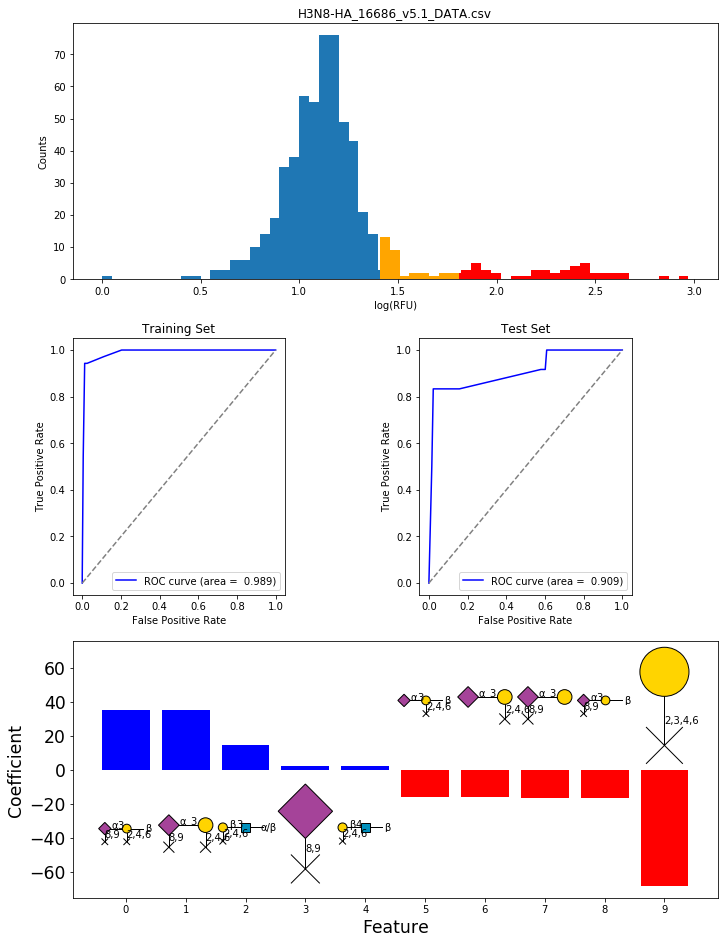

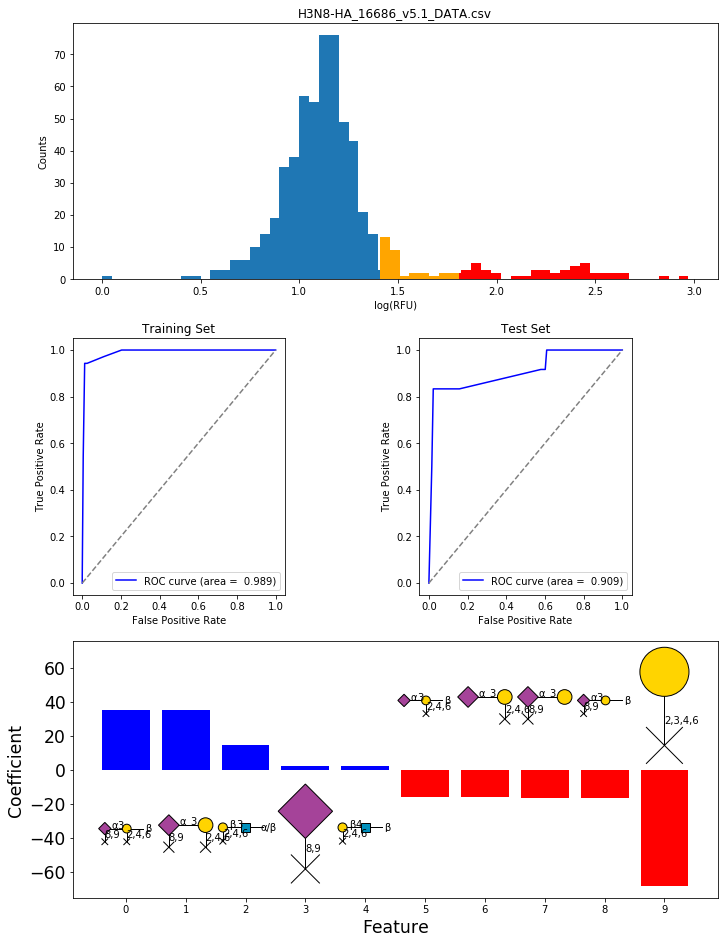

In [30]:
seal_csv = 'H3N8-HA_16686_v5.1_DATA.csv'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    seal_data = run_pipeline(GlycanData(os.path.join(DATA_DIR, seal_csv)), seal_csv, random_seed=42, figsize=(10, 13))

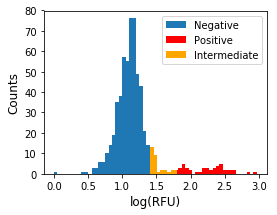

In [31]:
g = GlycanData(os.path.join(DATA_DIR, seal_csv))
test_csv_file = seal_csv

# Read in all glycan structures from csv. Match to closest CFG array version.
# Reads in glycan structures from respective array version.
glycan_list, array_version, mismatches, sum_lev = get_likely_cfg_array_version(list(g._csv_data['Structure']), mismatch_threshold=50)

# Get binding classes
thresholds = (1.5, 3.5)
binding_class_ternary = g.calculate_binders(thresholds)

# Plot data distribution
fig, ax = plt.subplots(figsize=[4,3])
g.plot_log_rfu_histogram(ax, title=test_csv_file, thresholds=thresholds)
ax.legend(['Negative', 'Positive', 'Intermediate'])
ax.set_xlabel('log(RFU)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title('')
fig.savefig('Seal_HA_Histogram.svg')

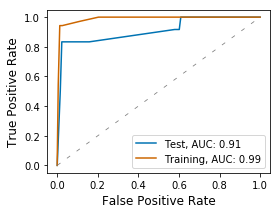

In [32]:
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
#ax.set_aspect('equal', adjustable='box')
auc_values = []
tpr_list = []

csv_file = seal_csv
data_point = data[csv_file]
y = data_point[7]
X = data_point[8]
y_train = data_point[5]
X_train = data_point[6]
logistic_clf = data_point[0]
fpr, tpr, _ = roc_curve(y, logistic_clf.predict_proba(X)[:,1], drop_intermediate=False)
fpr_train, tpr_train, _ = roc_curve(y_train, logistic_clf.predict_proba(X_train)[:,1], drop_intermediate=False)

ax.plot(fpr, tpr, color=(0, 0.45, 0.70), label=f'Test, AUC:{auc(fpr, tpr): 2.2f}')
ax.plot(fpr_train, tpr_train, color=(0.8, 0.4, 0), label=f'Training, AUC:{auc(fpr_train, tpr_train): 2.2f}')
ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))
ax.legend()
fig.savefig('Seal_HA_ROC_Curves.svg')


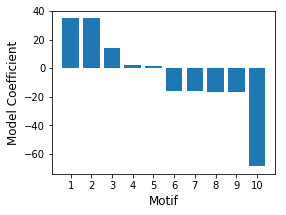

In [33]:
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('Motif', fontsize=12)
ax.set_ylabel('Model Coefficient', fontsize=12)
ax.bar(range(1, len(logistic_clf.coef_[0]) + 1), sorted(logistic_clf.coef_[0], key=lambda x: -x))
#ax.set_ylim([-10, 20])
ax.set_xticks(range(1, len(logistic_clf.coef_[0]) + 1))
#ax.xaxis.set_ticks_position('none') 
fig.savefig('Seal_HA_Coefficients.svg')

# Human Flu


### Running file HA_PuertoRico_8_34_13829_v5_DATA.csv ###


Logistic regression
MCC score: 0.54
stdev: 0.084

Regularisation parameter for HA_PuertoRico_8_34_13829_v5_DATA.csv = [0.14174742]
Logistic regression
MCC score: 0.547
stdev: 0.0462



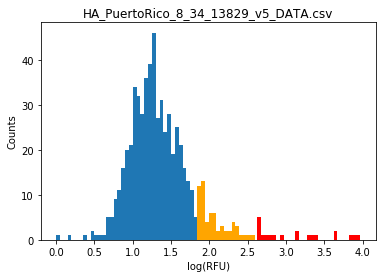

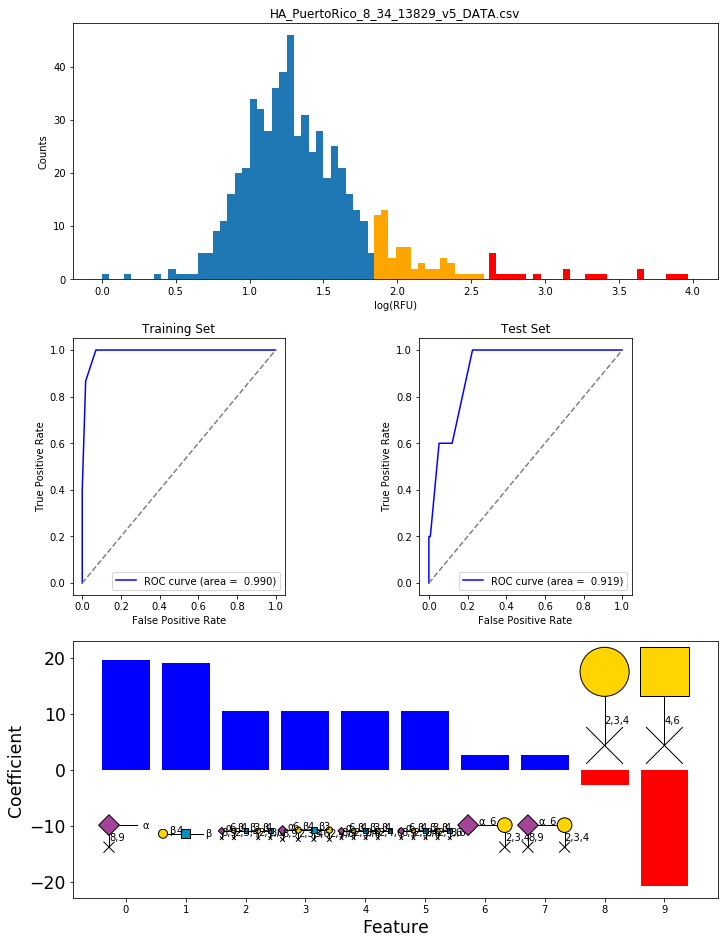

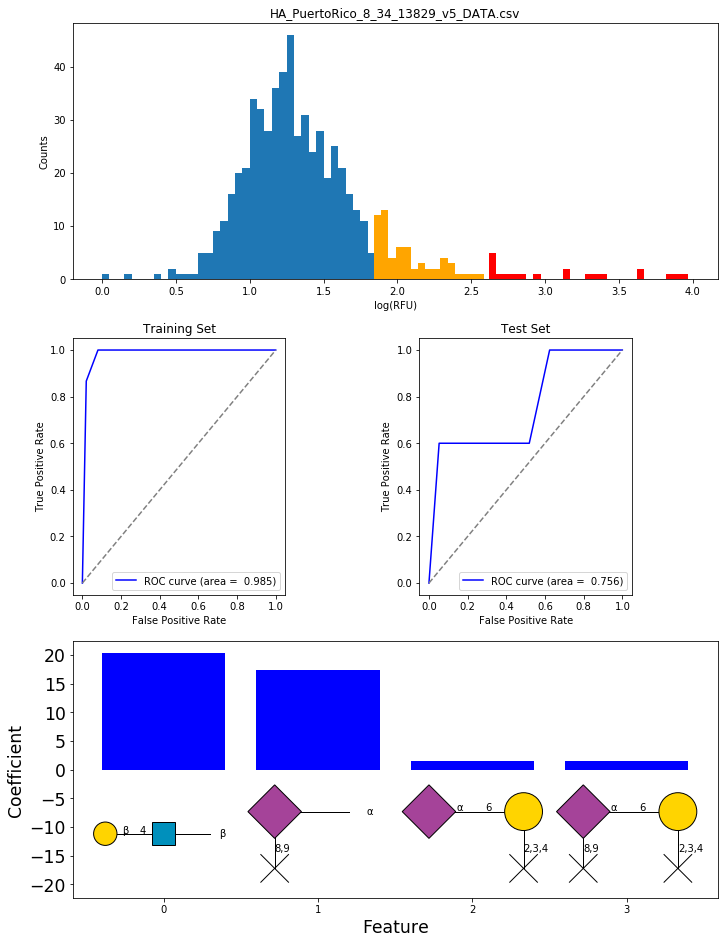

In [34]:
flu_csv = 'HA_PuertoRico_8_34_13829_v5_DATA.csv'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    flu_data = run_pipeline(GlycanData(os.path.join(DATA_DIR, flu_csv)), flu_csv, random_seed=42, figsize=(10, 13))

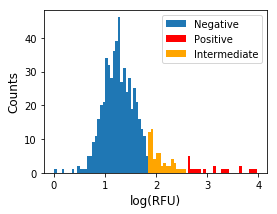

In [35]:
g = GlycanData(os.path.join(DATA_DIR, flu_csv))
test_csv_file = flu_csv

# Read in all glycan structures from csv. Match to closest CFG array version.
# Reads in glycan structures from respective array version.
glycan_list, array_version, mismatches, sum_lev = get_likely_cfg_array_version(list(g._csv_data['Structure']), mismatch_threshold=50)

# Get binding classes
thresholds = (1.5, 3.5)
binding_class_ternary = g.calculate_binders(thresholds)

# Plot data distribution
fig, ax = plt.subplots(figsize=[4,3])
g.plot_log_rfu_histogram(ax, title=test_csv_file, thresholds=thresholds)
ax.legend(['Negative', 'Positive', 'Intermediate'])
ax.set_xlabel('log(RFU)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title('')
fig.savefig('Human_HA_PR_Histogram.svg')

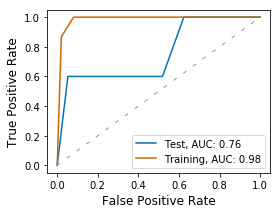

In [36]:
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
#ax.set_aspect('equal', adjustable='box')
auc_values = []
tpr_list = []

csv_file = flu_csv
data_point = data[csv_file]
y = data_point[7]
X = data_point[8]
y_train = data_point[5]
X_train = data_point[6]
logistic_clf = data_point[0]
fpr, tpr, _ = roc_curve(y, logistic_clf.predict_proba(X)[:,1], drop_intermediate=False)
fpr_train, tpr_train, _ = roc_curve(y_train, logistic_clf.predict_proba(X_train)[:,1], drop_intermediate=False)

ax.plot(fpr, tpr, color=(0, 0.45, 0.70), label=f'Test, AUC:{auc(fpr, tpr): 2.2f}')
ax.plot(fpr_train, tpr_train, color=(0.8, 0.4, 0), label=f'Training, AUC:{auc(fpr_train, tpr_train): 2.2f}')
ax.plot([0,1], [0,1], linestyle='--', color='grey', linewidth=0.8, dashes=(5, 10))
ax.legend()
fig.savefig('Human_HA_PR_ROC_Curves.svg')


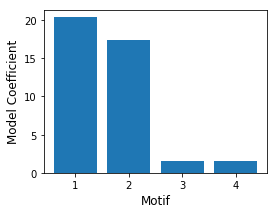

In [37]:
fig, axes = plt.subplots(figsize=(4, 3))

ax = axes
ax.set_title('')
#ax.legend(loc="lower right")
ax.set_xlabel('Motif', fontsize=12)
ax.set_ylabel('Model Coefficient', fontsize=12)
ax.bar(range(1, len(logistic_clf.coef_[0])+1), sorted(logistic_clf.coef_[0], key=lambda x: -x))
#ax.set_ylim([-10, 20])
#ax.set_xticklabels([])
#ax.xaxis.set_ticks_position('none') 
fig.savefig('Human_HA_PR_Coefficients.svg')

In [38]:
# Move all generated svg files into a separate folder
import shutil

sourcefiles = os.listdir()
destinationpath = './Plots'
for file in sourcefiles:
    if file.endswith('.svg'):
        shutil.move(file, os.path.join(destinationpath,file))